#### Graph Signal Processing Data Augmentation

In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## Step 1: Read in dataset

### Read in dataset - Coordinates System

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import networkx as nx

In [3]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets/ntu_dataset


In [4]:
rp_np = np.loadtxt('label_cor.txt')
rp_np = np.unique(rp_np, axis = 0)

print(rp_np.shape)

(277, 2)


### Convert to x,y system

In [5]:
import math

def get_xycoords(origin_lat, origin_lon, rp_array):
    
    xy_coords = np.zeros((277,2), dtype = np.float64)
    cur_index = 0
    
    for rp in rp_array:
        
        lat, lon = rp[0], rp[1]
        # *1000 to convert from km to m
        dx = ((origin_lon - lon)*40000*math.cos((origin_lat+lat)*math.pi/360)/360)*1000 
        dy = ((origin_lat - lat)*40000/360)*1000    
        xy_coords[cur_index][0] = dx
        xy_coords[cur_index][1] = dy
        
        cur_index += 1
        
    return xy_coords

In [6]:
# Selecting rp with rp_index = 266 as the origin point (last point), calculate x,y coordinates of all other points from
# that origin
origin_lat, origin_lon = rp_np[266][0], rp_np[266][1]
xy_coords = get_xycoords(origin_lat, origin_lon, rp_np)

# Combine the lat, lon and x,y numpy arrays
rp_coords = np.concatenate((rp_np, xy_coords), axis = 1)
print(rp_coords.shape)

(277, 4)


In [7]:
rp_indexes = [i for i in range(len(rp_coords))]
rp_lat = rp_coords[:,0]
rp_long = rp_coords[:,1]
rp_x = rp_coords[:,2]
rp_y = rp_coords[:,3]

rp_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
rp_df = pd.DataFrame(data = rp_data)

print(f'No. of total reference points: {len(rp_indexes)}')

No. of total reference points: 277


In [8]:
rp0_df = rp_df[(rp_df['rp_lat'] == 1.35487300000000) & (rp_df['rp_long'] == 103.688911000000)]
print(f'No. of repeated samples: {len(rp0_df)}')

No. of repeated samples: 1


In [9]:
rp_df.head(5)

rp_index    rp_lat     rp_long        rp_x        rp_y
0         0  1.349733  103.685176  110.635844  571.111111
1         1  1.349733  103.685425   82.976883  571.111111
2         2  1.349733  103.685674   55.317922  571.111111
3         3  1.349733  103.685923   27.658961  571.111111
4         4  1.349733  103.686172    0.000000  571.111111

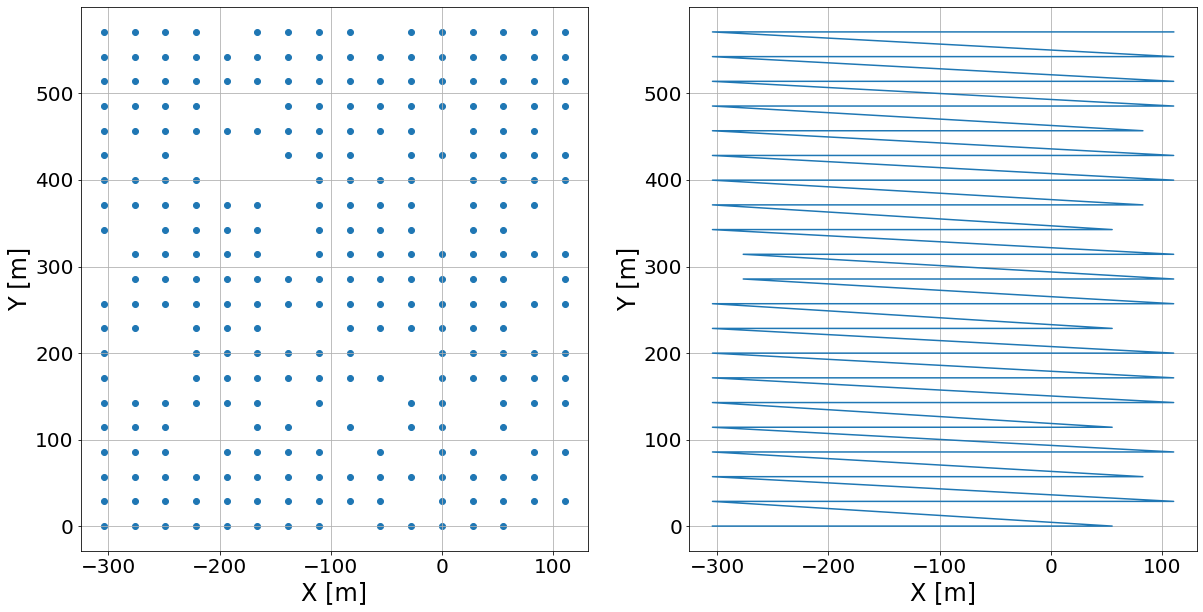

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]

xs, ys = rp_df['rp_x'], rp_df['rp_y']
fig, ax = plt.subplots(1, 2)

ax[0].scatter(xs, ys)
ax[0].set_xlabel('X [m]', fontsize = 24)
ax[0].xaxis.set_tick_params(labelsize = 20)
ax[0].set_ylabel('Y [m]', fontsize = 24)
ax[0].yaxis.set_tick_params(labelsize = 20)
ax[0].grid()

ax[1].plot(xs, ys)
ax[1].set_xlabel('X [m]', fontsize = 24)
ax[1].xaxis.set_tick_params(labelsize = 20)
ax[1].set_ylabel('Y [m]', fontsize = 24)
ax[1].yaxis.set_tick_params(labelsize = 20)
ax[1].grid()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4eb2851220>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4eb28517c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4eb2842f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4eb2851d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4eb285f070>],
 'means': []}

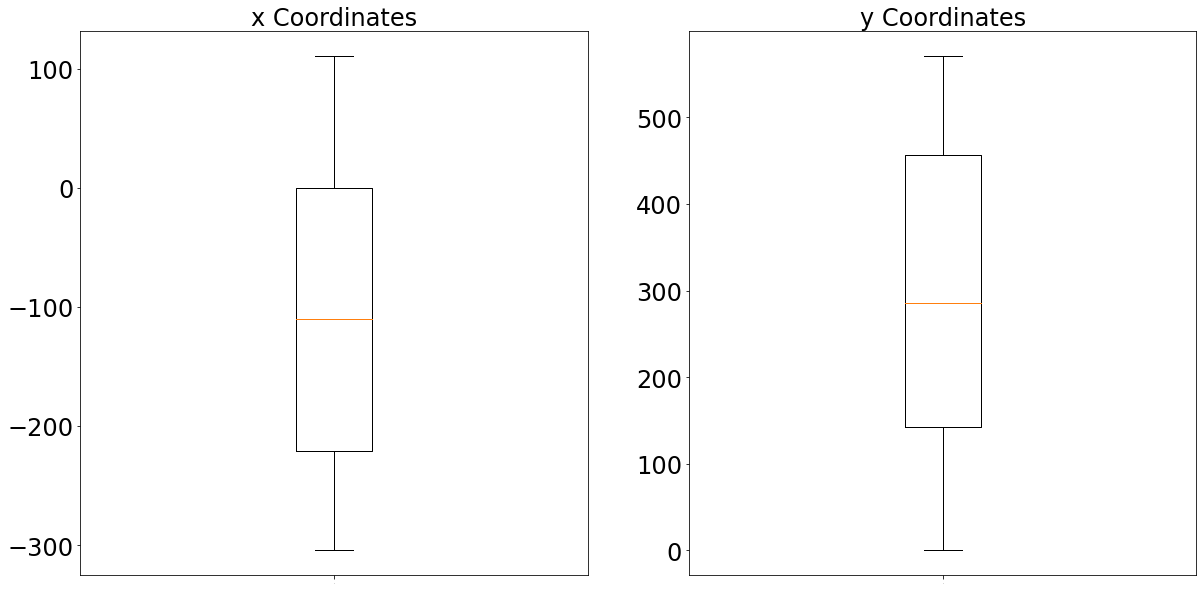

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 2)

ax[0].set_title('x Coordinates', fontsize = 24)
ax[0].yaxis.set_tick_params(labelsize = 24)
ax[0].xaxis.set_tick_params(labelsize = 0)
ax[0].boxplot(xs)

ax[1].set_title('y Coordinates', fontsize = 24)
ax[1].yaxis.set_tick_params(labelsize = 24)
ax[1].xaxis.set_tick_params(labelsize = 0)
ax[1].boxplot(ys)

In [12]:
x_coords_np = np.array(xs)
x_q3, x_q1 = np.percentile(x_coords_np, [75,25])
x_iqr = x_q3 - x_q1
print(f'X interquartile range: {x_iqr}')

y_coords_np = np.array(ys)
y_q3, y_q1 = np.percentile(y_coords_np, [75,25])
y_iqr = y_q3 - y_q1
print(f'y interquartile range: {y_iqr}')

X interquartile range: 221.27147706231037
y interquartile range: 314.1111111111015


### Read in dataset - Signal Measurements Fingerprints

In [13]:
# Collect radio frequency measurements for each of the reference point and reformat it as 2D array
# Array structure:[[RSSI-1, TDoA-1], [RSSI-2, TDoA-2], ... , [RSSI-N,TDoA-N]] where N is the number of
# repeated samples taken at each reference point

# Read in each of the base station's data first
bs_137410 = np.loadtxt('cor137410.txt')
bs_143850 = np.loadtxt('cor143850.txt')
bs_144680 = np.loadtxt('cor144680.txt')
bs_734777 = np.loadtxt('cor734777.txt')
bs_734817 = np.loadtxt('cor734817.txt')
bs_748823 = np.loadtxt('cor748823.txt')
bs_749197 = np.loadtxt('cor749197.txt')

basestations = [bs_137410, bs_143850, bs_144680, bs_734777, bs_734817, bs_748823, bs_749197]

# Constants
num_rps = 277
num_samples = 100
num_bs = 7
num_featuresperbs = 2

# (277,100,14)
fp_array = np.zeros((277,100,14), dtype = np.float64)

for i in range(num_rps):
    
    cur_rp_measurements = []
    
    for j in range(num_bs):
        
        cur_bs = basestations[j]
        cur_rp_bs_measurements = cur_bs[i::num_rps]       
        
        rssi_samples, tdoa_samples = cur_rp_bs_measurements[:,0], cur_rp_bs_measurements[:,1]
        cur_rp_measurements.append(rssi_samples)
        cur_rp_measurements.append(tdoa_samples)
        
    cur_rp_measurements = np.array(cur_rp_measurements)
    cur_rp_measurements = cur_rp_measurements.T

    fp_array[i] = cur_rp_measurements

print(fp_array.shape)

(277, 100, 14)


In [12]:
print(os.getcwd())
# os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/datasets/ntu_dataset


In [373]:
# Save the fingerprints for each coordinate as a numpy array
np.save('miso_snr40_raw_features.npy', fp_array)

# Save the coordinates as a numpy array too
x_coords = rp_df['rp_x'].to_numpy()
y_coords= rp_df['rp_y'].to_numpy()
miso_snr40_labels = np.zeros((len(x_coords), 2), dtype = np.float32)

for i in range(len(x_coords)):
    miso_snr40_labels[i][0] = x_coords[i]
    miso_snr40_labels[i][1] = y_coords[i]

print(miso_snr40_labels.shape)    
np.save('miso_snr40_raw_labels.npy', miso_snr40_labels)

(277, 2)


## Step 2: Generate virtual RPs
- Split into train and test dataset
- Generate virtual RPs for RPs in train dataset

### Shuffle dataset

In [14]:
# rp_coords stores the coordinate information of each RP --> shape: (277,4)
# fp_array stores the fingerprint sample of each RP --> shape: (277, 100, 14)
# Origin index: 266

# Create a list of features and arrays
num_rps = len(rp_coords)
data_arr = []

for i in range(num_rps):
    
    # (coordinates, features)
    data_arr.append((rp_coords[i], fp_array[i]))


random.seed(42)
random.shuffle(data_arr)

rp_coords = X_train = np.array([data_arr[i][0] for i in range(len(data_arr))], dtype = np.float32)
fp_array = y_train = np.array([data_arr[i][1] for i in range(len(data_arr))], dtype = np.float32)

### Generate virtual RPs for RPs in train dataset

In [15]:
# Function to convert from x,y back to lat,long
import math

def get_lat_lon(origin_lat, origin_lon, x, y):
    # Convert x-y coordinates to latitude and longitude

    # Define the parameters used in the conversion
    R = 6378137  # Earth's radius in meters
    offset = R * math.pi  # Offset to ensure positive y-values

    # Convert x-y coordinates to latitude and longitude
    lat = origin_lat - (y / R) * 180 / math.pi
    lon = origin_lon + (x / (R * math.cos(origin_lat * math.pi / 180))) * 180 / math.pi

    return lat, lon

In [16]:
rp_indexes = [i for i in range(len(X_train))]
rp_lat = X_train[:,0]
rp_long = X_train[:,1]
rp_x = X_train[:,2]
rp_y = X_train[:,3]

X_train_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
X_train_df = pd.DataFrame(data = X_train_data)

In [17]:
# Get maximum and minimum of x and y coordinates
def get_minmax(axis):
    
    if axis == 'x':
        x_coords = X_train[:,2]
        return (np.amin(x_coords), np.amax(x_coords))

    elif axis == 'y':
        y_coords = X_train[:,3]
        return (np.amin(y_coords), np.amax(y_coords))

# Want to generate 100 equidistance intervals on the y-axis, 20 equidistance intervals on the x-axis
def generate_virtualrps(x_num_rps, y_num_rps):
    
    # Get min and max for each axis
    x_min, x_max = get_minmax('x')
    y_min, y_max = get_minmax('y')
    
    # Find out number of virtual RPs generated along each axis
    x_stepsize = (x_max - x_min) / x_num_rps
    y_stepsize = (y_max - y_min) / y_num_rps
    
    # Create a numpy array to store results
    # Shape: (2500,4)
    results = np.zeros((y_num_rps*x_num_rps, 4), dtype = np.float64)
    
    # Generate virtual RPs
    for i in range(0,y_num_rps):
        for j in range(0,x_num_rps):
            
            # Get coordinates for the current virtual RP
            cur_x_coords = x_min + j*x_stepsize
            cur_y_coords = y_min + i*y_stepsize
            
            # Get lat and long for the current coordinates
            cur_lat, cur_lon = get_lat_lon(origin_lat, origin_lon, cur_x_coords, cur_y_coords)
            results[(i*y_num_rps) + j] = (cur_lat, cur_lon, cur_x_coords, cur_y_coords)
    
    return results

In [18]:
virtual_rps = generate_virtualrps(20, 20)
print(virtual_rps.shape)

(400, 4)


In [19]:
# (lat, lon, x_coords, y_coords)
print(virtual_rps)

[[   1.354873    103.68343812 -304.24856567    0.        ]
 [   1.354873    103.68362452 -283.5043457     0.        ]
 [   1.354873    103.68381093 -262.76012573    0.        ]
 ...
 [   1.34999914  103.68660693   48.40317383  542.55552979]
 [   1.34999914  103.68679334   69.1473938   542.55552979]
 [   1.34999914  103.68697974   89.89161377  542.55552979]]


In [20]:
# Concatenate the numpy arrays for actual and generated RPs
actual_rps = np.copy(X_train)

# Add a flag to virtual RPs to indicate that they are virtual
# Add a flag to original RPs to indicate that they are original RPs
actual_rps_flag = np.ones((len(actual_rps),))
virtual_rps_flag = np.zeros((len(virtual_rps),))

actual_rps = np.insert(actual_rps, 4, actual_rps_flag, axis = 1)
virtual_rps = np.insert(virtual_rps, 4, virtual_rps_flag, axis = 1)

# Concatenate arrays
X_train_augmented = np.concatenate((actual_rps, virtual_rps), axis = 0)

print(X_train_augmented.shape)

(677, 5)


In [21]:
print(X_train_augmented)

[[   1.35333097  103.6854248    82.9768219   171.33332825    1.        ]
 [   1.349733    103.68642426  -27.65896034  571.11108398    1.        ]
 [   1.35487294  103.68716431 -110.63572693    0.            1.        ]
 ...
 [   1.34999914  103.68660693   48.40317383  542.55552979    0.        ]
 [   1.34999914  103.68679334   69.1473938   542.55552979    0.        ]
 [   1.34999914  103.68697974   89.89161377  542.55552979    0.        ]]


In [22]:
# Make a pandas dataframe
rp_indexes = [i for i in range(len(X_train_augmented))]
rp_lat = X_train_augmented[:,0]
rp_long = X_train_augmented[:,1]
rp_x = X_train_augmented[:,2]
rp_y = X_train_augmented[:,3]
rp_isactual_flag = X_train_augmented[:,4]

X_train_augmenteddata = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y, 'is_actual': rp_isactual_flag}
X_train_augmented_df = pd.DataFrame(data = X_train_augmenteddata)

X_train_augmented_df.head(10)

rp_index    rp_lat     rp_long        rp_x        rp_y  is_actual
0         0  1.353331  103.685425   82.976822  171.333328        1.0
1         1  1.349733  103.686424  -27.658960  571.111084        1.0
2         2  1.354873  103.687164 -110.635727    0.000000        1.0
3         3  1.353331  103.687912 -193.612579  171.333328        1.0
4         4  1.353331  103.686172    0.000000  171.333328        1.0
5         5  1.354102  103.687164 -110.635742   85.666664        1.0
6         6  1.352046  103.685173  110.635788  314.111115        1.0
7         7  1.349733  103.687668 -165.953766  571.111084        1.0
8         8  1.349733  103.686920  -82.976883  571.111084        1.0
9         9  1.351789  103.688911 -304.248444  342.666656        1.0

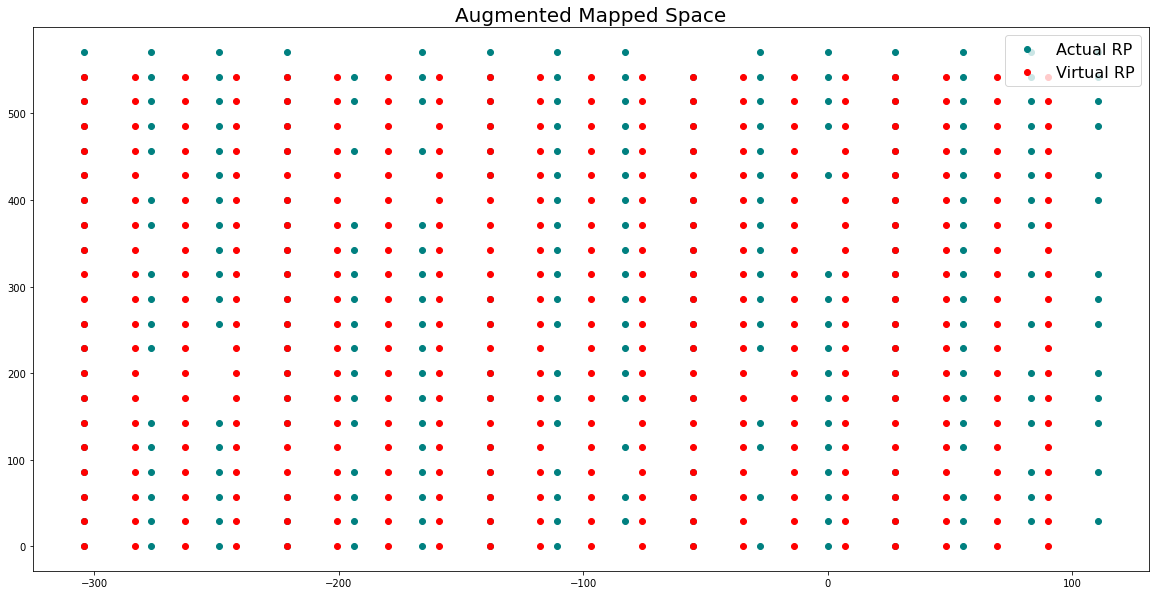

In [23]:
plt.rcParams['figure.figsize'] = [20, 10]

# Subset the actual and non-vritual RPs
actual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
virtual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 0.0]

plt.title('Augmented Mapped Space', fontsize = 20)
plt.scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], color = 'teal', label = 'Actual RP')
plt.scatter(virtual_rps_df['rp_x'], virtual_rps_df['rp_y'], color = 'red', label = 'Virtual RP')
plt.legend(loc = 'upper right', fontsize = 16)

## Step 3: Combine real + virtual RP and make a undirectional, weighted, fully connected graph
- Construct the adjacency matrix, degree matrix then graph laplacian matrix
- In order to determine the features of virtual reference points, virtual reference points should only have edges with actual reference points

In [24]:
# Split up reference points into train, validation and test dataset

# Split up actual dataset into train and validation dataset
X_train_actual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
X_train_virtual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] != 1.0]

actual_rps_indexes = X_train_actual_df['rp_index'].unique()
train_size = round(int(len(actual_rps_indexes)*0.95))
train_rps = actual_rps_indexes[:train_size]
val_rps = actual_rps_indexes[train_size:]

# Virtual RP gets split into validation and test dataset
virtual_rp_indexes = X_train_virtual_df['rp_index'].unique()
test_rps = virtual_rp_indexes

print(train_rps.shape, val_rps.shape, test_rps.shape)
print('---')
print(f'Train RP indexes: {train_rps}')
print('---')
print(f'Validation RP indexes: {val_rps}')
print('---')
print(f'Test RP indexes: {test_rps}')
print('---')

(263,) (14,) (400,)
---
Train RP indexes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 

In [25]:
# Construct the distance matrix G - Shape of (2777, 2777)
ttal_rpcount = len(X_train_augmented_df.index)

# G_matrix: Store distances between points
# M_matrix: Store 1/0, depending on K closest neighbours
# W_matrix: Store adjacency matrix
# D_matrix: Store degree of each vertice
# L_matrix: Store the Graph Laplacian matrix

G_matrix = np.zeros((ttal_rpcount, ttal_rpcount), dtype = np.float64)
M_matrix = np.copy(G_matrix)
W_matrix = np.copy(G_matrix)
D_matrix = np.copy(G_matrix)
L_matrix = np.copy(G_matrix)

#  Determine the number of neighbours to be used in the construction of the graph
# Use K = 100
K = 100

In [26]:
print(os.getcwd())
os.chdir('../../data_augmentation')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/data_augmentation


In [27]:
# To load back the matrices if it already has been created
try:
    W_matrix = np.load('graphsage_adjmatrix_k100.npy')
    D_matrix = np.load('graphsage_dmatrix_k100.npy')
    L_matrix = np.load('graphsage_lmatrix_k100.npy')
    
except OSError as e:
    print("Have not saved adjacency matrix")

In [646]:
# Function to get Euclidean Distance
import math

def get_euclidean_distance(coords1, coords2):

    temp = coords2 - coords1
    sum_square = np.dot(temp.T, temp)
    return np.sqrt(sum_square)

# Create G_matrix
# Find out euclidean distance for each pair of points and update distance matrix (G_matrix)
for i in range(ttal_rpcount):
    
    coords1 = np.array((X_train_augmented_df.iloc[i]['rp_x'], X_train_augmented_df.iloc[i]['rp_y']), dtype = np.float64)
        
    for j in range(ttal_rpcount):
        
        # Prevent the node from having the closest distance to itself
        # Prevent self loops
        if j == i:
            G_matrix[i][j] = math.inf
        
        # Prevent test nodes from having edges with other test nodes
        elif i in test_rps and j in test_rps:
            G_matrix[i][j] = math.inf
            
        else:
            coords2 = np.array((X_train_augmented_df.iloc[j]['rp_x'], X_train_augmented_df.iloc[j]['rp_y']), dtype = np.float64)
            euclidean_distance = get_euclidean_distance(coords1, coords2)
            G_matrix[i][j] = euclidean_distance

In [647]:
# Create M_matrix
for i in range(ttal_rpcount):
    
    dists = G_matrix[i]
    k_nearest_indexes = np.argsort(dists)[:K]
    
    for idx in k_nearest_indexes:
        M_matrix[i][idx] = 1

In [648]:
# Create W_matrix
for i in range(ttal_rpcount):
    for j in range(ttal_rpcount):
        
        # Prevent self-loops
        if M_matrix[i][j] == 1:
            if G_matrix[i][j] == 0:
                W_matrix[i][j] = 1e5
                
            else:
                W_matrix[i][j] = M_matrix[i][j] / (G_matrix[i][j] ** 2)

In [649]:
# Create D_matrix
for i in range(ttal_rpcount):
    
    # Count the number of edges
    vertex_degree = np.count_nonzero(W_matrix[i])
    
    # Assign count to diagonal of matrix
    D_matrix[i][i] = vertex_degree

In [650]:
# Create L_matrix
L_matrix = D_matrix - W_matrix

In [28]:
print(W_matrix)
print('-------')
print(D_matrix)
print('-------')
print(L_matrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.51495229e-04
  9.81653883e-05 6.83360846e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.51495229e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.81653883e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.83360846e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
-------
[[100.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 [  0.   0. 100. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.   0.   0.]
 [  0.   0.   0. ...   0. 100.   0.]
 [  0.   0.   0. ...   0.   0. 100.]]
-------
[[ 1.00000000e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+02  0.00000000e+00 .

In [736]:
# Save adjacency matrix
np.save('graphsage_adjmatrix_k100.npy', W_matrix)
np.save('graphsage_dmatrix_k100.npy', D_matrix)
np.save('graphsage_lmatrix_k100.npy', L_matrix)

## Step 4: Generate mini batches of graph (Subset a set of edges)

In [29]:
# PLaceholder to store values for selected constants
# May need to change content later

def construct_placeholders():
    
    # Define placeholders
    # tf.placeholder is deprecated, try to use tf.Variable as an alternative
    
    placeholders = {
        'batch1': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='batch1', trainable = False),
        'batch2': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='batch2', trainable = False),
        'neg_samples': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='neg_sample_size', trainable = False),
        'dropout': tf.Variable(initial_value=0.0, shape=(), name='dropout', trainable = False),
        'batch_size': tf.Variable(initial_value=0, dtype=tf.int32, name='batch_size', trainable = False)
    }
    
    return placeholders

### Setup Documentation:

- Nodes are labelled with either train, validation or test
    - 249 nodes with known representations (236 in training, 13 in validation)
    - 2500 nodes with unknown representations (2500 in test)    
<br/>
- Edges are labelled with either train_removed or nothing
    - For all edges involving either a validation or test node, the edge will be labelled with 'train_removed'
    - Else, it is not labelled with anything

### Functional Documentation:

- **__init__()**: Initialise the iterator object
- **_remove_isolated()**: Remove nodes that are not part of graph or do not have edge to any other nodes
- **construct_adj()**: Construct adjacency matrix and degree matrix for training nodes
- **construct_test_adj()**: Consturct adjacency matrix for testing purposes. Similar to construct_adj() but do not discern whether node is a training or test/validation node
- **end()**: Boolean check if all batches have been processed
- **num_training_batches()**: Determine the number of training batches
- **batch_feed_dict()**: Load a current batch of edges into a dictionary
- **next_minibatch_feed_dict()**: Feed in the next minibatch into a dictionary
- **val_feed_dict()**: Feed in the next validation batch into a dictionary
- **incremental_val_feed_dict()**: Allows for incremental evaluation and processing of the validation set in smaller chunks or batches.
- **incremental_embed_feed_dict()**: Allows for incremental computation of node embeddings in smaller chunks or batches.
- **label_val()**: Get arrays for train edges and validation edges
- **shuffle()**: Shuffle the nodes and edges. Also reset the batch number

In [30]:
# Generate mini batches of the graph
# Set a random set so that results will be reproducible everytime
np.random.seed(42)

class EdgeMinibatchIterator(object):
    
    def __init__(self, G, nodeid_dict, nodetype_dict, placeholders, context_pairs = None, batch_size = 50, max_degree = 25,
                n2v_retrain = False, fixed_n2v = False, **kwargs):
        
        """ 
        This minibatch iterator iterates over batches of sampled edges or random pairs of co-occuring edges.
        G -- networkx graph
        nodeid_dict -- dict mapping node ids to index in feature tensor
        placeholders -- tensorflow placeholders object
        context_pairs -- if not none, then a list of co-occuring node pairs (from random walks)
        batch_size -- size of the minibatches
        max_degree -- maximum size of the downsampled adjacency lists
        """

        self.G = G
        self.nodeid_dict = nodeid_dict
        self.nodetype_dict = nodetype_dict
        self.placeholders = placeholders
        self.batch_size = batch_size
        self.max_degree = max_degree
        self.batch_num = 0
        
        # Old: Shuffle the orders of the nodes
        # self.nodes = np.random.permutation(G.nodes())
        self.nodes = G.nodes()
        
        for edge in self.G.edges():
            # Nodes that belong to val or test set are considered 'train_removed'
            if (self.get_node_type(edge[0]) == 'test' or self.get_node_type(edge[1]) == 'test'):
                self.G[edge[0]][edge[1]]['train_removed'] = True
            else:
                self.G[edge[0]][edge[1]]['train_removed'] = False

        # Left to do: A function that helps differentiates between training and test nodes
        # self.adj is a 2 dimensional adjacency matrix for nodes used in training
        # self.deg is a 1 dimensional vector that contains the degree for each node used in training
        self.adj, self.deg = self.construct_adj()

        # Get the adjacency matrix for nodes used in test
        self.test_adj = self.construct_test_adj()
        
        # A node-context pair refers to a combination of a central node
        # in a graph and one of its neighboring nodes or context nodes.
        if context_pairs is None:
            edges = self.G.edges()
        else:
            edges = context_pairs
        
        '''
        Old way:
        self.train_edges = self.edges = np.random.permutation(edges)
        self.train_edges = self._remove_isolated(self.train_edges)
        self.val_edges = [e for e in self.G.edges() if self.G[e[0]][e[1]]['train_removed']]
        '''
        
        # Get train edges
        self.train_edges = self.edges = edges
        self.train_edges = self._remove_isolated(self.train_edges)
        
        # Get validation edges
        val_edges = []
        for edge in self.edges:
            
            # Only consider edges where either node is a validation node and
            # no nodes in the edge is a test node
            if (self.get_node_type(edge[0]) != 'test' and self.get_node_type(edge[1]) != 'test') and \
            (self.get_node_type(edge[0]) == 'val' or self.get_node_type(edge[1]) == 'val'):
                val_edges.append(edge)            
        self.val_edges = val_edges
            
        # TODO: Get train and test edges
        # To start generating embedding for new nodes
        
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'train']), 'train nodes')
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'val']), 'val nodes')
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'test']), 'test nodes')
        self.val_set_size = len(self.val_edges)
     
    def get_node_type(self, node):
        return self.nodetype_dict[self.G.nodes[node]['node_type']]
    
    def _remove_isolated(self, edge_list):
        
        new_edge_list = []
        missing = 0
        
        for node1, node2 in edge_list:
            
            # Flag out any missing nodes that are not present
            if not node1 in self.G.nodes or not node2 in self.G.nodes:
                missing += 1
                continue
                
            # For any training nodes that have no edges with any other nodes,
            if (self.deg[self.nodeid_dict[node1]] == 0 or self.deg[self.nodeid_dict[node2]] == 0) \
                or (self.get_node_type(node1) == 'test' or self.get_node_type(node1) == 'val') \
                or (self.get_node_type(node2) == 'test' or self.get_node_type(node2) == 'val'):
                continue
            
            else:
                new_edge_list.append((node1, node2))
        
        print("Unexpected missing:", missing)
        return new_edge_list
     
    # This function creates the adjacency matrix and degree matrix for nodes to be used in training
    # Should include training and validation nodes
    def construct_adj(self):

        # Have to use adjacency matrix specified in original code so as to be
        # in sync with the max_degree criteria
        train_val_nodes = []
        for node_idx in self.G.nodes():
            
            # Only process training nodes
            if self.get_node_type(node_idx) == 'test':
                continue
            
            train_val_nodes.append(node_idx)
        
        adj = len(train_val_nodes)*np.ones((len(train_val_nodes), self.max_degree))
        deg = np.zeros((len(self.nodeid_dict), ), dtype = np.int64)
        
        for node_idx in train_val_nodes:
            
            # Only consider neighbours which are part of training dataset
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_idx) \
                        if (not self.G[node_idx][neighbour]['train_removed'])])
            deg[self.nodeid_dict[node_idx]] = len(neighbours)
            
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
            
            # Ensure that every node has number of neighbours equal to max degree by random sampling
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_idx], :] = neighbours
            
        return adj, deg
    
    # This function is to create an adjacency matrix used for testing the GraphSAGE model
    # This adjacency matrix will contain all nodes and for all edges, both nodes cannot be a
    # test node
    def construct_test_adj(self):

        adj = len(self.nodeid_dict)*np.ones((len(self.nodeid_dict), self.max_degree))
        deg = np.zeros((len(self.nodeid_dict), ), dtype = np.int64)
        
        for node_idx in self.G.nodes():
    
            # Only consider neighbours which have known feature representations
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_idx) \
                        if (not self.get_node_type(neighbour) == 'test')])
            deg[self.nodeid_dict[node_idx]] = len(neighbours)
            
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
                
            # Ensure that every node has number of neighbours equal to max degree by random sampling
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)            
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_idx], :] = neighbours
        
        return adj, deg
    
    # Returns a boolean on whether all batches have been successfully run through
    def end(self):
        return self.batch_size * self.batch_num >= len(self.train_edges)
    
    # Determine number of training batches
    def num_training_batches(self):
        # + 1 so will iterate till the last batch
        return (len(self.train_edges) // self.batch_size) + 1
    
    # Pass in current batch and store in a dictionary
    # This dict will be passed into the the model to be used
    def batch_feed_dict(self, batch_edges):
        batch1 = []
        batch2 = []
        
        for node1, node2 in batch_edges:
            batch1.append(self.nodeid_dict[node1])
            batch2.append(self.nodeid_dict[node2])
        
        feed_dict = {}
        feed_dict['batch_size'] = tf.constant(value=len(batch_edges), dtype=tf.int32, shape=(None), name='batch_size')
        feed_dict['batch1'] = tf.constant(value=batch1, dtype=tf.int32, shape=(None), name='batch1')
        feed_dict['batch2'] = tf.constant(value=batch2, dtype=tf.int32, shape=(None), name='batch2')
        
        return feed_dict
    
    # Pass in the next batch of edges amd update dicionary with it
    def next_minibatch_feed_dict(self):
        
        # Determine the start index
        start_index = self.batch_num*self.batch_size
        
        # Increment batch number
        self.batch_num += 1
        
        # Determine the end index - Minimum of last index and current batch num * batch size
        end_index = min(self.batch_num*self.batch_size, len(self.train_edges)) 
        
        # Slice the array of batch_edges to get the current sample
        curbatch_edges = self.train_edges[start_index: end_index]
        
        # Feed the batches into function to generate batch dictionary
        curbatch_feed_dict = self.batch_feed_dict(curbatch_edges)
        
        # Return the batch dictionary
        return curbatch_feed_dict
    
    # Feed in validation edges and store in a dictionary
    # size is the desired size of the validation set
    def val_feed_dict(self, size = None):
        
        edge_list = self.val_edges
        # If no size was specified, return all validation edges
        if size == None:
            return self.batch_feed_dict(edge_list)
        
        # Else, permutate val edges and return the desired subset size
        else:
            ind = np.random.permutation(len(edge_list))
            ind = ind[:size]
            val_edges = [edge_list[num] for num in ind]
            return self.batch_feed_dict(val_edges)
            
    # Allows for incremental evaluation and processing of the validation set in smaller chunks or batches.
    # size refers to batch size for each validation batch
    # iter_num refers to the current batch number
    def incremental_val_feed_dict(self, size, iter_num):
        
        edge_list = self.val_edges
        
        # Subset validaiton edge list to get back desired list of edges
        val_edges = edge_list[(size*iter_num): min((iter_num + 1)*size, len(edge_list))]
        
        # Returns current batch of validation edges, boolean on whether all batches processed, all validation edges
        return self.batch_feed_dict(val_edges), (iter_num + 1)*size >= len(self.val_edges), val_edges
            
    # Allows for incremental computation of node embeddings in smaller chunks or batches.
    # size refers to batch size for each validation batch
    # iter_num refers to the current batch number
    def incremental_embed_feed_dict(self, size, iter_num):
        
        node_list = self.G.nodes()
        
        # Get current batch of nodes
        val_nodes = node_list[(size*iter_num): min((iter_num + 1)*size, len(node_list))]
        val_edges = [(n,n) for n in val_nodes]
        return self.batch_feed_dict(val_edges), (iter_num + 1)*size >= len(node_list), val_edges
        
    # Label which edges are train edges, which edges are validation edges
    def label_val(self):
        
        train_edges = []
        val_edges = []
        
        for node1, node2 in self.G.edges():
            
            if (self.get_node_type(node1) == 'test' or self.get_node_type(node1) == 'val') or \
            (self.get_node_type(node2) == 'test' or self.get_node_type(node2) == 'val'):
                val_edges.append(node1, node2)
            else:
                train_edges.append(node1, node2)
                
        return train_edges, val_edges
    
    # Shuffles nodes and edges and reset batch number to repeat process
    def shuffle(self):
        """ 
        Re-shuffle the training set.
        Also reset the batch number.
        """
        
        self.train_edges = np.random.permutation(self.train_edges)
        self.nodes = np.random.permutation(self.nodes)
        self.batch_num = 0

(263,) (14,) (400,)


2023-08-14 00:52:13.737718: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 00:52:14.564640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43428 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6


Unexpected missing: 0
263 train nodes
14 val nodes
400 test nodes


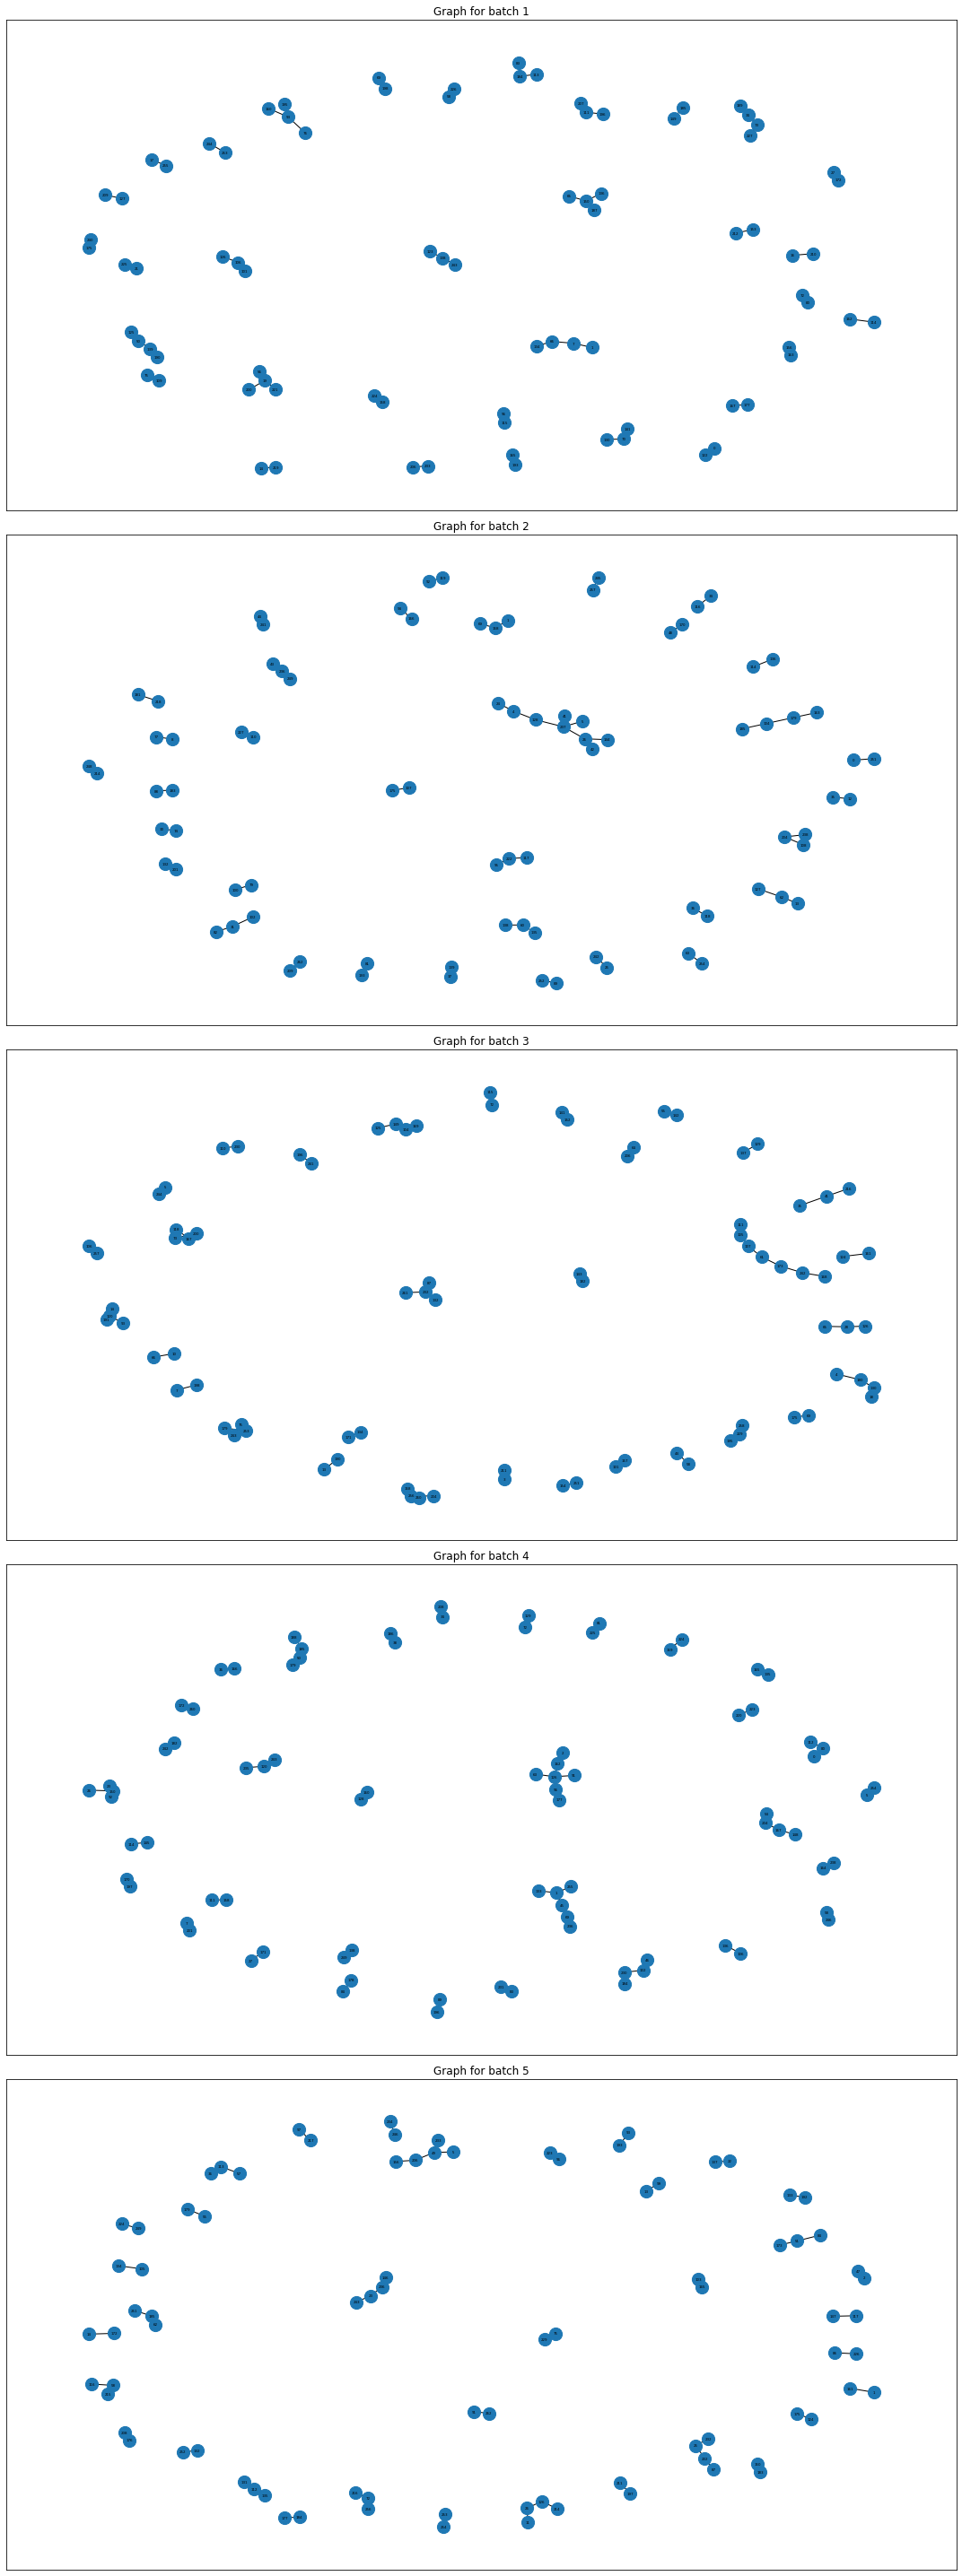

In [31]:
# Create graph needed for model
model_graph = nx.Graph()
num_vertices = len(W_matrix)

# Create the complete graph
for i in range(num_vertices):
    for j in range(num_vertices):
        
        if W_matrix[i][j] != 0:
            model_graph.add_edge(i, j, weight = W_matrix[i][j])

print(train_rps.shape, val_rps.shape, test_rps.shape)

# Mark the vertices in the graph on whether they are train, validation or test
# node_type = 1 for training, 0 for validation and -1 for test
for node_idx in model_graph.nodes():
    
    if node_idx in train_rps:
        model_graph.nodes[node_idx]['train'] = True
        model_graph.nodes[node_idx]['node_type'] = 1
    
    elif node_idx in val_rps:
        model_graph.nodes[node_idx]['val'] = True
        model_graph.nodes[node_idx]['node_type'] = 0
        
    else:
        model_graph.nodes[node_idx]['test'] = True
        model_graph.nodes[node_idx]['node_type'] = -1

# Generate node mapping dictionary
rp_mapped_dict = {}
rp_indexes = X_train_augmented_df['rp_index']
for i,v in enumerate(rp_indexes):
    rp_mapped_dict[i] = i
    
# Instantiate EdgeMinibatchIterator object
placeholders = construct_placeholders()
nodetype_dict = {1: 'train',
                 0: 'val',
                 -1: 'test'}

minibatch = EdgeMinibatchIterator(model_graph, rp_mapped_dict, nodetype_dict, 
                                 placeholders, max_degree = 50, num_neg_samples = 20)

# Plot out the graph for each batch and observe
minibatch.shuffle()

# Iterate through the mini batches and observe the graphs
# Plot first ten batches
num_rows = 5
fig, axs = plt.subplots(num_rows, 1, figsize = (15,40))

for i in range(num_rows):

    ax = axs[i]    
    feed_dict = minibatch.next_minibatch_feed_dict()
    batch1 = feed_dict['batch1'].numpy()
    batch2 = feed_dict['batch2'].numpy()

    curbatch_graph = nx.Graph()

    for j in range(len(batch1)):
        curbatch_graph.add_edge(batch1[j], batch2[j])

    nx.draw_networkx(curbatch_graph, ax = ax, node_size = 200, font_size = 4)
    ax.set_title(f'Graph for batch {i + 1}')

plt.tight_layout()
plt.show()

## Step 5: Create custom layers inherited from keras.layers.Layer

In [32]:
from tensorflow import keras
from keras import Model
from keras.layers import Layer
import time

In [33]:
# Helper function, to assign unique layer ids
LAYER_UIDS = {}

def get_layer_uid(layer_name = ''):
    
    if layer_name not in LAYER_UIDS:
        LAYER_UIDS[layer_name] = 1
        return 1
    
    else:
        LAYER_UIDS[layer_name] += 1
        return LAYER_UIDS[layer_name]

In [34]:
# Helper functions, to initialise weights in hidden layers

# Uniform initialiser
def uniform(shape, scale = 0.05, name = None):
    initial = tf.random_uniform(shape, minval = -scale, maxval = scale, dtype = tf.float32)
    return tf.Variable(initial, name = name)

# Glorot initialiser
def glorot(shape, name = None):
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)

# Zero initialiser
def zeros(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

# Ones initialiser
def ones(shape, name=None):
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [256]:
'''BaseLayer - Inherit from keras.layers.Layer to implement sampling and aggregation layer'''
class BaseLayer(Layer):
    
    # Initialise layer
    def __init__(self, num_outputs, **kwargs):
        
        super(BaseLayer, self).__init__()
        self.num_outputs = num_outputs
        
        '''
        allowed_kwargs = {'name', 'logging', 'model_size'}
        
        # Prevent any unallowed kwargs
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument' + kwarg
        
        layer_name = kwargs.get('name')
        if not layer_name:
            layer_name = self.__class__.name__.lower()
            name = layer_name + '_' + str(get_layer_uid(layer_name))
        
        self.name = name
        '''
        
        self.logging = kwargs.get('logging', False)
        self.sparse_inputs = False
    
    # Writing function for build is optional, do not have to write it here and can leave it to subclasses to define their own build
    
    # Function to be inherited by subclasses (Run input through layer to get output)
    def _call(self, inputs):
        return inputs
    
    # Wrapper for _call
    def call(self, inputs):
        
        if self.logging and not self.sparse_inputs:
            # tf.summary.histogram(<logging directory>, <items to be logged>)
            tf.summary.histogram(self.name + '/inputs', inputs)

        outputs = self._call(inputs)

        if self.logging:
            tf.summary.histogram(self.name + '/outputs', outputs)

        return outputs
    
'''Sampling layer'''
class UniformNeighbourSampler(BaseLayer):
    
    # Initialise layer
    def __init__(self, num_outputs, **kwargs):
        
        super(UniformNeighbourSampler, self).__init__(num_outputs, **kwargs)
            
    '''Sample by taking the num_samples nearest neighbours'''
    def _call(self, inputs):
        
        adj_info, ids, num_samples, graph = inputs
        # Get all neighbours for base nodes in this sample
        adj_lists = tf.nn.embedding_lookup(adj_info, np.asarray(ids, dtype = np.int32))
        # To store results
        sorted_adj_lists = np.zeros((len(ids), num_samples), dtype = np.int32)
       
        # Convert to numpy arrays
        base_idxs_np = ids.numpy()
        neigh_idxs_np = adj_lists.numpy()

        # For each of the base nodes,
        for i in range(len(adj_lists)):
            
            edges = []
            # Get the current base nodes and the neighbours
            base_idx = base_idxs_np[i]
            neigh_idxs = neigh_idxs_np[i]
            
            # Go through each of the neighbours for the current base node
            for j in range(len(neigh_idxs)):
                
                # Get current neighbour node
                cur_neigh_idx = neigh_idxs[j]
                
                # Get the edge weight for each of these pairs                
                # if an edge exist between the two nodes,
                edge_weight = graph[base_idx][cur_neigh_idx]['weight']
                # Append to list
                edges.append((base_idx, cur_neigh_idx, edge_weight))

                    
            # Sort edges
            edges.sort(key = lambda x: x[2])

            # Select the num_sample nearest neighbours
            nearest_neighs = edges[:num_samples]

            # Save the nearest_neighs into numpy aray that would be returned
            sampled_neighs = np.array([edge[1] for edge in nearest_neighs], dtype = np.int32)
            sorted_adj_lists[i] = sampled_neighs
                         
        return sorted_adj_lists
    
'''Aggregation layer'''
class MeanAggregator(BaseLayer):

    def __init__(self, num_outputs, dropout = 0, bias = False, 
                 name = None, concat = False, **kwargs):
        
        super(MeanAggregator, self).__init__(num_outputs, **kwargs)
        
        # Initialise known attributes at initialisation
        self.dropout = dropout
        self.concat = concat
        self.bias = bias
        self.initialised = False
        
    def build(self, input_shape):
        
        if not self.initialised:

            # Input is the neighbour nodes and their features
            input_dim = input_shape[1][2]
            neigh_input_dim = input_shape[1][2]
            input_batchsize = input_shape[1][0]

            # Output is the base nodes we are trying to learn the features off
            output_dim = input_shape[0][1]    

            # Initialise weights
    
            # self.neigh_weights = tf.Variable(name = 'neigh_weights',
            #                                 initial_value = tf.initializers.GlorotUniform()(shape=(input_dim, output_dim)),
            #                                 trainable = True)
            
            neigh_weights_initialiser = tf.keras.initializers.GlorotUniform()            
            self.neigh_weights = self.add_weight(name = 'neigh_weights', shape = (neigh_input_dim, output_dim),
                                                 initializer = neigh_weights_initialiser, trainable = True)

            # self.self_weights = tf.Variable(name = 'self_weights',
            #                                initial_value = tf.initializers.GlorotUniform()(shape=(input_dim, output_dim)),
            #                                trainable = True)
            
            self_weights_initialiser = tf.keras.initializers.GlorotUniform()
            self.self_weights = self.add_weight(name = 'self_weights', shape = (input_dim, output_dim),
                                                initializer = self_weights_initialiser, trainable = True)

            # Initialise bias
            if self.bias:
                self.bias_vals = tf.Variable(name = 'bias', initial_value = tf.zeros((output_dim), dtype = tf.float32), trainable = True)
        
    def _call(self, inputs):

        # Feature representation for base nodes, feature representation for neighbour nodes
        self_vecs, neigh_vecs = inputs
     
        # Perform dropout
        neigh_vecs = tf.nn.dropout(neigh_vecs, self.dropout)
        self_vecs = tf.nn.dropout(self_vecs, self.dropout)
        
        neigh_means = tf.reduce_mean(neigh_vecs, axis = 1)
        
        from_neighs = tf.matmul(neigh_means, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_neighs, from_self])
        else:
            output = tf.concat([from_self, from_neighs], axis = 1)
        
        if self.bias:
            output += self.bias_vals
        
        return output
    
        '''
        input_batchsize = self_vecs.shape[0] # 50
        output_dim = self_vecs.shape[1] # 14
       
        # Array to store output
        output_np = np.zeros(shape = (input_batchsize, output_dim), dtype = np.float32)

        # Aggregate for each base node in batch
        for i in range(len(self_vecs)):
            
            # shape: (14,)
            cur_node_features = self_vecs[i]

            # shape: (5,14)
            neigh_nodes_features = neigh_vecs[i]
  
            
            # Aggregate features of neighbours by taking the mean
            # shape: (14,)
            neigh_nodes_mean = tf.reduce_mean(neigh_nodes_features, axis = 0)

            # Expand dims to perform matmul operation
            # shape: (14, 1)
            neigh_nodes_mean = tf.expand_dims(neigh_nodes_mean, axis = 1)
            cur_node_features = tf.expand_dims(cur_node_features, axis = 1)
            
            # shape: (14, 1)
            from_neighs = tf.matmul(self.neigh_weights, neigh_nodes_mean)
            from_self = tf.matmul(self.self_weights, cur_node_features)
            
            output = None
            # Element wise addition if not concatenating else concate
            if not self.concat:
                # output shape: (14,1)
                output = tf.add_n([from_neighs, from_self])
            else:
                output = tf.concat([from_neighs, from_self], axis = 1)
            
            # Reduce dimensions to add with bias
            # shape: (14,)
            output = tf.squeeze(output)

            # Add bias, depending on self.bias
            if self.bias:
                output += self.bias_vals
            
            # output_np[i] shape: (14,)
            # output shape: (14,)
            output_np[i] = output
    
        final_output = tf.convert_to_tensor(output_np, np.float32)
        return final_output
        '''
        
'''Link Prediction layer'''
class BipartiteEdgePredLayer(BaseLayer):
    
    # Initialise layer
    def __init__(self, input_dim1, input_dim2, num_outputs, dropout = 0.,
                 act = tf.nn.sigmoid, loss_fn = 'xent', neg_sample_weights = 1.0,
                 bias = False, bilinear_weights = False, **kwargs):
        
        # num_outputs = 1 (Outputs a likelihood term)
        super(BipartiteEdgePredLayer, self).__init__(num_outputs, **kwargs)

        # Initialise known attributes at initialisation
        self.act = act
        self.bias = bias
        self.eps = 1e-7  
        self.neg_sample_weights = neg_sample_weights
        self.bilinear_weights = bilinear_weights
        self.dropout = dropout
        
        # Margin for hinge loss
        self.margin = 0.1
        
        # num_outputs = 1 (Outputs a likelihood term)
        self.output_dim = 1
        
        self.initialised = False
        
        if not self.initialised:
            # Initialise weights and bias
            if self.bilinear_weights:
                weights_initialiser = tf.keras.initializers.GlorotNormal()
                self._weights = self.add_weight(name = 'bipartite_weights', shape = (input_dim1, input_dim2),
                                              dtype = tf.float32, initializer = weights_initialiser,
                                              trainable = True)
            if self.bias:
                self.bias_vals = tf.Variable(name = 'bipartite_bias',
                                             initial_value = tf.zeros((input_dim2), dtype = tf.float32),
                                             trainable = True)
            
        # Determine loss function
        if loss_fn == 'xent':
            self.loss_fn = self._xent_loss
        elif loss_fn == 'skipgram':
            self.loss_fn = self._skipgram_loss
        elif loss_fn == 'hinge':
            self.loss_fn = self._hinge_loss
    
    '''Affinity score between batch of inputs1 and inputs2.'''
    def affinity(self, inputs1, inputs2):  
    
        if self.bilinear_weights:
            prod = tf.matmul(inputs2, tf.transpose(self._weights))
            self.prod = prod
            aff = tf.reduce_sum(inputs1 * prod, axis = 1)
            
        else:
            aff = tf.reduce_sum(inputs1 * inputs2, axis = 1)
        
        return aff
    
    '''For each input in batch, compute the sum of its affinity to negative samples.'''
    def neg_cost(self, inputs1, neg_samples, hard_neg_samples = None):
        
        if self.bilinear_weights:
            inputs1 = tf.matmul(inputs1, self._weights)
        neg_aff = tf.matmul(inputs1, tf.transpose(neg_samples))
        return neg_aff

        
    
    def loss(self, inputs1, inputs2, neg_samples):
        return self.loss_fn(inputs1, inputs2, neg_samples)
    
    '''Calculate cross entropy loss'''  
    def _xent_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):

        # Get affinity scores
        # TODO: aff and neg_aff are all 0s thereby causing loss to always be the same
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Get cross entropy score with positive and negative samples
        true_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(aff), logits=aff)
        negative_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(neg_aff), logits=neg_aff)
        
        # Calculate loss
        loss = tf.reduce_sum(true_xent) + self.neg_sample_weights * tf.reduce_sum(negative_xent)
        
        return loss
    
    '''Calculate skipgram loss'''
    def _skipgram_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):
        
        # Get affinity scores
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Calculate loss
        neg_cost = tf.log(tf.reduce_sum(tf.exp(neg_aff), axis=1))
        loss = tf.reduce_sum(aff - neg_cost)
        return loss
    
    '''Calculate hinge loss'''
    def _hinge_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):
                
        # Get affinity scores
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Calculate loss
        diff = tf.nn.relu(tf.subtract(neg_aff, tf.expand_dims(aff, 1) - self.margin), name='diff')
        loss = tf.reduce_sum(diff)
        self.neg_shape = tf.shape(neg_aff)
        return loss
    
    def weights_norm(self):
        return tf.nn.l2_norm(self._weights)

## Step 6: Create SampleAndAggregate (SAGE) model inherited from keras.Model

In [326]:
class GraphSAGE(Model):
    
    def __init__(self, placeholders, features, graph, adj, degrees, layer_infos,
                 model_name, neg_sample_size, concat = True, model_size = 'small',
                 logging = False, learning_rate = 0.0001, params_decay = 0., **kwargs):
        '''
        Args:
            - placeholders: Dictionary storing information about inputs1, inputs2, no. of negative samples,
            dropout rate and batch size
            - features: Numpy array with node features. 
            - adj: Numpy array with adjacency lists
            - degrees: Numpy array with node degrees. 
            - layer_infos: List of SAGEInfo namedtuples that describe the parameters of all 
                   the recursive layers. See SAGEInfo definition below.
            - concat: Whether to concatenate during recursive iterations
            - model_size: One of "small" and "big" (not in use at the moment)
        '''
        
        super(GraphSAGE, self).__init__(**kwargs)

        self.model_name = model_name
        self.logging = logging
        
        # Determine info from placeholder - To be updated at every minibatch iteration instead
        # self.inputs1 = placeholders['batch1']
        # self.inputs2 = placeholders['batch2']
        # self.batch_size = placeholders['batch_size']
        self.neg_sample_size = neg_sample_size
        self.placeholders = placeholders
        
        self.model_size = model_size
        self.features = tf.Variable(tf.constant(features, dtype=tf.float32), trainable = False)
        
        # Determine whether to concat output of layers
        self.concat = concat
        
        # Get input graph
        self.graph = graph
        
        # Determine dims - the initial input dimension for the base nodes
        # and dimensions for each subsequent layer
        # Determine layer info
        self.dims = [0 if features is None else features.shape[1]] # Input dimensions for base node
        self.dims.extend([layer_infos[i].output_dim for i in range(len(layer_infos))])
        self.layer_infos = layer_infos
        
        # Params decays for trainable parameters in aggregator layers
        self.params_decay = params_decay
     
        # Initialise layers in the model
        # This model hops to a maximum depth of 2 and at each depth, sample and aggregate
        # Note: Reuse aggregator each time
        '''Samplers'''
        # num_outputs = 1 
        self.uniform_sampler = UniformNeighbourSampler(1, logging = self.logging) 
  
        '''Aggregators'''
        # input_shape: (neigh_input_dim, input_dim, output_dim)
        # Have one layer for each aggregator
        # num_outputs = 1

        self.layer0_aggregator = MeanAggregator(1, dropout = 0.1, bias = True, concat = self.concat,
                                                logging = self.logging)
        self.layer1_aggregator = MeanAggregator(1, dropout = 0.1, bias = True, concat = self.concat,
                                               logging = self.logging)
        
        '''Link Predictor'''
        # dim_mult = 2 if self.concat else 1
        # self.link_predictor = BipartiteEdgePredLayer(dim_mult*self.dims[-1], dim_mult*self.dims[-1],
        #                                            1, act = tf.nn.sigmoid, bilinear_weights = True,
        #                                            bias = True)
            
        # Determine optimiser
        self.optimiser = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    '''Sample neighbors to be the supportive fields for multi-layer convolutions.'''
    def sample(self, inputs, layer_infos, batch_size = None):
        
        '''
        Args:
            inputs: batch inputs
            batch_size: the number of inputs (different for batch inputs and negative samples).
        '''
        
        # Determine batch size
        if batch_size is None:
            batch_size = self.batch_size
            
        # Create arrays to store sampled inputs and no. of inputs sampled per layer
        
        samples = [inputs]
        sample_size = 1
        sample_sizes = [sample_size]
        
        # Iterate through each layer, starting from the layer furthest away
        for i in range(len(layer_infos)):
            
            # Let j be the index referring to current layer we are sampling at
            j = len(layer_infos) - i - 1
            
            # Run through sampler to get samples
            support_size = layer_infos[j].num_samples
            sampled_adj_list = self.uniform_sampler((self.adj_info, samples[i], support_size, self.graph))
            batch_size = len(samples[i])
            
            # Append results to respective arrays
            # batch_size is number of nodes being sampled
            # support_size is number of neighbours chosen for each sampled node
            samples.append(tf.reshape(sampled_adj_list, [batch_size*support_size,]))
            sample_sizes.append(support_size)
              
        # samples: [base nodes to get representation for, nodes 2 layers away (Layer 2), nodes 1 layer away (Layer 1)]
        return samples, sample_sizes

    '''At each layer, aggregate hidden representations of neighbors to compute the hidden representations 
    at next layer'''
    def aggregate(self, samples, input_features, dims, num_samples, support_sizes, batch_size = None,
                 name = None, concat = False, model_size = 'small'):
       
        """ 
        Args:
            samples: a list of samples of variable hops away for convolving at each layer of the
                network. Length is the number of layers + 1. Each is a vector of node indices.
            input_features: the input features for each sample of various hops away.
            dims: a list of dimensions of the hidden representations from the input layer to the
                final layer. Length is the number of layers + 1.
            num_samples: list of number of samples for each layer.
            support_sizes: the number of nodes to gather information from for each layer.
            batch_size: the number of inputs (different for batch inputs and negative samples).
        Returns:
            The hidden representation at the final layer for all nodes in batch
        """
        
        # Determine batch size
        if batch_size is None:
            batch_size = self.batch_size
            
        # hidden is a list that contains the embeddings or hidden representations of the node samples from each layer.
        # Each element in the hidden list corresponds to a layer, and the shape of each element is determined by the number 
        # of node samples in that layer.
        # hidden: [base nodes to get representation for, nodes 2 layers away (Layer 2), nodes 1 layer away (Layer 1)]
        hidden = [tf.nn.embedding_lookup(input_features, np.asarray(node_samples, dtype = np.int32)) for node_samples in samples]
        
        next_hidden = [None]*2
        
        # Start aggregating by layers
        for layer in range(len(num_samples)):
                                    
            # After determining aggregators, start from hops furthest away until reach back to base parent node
                        
            for hop in range(len(num_samples) - layer):
                
                # Determine dimension multiplier
                dim_mult = 2 if concat and layer != 0 else 1
                
                # Convert batch size from tensor to numpy if needed
                if tf.is_tensor(batch_size):
                    batch_size = batch_size.numpy()
                    
                # Shape: [dims for current layer, dims for neighbour layer, dims of current layer]
                neigh_dims = [batch_size*support_sizes[hop], num_samples[len(num_samples) - hop - 1], dim_mult*dims[layer]]

                # Doing aggregator(input_data) calls .call() and .build() implictly
                if hop == len(num_samples) - 1:
                    aggregated_res = self.layer1_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims)))
                else:
                    # aggregated_res = tf.nn.relu(self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims)))) 
                    # Problem: Matrix multiplication resulting in negative values can lead to loss in information

                    # Solution: Try using sigmoid activation instead
                    # aggregated_res = tf.nn.sigmoid(self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims))))
                    
                    # Solution 2: Try using tanh
                    # aggregated_res = tf.nn.tanh(self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims))))
                    
                    # Solution 3: Try Leaky ReLU
                    #aggregated_res = tf.nn.leaky_relu(self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims))),
                    #                                 alpha = 0.2)
                    
                    # Solution 4: No activation
                    aggregated_res = self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims)))
                    
                    
                next_hidden[hop] = aggregated_res
                
        # Re-assign hidden as new aggregated output
        hidden = next_hidden

        # hidden[0]: node representation of base nodes
        # hidden[1]: node representation of neighbours of base nodes
        return (hidden[0], hidden[1])

    '''Get features of base nodes by aggregating from neighbours, used to train model'''
    def get_outputs(self, samples_input1, support_sizes_input1, samples_input2, support_sizes_input2):
        
        '''
        # Prepare neg_nodes
        labels = tf.reshape(tf.cast(self.inputs2, dtype = tf.int64), [self.batch_size, 1])
        
        # Convert numpy array to list and flatten 2D list to a 1D list
        unigrams = self.degrees.flatten()
        unigrams = list(unigrams)
        
        self.neg_samples, _, _ = tf.nn.fixed_unigram_candidate_sampler(
            true_classes=labels,
            num_true=1,
            num_sampled=self.neg_sample_size,
            unique=False,
            range_max=len(self.degrees),
            distortion=0.75,
            unigrams=unigrams)
            
        neg_samples, neg_support_sizes = self.sample(self.neg_samples, self.layer_infos, self.neg_sample_size)

        neg_outputs = self.aggregate(neg_samples, [self.features], self.dims, num_samples, neg_support_sizes,
                                     batch_size = self.neg_sample_size, concat = self.concat, model_size = self.model_size)
        '''
        
        # Get number of samples
        num_samples = [layer_info.num_samples for layer_info in self.layer_infos]
        
        # Aggregate the samples and get output
        input1_self_outputs, input1_neighs_outputs = self.aggregate(samples_input1, [self.features], self.dims, num_samples,
                                  support_sizes_input1, concat = self.concat, model_size = self.model_size)
        input2_self_outputs, input2_neighs_outputs = self.aggregate(samples_input2, [self.features], self.dims, num_samples,
                                  support_sizes_input2, concat = self.concat, model_size = self.model_size)
                
        # Normalise the outputs
        # input1_outputs = tf.nn.l2_normalize(input1_outputs, 1)
        # input2_outputs = tf.nn.l2_normalize(input2_outputs, 1)
        # neg_outputs = tf.nn.l2_normalize(neg_outputs, 1)

        # return feature representation for batch 1 nodes, " for batch 2 nodes, " for negative output nodes
        return (input1_self_outputs, input1_neighs_outputs, input2_self_outputs, input2_neighs_outputs)
    
    '''Calculate loss of model'''
    def calc_loss(self, outputs):
        
        '''
        input1_outputs, input2_outputs, neg_outputs = outputs

        # Get aggregators
        aggregators = [self.layer0_aggregator, self.layer1_aggregator]
        
        # For each aggregator,
        for aggregator in aggregators:
    
            # Add l2 loss of aggregator's weights
            loss += self.params_decay * tf.nn.l2_loss(aggregator.neigh_weights)
            loss += self.params_decay * tf.nn.l2_loss(aggregator.self_weights)
            
            if aggregator.bias:
                loss += self.params_decay * tf.nn.l2_loss(aggregator.bias_vals)
                
        # Add loss from link prediction
        loss = self.link_predictor.loss(input1_outputs, input2_outputs, neg_outputs)
        
        tf.summary.scalar('loss', loss)
        return loss
        '''
        
        # Get outputs
        samples_input1, input1_self_outputs, input1_neighs_outputs, samples_input2, input2_self_outputs, input2_neighs_outputs = outputs

        # Get the true representation for self and neighs
        input1_self_true = np.array([tf.nn.embedding_lookup([self.features], np.asarray(node_samples, dtype = np.int32)) \
                       for node_samples in self.inputs1], dtype = np.float32)
        input1_neighs_true = np.array([tf.nn.embedding_lookup([self.features], np.asarray(node_samples, dtype = np.int32)) \
                       for node_samples in samples_input1[1]], dtype = np.float32)
        
        # input2_self_true = np.array([tf.nn.embedding_lookup([self.features], np.asarray(node_samples, dtype = np.int32)) \
        #               for node_samples in self.inputs2], dtype = np.float32)
        # input2_neighs_true = np.array([tf.nn.embedding_lookup([self.features], np.asarray(node_samples, dtype = np.int32)) \
        #               for node_samples in samples_input2[1]], dtype = np.float32)
       
        # num_self_samples1 = len(samples_input1[0])
        # num_neigh_samples1 = len(samples_input1[1])

        # Try using only input1 for now
        # MSE
        # return tf.reduce_mean(tf.square(input1_self_true - input1_self_outputs)) + tf.reduce_mean(tf.square(input1_neighs_true - input1_neighs_outputs))
         
        # MAE
        # return tf.reduce_mean(tf.abs(input1_self_true - input1_self_outputs)) + tf.reduce_mean(tf.abs(input1_neighs_true - input1_neighs_outputs))
        
        # Huber Loss
        # Try a smaller delta later (i.e. 0.5)
        delta = 0.25
        
        # One Huber Loss, but with greater weight given to current node representation
        abs_self_diff = tf.abs(input1_self_true - input1_self_outputs)
        quadratic_self = tf.minimum(abs_self_diff, delta)
        linear_self = abs_self_diff - quadratic_self
        huber_loss_self = tf.reduce_mean(0.5 * tf.square(quadratic_self) + delta * linear_self)
        
        abs_neighs_diff = tf.abs(input1_neighs_true - input1_neighs_outputs)
        quadratic_neighs = tf.minimum(abs_neighs_diff, delta)
        linear_neighs = abs_neighs_diff - quadratic_neighs
        huber_loss_neighs = tf.reduce_mean(0.5 * tf.square(quadratic_neighs) + delta * linear_neighs)
        
        return huber_loss_self + huber_loss_neighs

    '''Calculate accuracy of model (MRR - Mean Reciprocal Rank)'''
    def calc_acc(self, outputs):

        input1_outputs, input2_outputs, neg_outputs = outputs
        
        # Calculate affinity between positive samples
        aff = self.link_predictor.affinity(input1_outputs, input2_outputs)
        
        # Calculate affinity between positive and negative samples
        neg_aff = self.link_predictor.neg_cost(input1_outputs, neg_outputs)
        neg_aff = tf.reshape(neg_aff, [self.batch_size, self.neg_sample_size])
        
        # Combine both affinity values
        # shape: (x,) --> (x, 1)
        _aff = tf.expand_dims(aff, axis = 1)
        aff_all = tf.concat([neg_aff, _aff], axis = 1)
        size = tf.shape(aff_all)[1]
        
        # Get indices of ranks and ranks to calculate Mean Reciprocal Rank (MRR)
        _, indices_of_ranks = tf.nn.top_k(aff_all, k = size)
        _, ranks = tf.nn.top_k(-indices_of_ranks, k = size)
        mrr = tf.reduce_mean(tf.divide(1.0, tf.cast(ranks[:, -1] + 1, tf.float32)))
        
        tf.summary.scalar('mrr', mrr)
        return mrr
        
    '''To train the model'''
    def train_model(self, epochs, max_total_steps, validate_every, print_every):
        
        # Instantiate variables
        train_shadow_mrr = None
        val_shadow_mrr = None
        total_steps = 0
        avg_time = 0.0
        
        # Dictionary to store results
        results = {'train_loss': [],
                   'train_mrr': [],
                   'val_loss': [],
                   'val_mrr': []
                  }
        
        # Make edge minibatch iterator
        # Graph should be constructed beforehand, a graph representing all vertices and edges
        # using the complete W_matrix. Then, follow steps taken in step 4
        # May need to pass in graph as a parameter to __init__() function of GraphSAGE model
        
        # Get rp_mapped_dicts
        rp_mapped_dict = {}
        for node_idx in self.graph.nodes():
            rp_mapped_dict[node_idx] = node_idx

        # Get nodetype_dict
        nodetype_dict = {1: 'train',
                 0: 'val',
                 -1: 'test'}
        
        minibatch = EdgeMinibatchIterator(self.graph, rp_mapped_dict, nodetype_dict, 
                                 placeholders, max_degree = 50, num_neg_samples = self.neg_sample_size)
        
        # Adjacency info and degrees should be taken from minibatch
        self.adj_info = minibatch.adj
        self.degrees = minibatch.deg

        # Iterate through epochs
        for epoch_no in range(epochs):

            # Shuffle the minibatch
            minibatch.shuffle()

            batch_iter_no = 0
            # Iterate through all minibatches
            while not minibatch.end():
                
                # Generate inputs to be fed into model
                # Note: next_minibatch_feed_dict() feeds in the next batch of training edges
                train_feed_dict = minibatch.next_minibatch_feed_dict()
                self.inputs1 = train_feed_dict['batch1']
                self.inputs2 = train_feed_dict['batch2']
                self.batch_size = train_feed_dict['batch_size']

                # Start taking note of training time
                start_time = time.time()
                      
                samples_input1, support_sizes_input1 = self.sample(self.inputs1, self.layer_infos)
                samples_input2, support_sizes_input2 = self.sample(self.inputs2, self.layer_infos)

                # persistent = True
                with tf.GradientTape() as tape:

                    # Pass in inputs to model and get outputs
                    input1_self_outputs, input1_neighs_outputs, input2_self_outputs, input2_neighs_outputs = self.get_outputs(samples_input1, support_sizes_input1,
                                                                                samples_input2, support_sizes_input2)

                    # Run model on train inputs to get train_loss, train_mrr 
                    train_loss = self.calc_loss((samples_input1, input1_self_outputs, input1_neighs_outputs,
                    samples_input2, input2_self_outputs, input2_neighs_outputs))
                    train_loss = train_loss / tf.cast(self.batch_size, tf.float32)

                    # train_mrr = self.calc_acc((input1_outputs, input2_outputs, neg_outputs))
                    
                    # Calculate gradient based on train loss and optimise weights and biases
                    # Compute gradients
                    # tape.gradient(<loss>, <list of trainable variables>)
                    gradients = tape.gradient(train_loss, self.trainable_variables,
                                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
                    # print(gradients)
                    clipped_gradients = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else None for grad in gradients]
                    # Apply gradients
                    self.optimiser.apply_gradients(zip(clipped_gradients, self.trainable_variables))

                results['train_loss'].append(train_loss)
                # results['train_mrr'].append(train_mrr)

                # Calculate train_shadow_mrr (To provide a moving average of mrr to better evaluate
                # performance over time)
                #if train_shadow_mrr is None:
                #    train_shadow_mrr = train_mrr   
                #else:
                #    train_shadow_mrr -= (1- 0.99)*(train_shadow_mrr - train_mrr)

                # Note: val_feed_dict() feeds in the next batch of validation edges
                # Run model on validation input every validate_iter iterations to get val_loss and val_mrr
                if batch_iter_no % validate_every == 0:

                    val_feed_dict = minibatch.val_feed_dict(size = 25)
                    self.inputs1 = val_feed_dict['batch1']
                    self.inputs2 = val_feed_dict['batch2']
                    self.batch_size = val_feed_dict['batch_size']
                    
                    samples_input1, support_sizes_input1 = self.sample(self.inputs1, self.layer_infos)
                    samples_input2, support_sizes_input2 = self.sample(self.inputs2, self.layer_infos)

                    input1_self_outputs, input1_neighs_outputs, input2_self_outputs, input2_neighs_outputs = self.get_outputs(samples_input1, support_sizes_input1,
                                                                                samples_input2, support_sizes_input2)
                    val_loss = self.calc_loss((samples_input1, input1_self_outputs, input1_neighs_outputs,
                    samples_input2, input2_self_outputs, input2_neighs_outputs))
                    val_loss = val_loss / tf.cast(self.batch_size, tf.float32)

                    # val_mrr = self.calc_acc((input1_outputs, input2_outputs, neg_outputs))

                    results['val_loss'].append(val_loss)
                    # results['val_mrr'].append(val_mrr)

                    #  Calculate val_shadow_mrr (To provide a moving average of val_mrr to beter evaluate
                    # performance over time)
                    #if val_shadow_mrr is None:
                    #    val_shadow_mrr = val_mrr    
                    #else:
                    #    val_shadow_mrr -= (1- 0.99)*(val_shadow_mrr - val_mrr)

                # Calculate average time taken for each step (aka batch iteration)
                end_time = time.time()
                avg_time = (avg_time * total_steps + end_time - start_time) / (total_steps + 1)

                # Print complete statistics every print_every iteration
                batch_iter_no += 1
                total_steps += 1

                # If max number of steps reached, break
                if total_steps > max_total_steps:
                    break
            
            print(f'End of Epoch {epoch_no + 1}')
            print(f'train_loss: {train_loss:.6f}')
            #print(f'train_mrr: {train_mrr:.6f}')
            #print(f'train_mrr_ema: {train_shadow_mrr:.6f}')
            print(f'val_loss: {val_loss:.6f}')
            #print(f'val_mrr: {val_mrr:.6f}')
            #print(f'val_mrr_ema: {val_shadow_mrr:.6f}')
            print(f'average_time: {avg_time:.6f}')
            # print(f'Aggregator 0 weights: {self.trainable_variables[0]}')
            # print(f'Aggregator 1 weights: {self.trainable_variables[3]}')
                    
            # If max number of steps reached, break
            if total_steps > max_total_steps:
                break
                    
        return results
    
    '''Save weights of the trained model'''
    def save_model(self, var_name):

        model_weights = self.trainable_variables
        aggregator0_neigh_weights = model_weights[0]
        aggregator0_self_weights = model_weights[1]
        aggregator0_bias = model_weights[2]
        
        aggregator1_neigh_weights = model_weights[3]
        aggregator1_self_weights = model_weights[4]
        aggregator1_bias = model_weights[5]
        
        # linkpredictor_weights = model_weights[6]
        # linkpredictor_bias = model_weights[7]

        aggregators_weights = np.array([aggregator0_neigh_weights, aggregator0_self_weights,
                                      aggregator1_neigh_weights, aggregator1_self_weights])
    
        aggregators_biases = np.array([aggregator0_bias, aggregator1_bias])
        
        np.save(f'{var_name}_aggregators_weights.npy', aggregators_weights)
        np.save(f'{var_name}_aggregators_biases.npy', aggregators_biases)
        # np.save(f'{var_name}_linkpredictor_weights.npy', linkpredictor_weights)
        # np.save(f'{var_name}_linkpredictor_bias.npy', linkpredictor_bias)
        
    '''Load in weights of pretrained model'''
    def load_model(self, aggregators_weights_filename, aggregators_biases_filename):
        
        aggregator_weights = np.load(aggregators_weights_filename)
        aggregator_biases = np.load(aggregators_biases_filename)
        # linkpredictor_weights = np.load(linkpredictor_weights_filename)
        # linkpredictor_bias = np.load(linkpredictor_bias_filename)
        
        # Load in the weights and biases for first aggregator
        self.layer0_aggregator.initialised = True
        self.layer0_aggregator.neigh_weights = aggregator_weights[0]
        self.layer0_aggregator.self_weights = aggregator_weights[1]
        self.layer0_aggregator.bias_vals = aggregator_biases[0]
        
        self.layer1_aggregator.initialised = True
        self.layer1_aggregator.neigh_weights = aggregator_weights[2]
        self.layer1_aggregator.self_weights = aggregator_weights[3]
        self.layer1_aggregator.bias_vals = aggregator_biases[1]
        
        '''
        self.link_predictor.initialised = True
        self.link_predictor._weights = linkpredictor_weights
        self.link_predictor.bias_vals = linkpredictor_bias
        '''
        
    '''To generate feature representation for unknown nodes (virtual RPs)'''
    def get_unknown_features(self, test_node_idxs):
        
        # Get rp_mapped_dicts
        rp_mapped_dict = {}
        for node_idx in self.graph.nodes():
            rp_mapped_dict[node_idx] = node_idx

        # Get nodetype_dict
        nodetype_dict = {1: 'train',
                 0: 'val',
                 -1: 'test'}
        
        # Get adjacency and degree matrix
        minibatch = EdgeMinibatchIterator(self.graph, rp_mapped_dict, nodetype_dict,
                                          placeholders, max_degree = 50, num_neg_samples = self.neg_sample_size)
        
        test_adj, test_deg = minibatch.construct_test_adj()
        self.adj_info = test_adj
        self.degrees = test_deg
        self.batch_size = 1
        res_dict = {}
        
        for node_idx in test_node_idxs:

            tensor_node_idx = tf.constant(value=node_idx, dtype=tf.int32, shape=(1,), name='test_node_idx')
            sample_inputs, support_sizes = self.sample(tensor_node_idx, self.layer_infos)

            # Get number of samples
            num_samples = [layer_info.num_samples for layer_info in self.layer_infos]

            self_outputs, neigh_outputs = self.aggregate(sample_inputs, [self.features], self.dims, num_samples,
                                    support_sizes, concat = self.concat, model_size = self.model_size)
            res_dict[node_idx] = np.array(self_outputs, dtype = np.float32)
                    
        return res_dict

## Step 7: Brief exploration of node representations


### Forewords:
- Before creating the node representation for our reference points, would like to observe how the mean and variance of RSSI and TDoA vary across the RPs.
- One sample represents the true measurements received while the remaining 99 measurements were samples generated using AWGN at SNR40. (Patterns of mean and variance of RSSI and TDoA across RPs should be reflective across different SNR but the absolute values are only representative of the current SNR)

### Recall:
- Nodes are labelled with either train, validation or test
    - 249 nodes with known representations (236 in training, 13 in validation)
    - 2500 nodes with unknown representations (2500 in test) 
- Will only be using nodes with known representations for visualisation

In [76]:
# Use augmented_df from step 2
X_train_augmented_df.head(10)

rp_index    rp_lat     rp_long        rp_x        rp_y  is_actual
0         0  1.353331  103.685425   82.976822  171.333328        1.0
1         1  1.349733  103.686424  -27.658960  571.111084        1.0
2         2  1.354873  103.687164 -110.635727    0.000000        1.0
3         3  1.353331  103.687912 -193.612579  171.333328        1.0
4         4  1.353331  103.686172    0.000000  171.333328        1.0
5         5  1.354102  103.687164 -110.635742   85.666664        1.0
6         6  1.352046  103.685173  110.635788  314.111115        1.0
7         7  1.349733  103.687668 -165.953766  571.111084        1.0
8         8  1.349733  103.686920  -82.976883  571.111084        1.0
9         9  1.351789  103.688911 -304.248444  342.666656        1.0

In [77]:
# Get dataframe known rps
# Get unique indexes of these rps
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()

# Combine readings of each reference point with coordinate information (mean value from 100 repeated readings)
ttal_bs = 7

# Get headers
col_names = ['rp_index']
for i in range(ttal_bs):
    col_names.append(f'rssi_{i + 1}')
    col_names.append(f'tdoa_{i + 1}')

actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Get data
avg_rps_measurements = np.mean(actual_rps_measurements, axis = 1)
actual_rps_indexes = np.expand_dims(np.array(actual_rps_indexes), axis = 1)
actual_rps_data = np.copy(avg_rps_measurements)

print(actual_rps_data.shape)
print(actual_rps_indexes.shape)

actual_rps_data = np.concatenate((actual_rps_indexes, actual_rps_data), axis= 1)

# Make dataframe
actual_rps_measurements_df = pd.DataFrame(data = actual_rps_data, columns = col_names)

# Join with dataframe that has coordinates of each rp
actual_rps_df = actual_rps_measurements_df.merge(actual_rps_coords_df, left_on = 'rp_index', right_on = 'rp_index')
actual_rps_df.head(5)

(277, 14)
(277, 1)


rp_index     rssi_1        tdoa_1     rssi_2        tdoa_2     rssi_3  \
0       0.0 -34.046696 -1.123946e-06 -44.011093 -6.724793e-08 -41.988583   
1       1.0 -87.400360  5.677841e-07 -42.915848  2.437005e-07 -79.553368   
2       2.0 -31.279604 -6.474654e-07 -51.763275  1.289428e-06 -52.830914   
3       3.0 -34.671375 -8.242733e-07 -41.581402  3.518202e-07 -41.585316   
4       4.0 -57.809582  3.548195e-07 -51.980194  5.152093e-07 -83.040817   

         tdoa_3     rssi_4    tdoa_4     rssi_5  tdoa_5      rssi_6  \
0  7.048233e-07 -43.762745  0.000001 -40.641834     0.0  -44.155418   
1  4.407984e-06 -67.593094  0.000005 -63.666416     0.0  -52.534786   
2  2.602336e-06 -51.702221  0.000002 -44.938671     0.0  -58.511608   
3  1.387090e-06 -50.376663  0.000002 -35.047039     0.0  -48.705547   
4  1.719081e-06 -54.659790  0.000002 -52.693283     0.0 -249.884903   

         tdoa_6     rssi_7    tdoa_7    rp_lat     rp_long        rp_x  \
0  2.834078e-06 -72.472076  0.000002  1.353331  103.685425   82.976822   
1  1.293708e-06 -46.305965  0.000001  1.349733  103.686424  -27.658960   
2  3.400918e-06 -84.912636  0.000003  1.354873  103.687164 -110.635727   
3  2.618871e-06 -70.614151  0.000002  1.353331  103.687912 -193.612579   
4 -1.023273e-09 -50.135040  0.000001  1.353331  103.686172    0.000000   

         rp_y  is_actual  
0  171.333328        1.0  
1  571.111084        1.0  
2    0.000000        1.0  
3  171.333328        1.0  
4  171.333328        1.0

In [78]:
# Normalise values of RSSI and TDOA to range of (0,1)
'''
Scaling to a range of (0,1) is good when:
- Know approximate upper and lower bounds on data with few or no outliers
- Data is approximately uniformly distributed across that range
'''
def scale_down(raw_x, min_val, max_val):
    return (raw_x - min_val) / (max_val - min_val)

def scale_up(scaled_x, min_val, max_val):
    return min_val + scaled_x*(max_val - min_val)

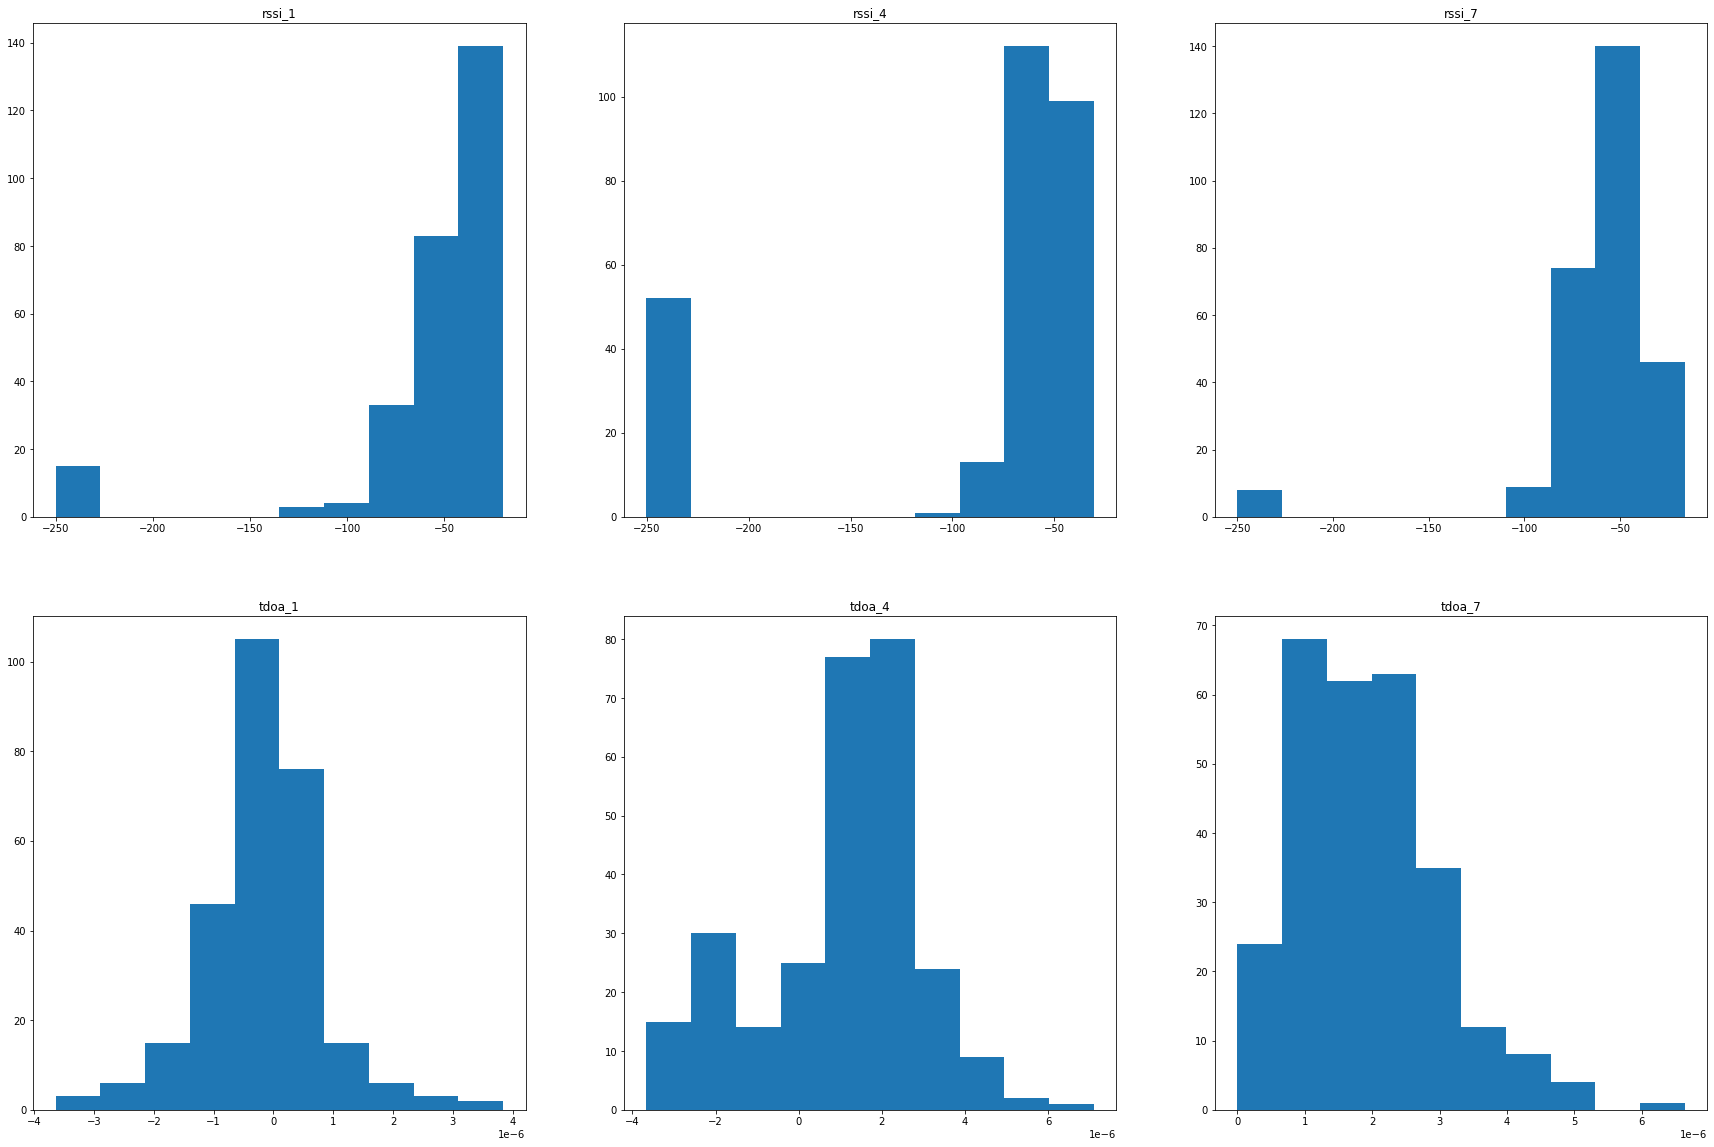

In [79]:
# Observe histograms of RSSI values from three base stations and TDoA values from three base stations
# Take the mean of readings from each reference point
rssi_1_data = actual_rps_df['rssi_1']
rssi_4_data = actual_rps_df['rssi_4']
rssi_7_data = actual_rps_df['rssi_7']

tdoa_1_data = actual_rps_df['tdoa_1']
tdoa_4_data = actual_rps_df['tdoa_4']
tdoa_7_data = actual_rps_df['tdoa_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(2,3)

axs[0][0].hist(rssi_1_data)
axs[0][0].title.set_text('rssi_1')
axs[0][1].hist(rssi_4_data)
axs[0][1].title.set_text('rssi_4')
axs[0][2].hist(rssi_7_data)
axs[0][2].title.set_text('rssi_7')

axs[1][0].hist(tdoa_1_data)
axs[1][0].title.set_text('tdoa_1')
axs[1][1].hist(tdoa_4_data)
axs[1][1].title.set_text('tdoa_4')
axs[1][2].hist(tdoa_7_data)
axs[1][2].title.set_text('tdoa_7')

In [80]:
# Use lambda function to get the scaled values of RSSI and TDoA
for i in range(1,8):
    
    scaled_rssi = f'scaled_rssi_{i}'
    scaled_tdoa = f'scaled_tdoa_{i}'
    
    min_rssi = actual_rps_df[f'rssi_{i}'].min()
    max_rssi = actual_rps_df[f'rssi_{i}'].max()
    
    min_tdoa = actual_rps_df[f'tdoa_{i}'].min()
    max_tdoa = actual_rps_df[f'tdoa_{i}'].max()
    
    actual_rps_df[scaled_rssi] = actual_rps_df[f'rssi_{i}'].apply(lambda x: scale_down(x, min_rssi, max_rssi))
    actual_rps_df[scaled_tdoa] = actual_rps_df[f'tdoa_{i}'].apply(lambda x: scale_down(x, min_tdoa, max_tdoa))  

In [81]:
actual_rps_df.head(5)

rp_index     rssi_1        tdoa_1     rssi_2        tdoa_2     rssi_3  \
0       0.0 -34.046696 -1.123946e-06 -44.011093 -6.724793e-08 -41.988583   
1       1.0 -87.400360  5.677841e-07 -42.915848  2.437005e-07 -79.553368   
2       2.0 -31.279604 -6.474654e-07 -51.763275  1.289428e-06 -52.830914   
3       3.0 -34.671375 -8.242733e-07 -41.581402  3.518202e-07 -41.585316   
4       4.0 -57.809582  3.548195e-07 -51.980194  5.152093e-07 -83.040817   

         tdoa_3     rssi_4    tdoa_4     rssi_5  ...  scaled_rssi_3  \
0  7.048233e-07 -43.762745  0.000001 -40.641834  ...       0.950463   
1  4.407984e-06 -67.593094  0.000005 -63.666416  ...       0.778925   
2  2.602336e-06 -51.702221  0.000002 -44.938671  ...       0.900952   
3  1.387090e-06 -50.376663  0.000002 -35.047039  ...       0.952304   
4  1.719081e-06 -54.659790  0.000002 -52.693283  ...       0.763000   

   scaled_tdoa_3  scaled_rssi_4  scaled_tdoa_4  scaled_rssi_5  scaled_tdoa_5  \
0       0.470444       0.939792       0.445113       0.918154            NaN   
1       0.781105       0.831315       0.764110       0.817154            NaN   
2       0.629628       0.903651       0.532363       0.899305            NaN   
3       0.527680       0.909685       0.493972       0.942696            NaN   
4       0.555531       0.890188       0.551611       0.865289            NaN   

   scaled_rssi_6  scaled_tdoa_6  scaled_rssi_7  scaled_tdoa_7  
0       0.905347       0.425339       0.758984       0.363232  
1       0.868503       0.194243       0.870808       0.205097  
2       0.842223       0.510380       0.705818       0.381212  
3       0.885340       0.393052       0.766924       0.360119  
4       0.000763       0.000000       0.854444       0.220193  

[5 rows x 34 columns]

In [82]:
# Replace scaled_tdoa_5 NAs with 0s since BS5 (734817) is the base station with greatest RSSI most of the time hence, 0 TDOA
actual_rps_df['scaled_tdoa_5'] = actual_rps_df['scaled_tdoa_5'].fillna(0.)
actual_rps_df.head(5)

rp_index     rssi_1        tdoa_1     rssi_2        tdoa_2     rssi_3  \
0       0.0 -34.046696 -1.123946e-06 -44.011093 -6.724793e-08 -41.988583   
1       1.0 -87.400360  5.677841e-07 -42.915848  2.437005e-07 -79.553368   
2       2.0 -31.279604 -6.474654e-07 -51.763275  1.289428e-06 -52.830914   
3       3.0 -34.671375 -8.242733e-07 -41.581402  3.518202e-07 -41.585316   
4       4.0 -57.809582  3.548195e-07 -51.980194  5.152093e-07 -83.040817   

         tdoa_3     rssi_4    tdoa_4     rssi_5  ...  scaled_rssi_3  \
0  7.048233e-07 -43.762745  0.000001 -40.641834  ...       0.950463   
1  4.407984e-06 -67.593094  0.000005 -63.666416  ...       0.778925   
2  2.602336e-06 -51.702221  0.000002 -44.938671  ...       0.900952   
3  1.387090e-06 -50.376663  0.000002 -35.047039  ...       0.952304   
4  1.719081e-06 -54.659790  0.000002 -52.693283  ...       0.763000   

   scaled_tdoa_3  scaled_rssi_4  scaled_tdoa_4  scaled_rssi_5  scaled_tdoa_5  \
0       0.470444       0.939792       0.445113       0.918154            0.0   
1       0.781105       0.831315       0.764110       0.817154            0.0   
2       0.629628       0.903651       0.532363       0.899305            0.0   
3       0.527680       0.909685       0.493972       0.942696            0.0   
4       0.555531       0.890188       0.551611       0.865289            0.0   

   scaled_rssi_6  scaled_tdoa_6  scaled_rssi_7  scaled_tdoa_7  
0       0.905347       0.425339       0.758984       0.363232  
1       0.868503       0.194243       0.870808       0.205097  
2       0.842223       0.510380       0.705818       0.381212  
3       0.885340       0.393052       0.766924       0.360119  
4       0.000763       0.000000       0.854444       0.220193  

[5 rows x 34 columns]

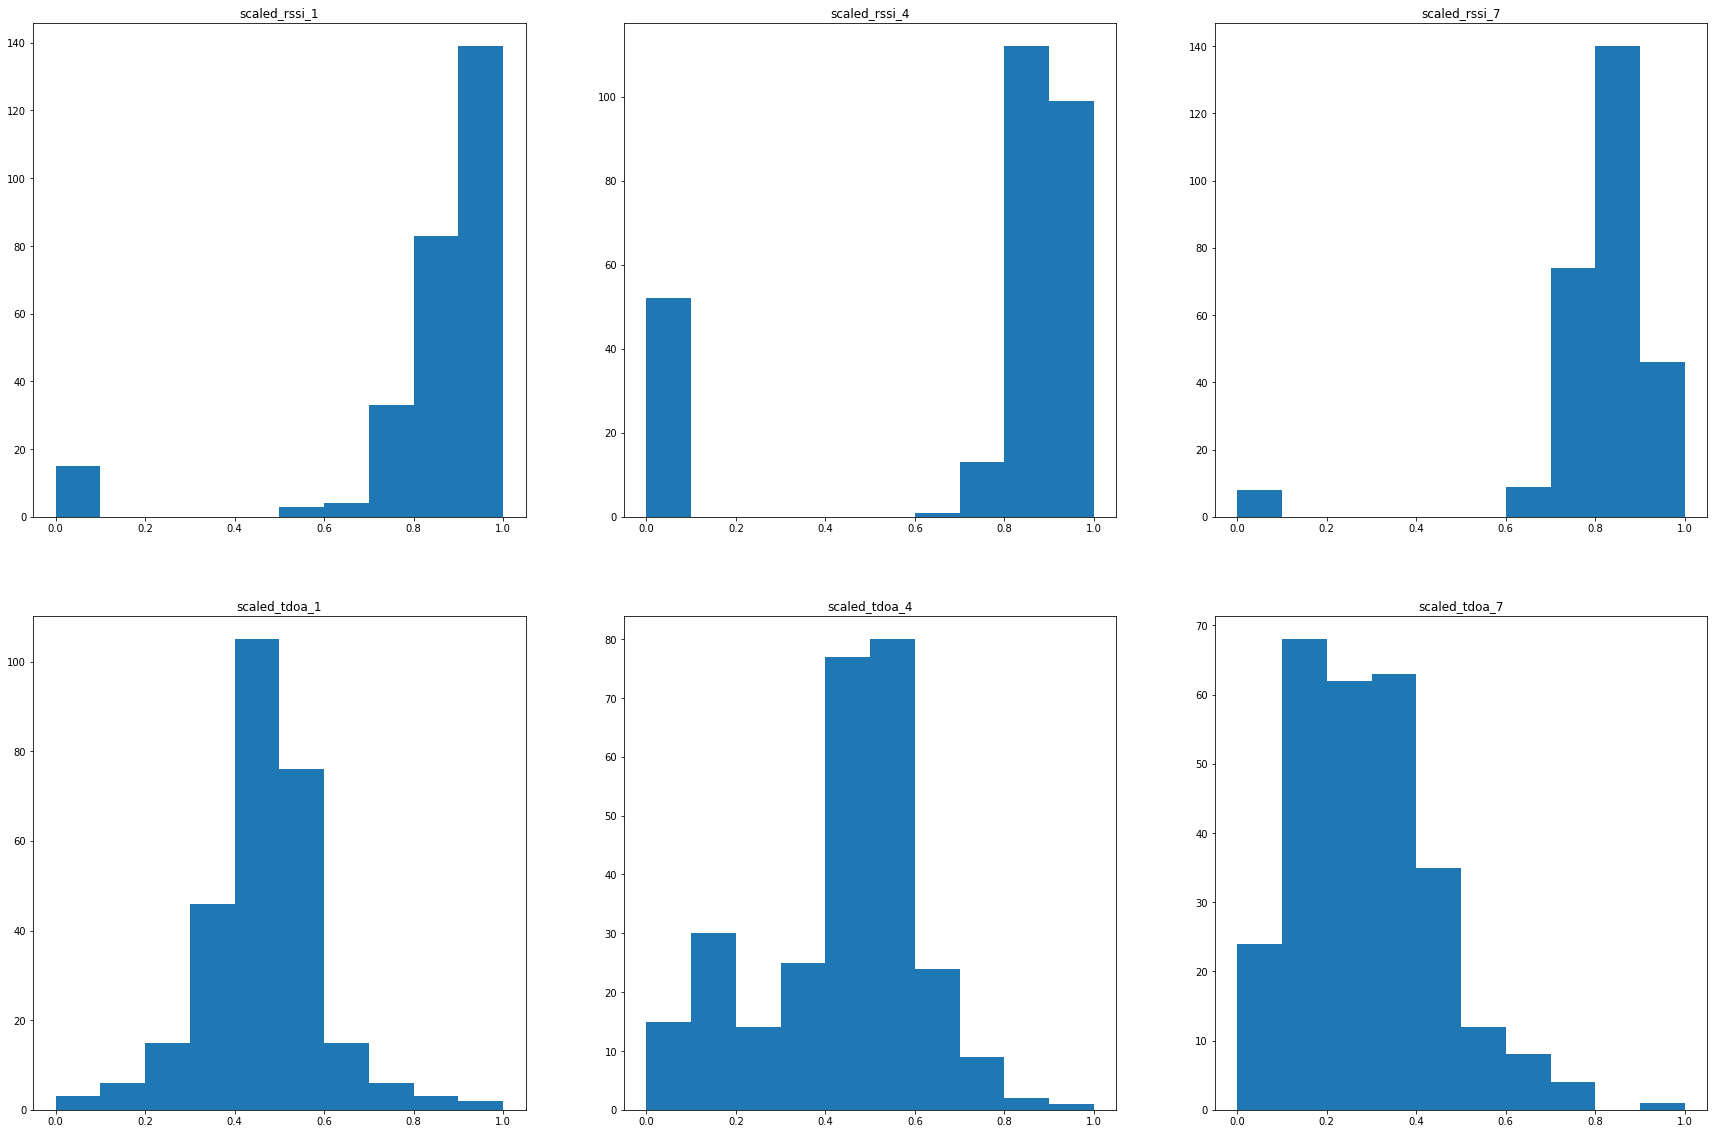

In [83]:
# Distribution is kept - Okay to use scaling to a range to scale data to keep distribution of data
# Observe histograms of RSSI values from three base stations and TDoA values from three base stations
# Take the mean of readings from each reference point
rssi_1_data = actual_rps_df['scaled_rssi_1']
rssi_4_data = actual_rps_df['scaled_rssi_4']
rssi_7_data = actual_rps_df['scaled_rssi_7']

tdoa_1_data = actual_rps_df['scaled_tdoa_1']
tdoa_4_data = actual_rps_df['scaled_tdoa_4']
tdoa_7_data = actual_rps_df['scaled_tdoa_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(2,3)

axs[0][0].hist(rssi_1_data)
axs[0][0].title.set_text('scaled_rssi_1')
axs[0][1].hist(rssi_4_data)
axs[0][1].title.set_text('scaled_rssi_4')
axs[0][2].hist(rssi_7_data)
axs[0][2].title.set_text('scaled_rssi_7')

axs[1][0].hist(tdoa_1_data)
axs[1][0].title.set_text('scaled_tdoa_1')
axs[1][1].hist(tdoa_4_data)
axs[1][1].title.set_text('scaled_tdoa_4')
axs[1][2].hist(tdoa_7_data)
axs[1][2].title.set_text('scaled_tdoa_7')

In [84]:
# Get graph for known RPs
adj_matrix = W_matrix[:249, :249]
print(adj_matrix.shape)

import networkx as nx

class GraphVisualisation:
    
    def __init__(self, adj_matrix):
        
        self.graph = nx.Graph()
        self.nodes = self.graph.nodes()
        self.edges = self.graph.edges()
        self.get_edges(adj_matrix)
        
    def get_edges(self, adj_matrix):
        
        edges = []
        num_vertices = len(adj_matrix)
        
        for i in range(num_vertices):
            for j in range(i, num_vertices):
                
                if adj_matrix[i][j] != 0:
                    self.graph.add_edge(i, j, weight = adj_matrix[i][j])
    
    def visualise(self):
        nx.draw_networkx(self.graph, node_size = 500)
        plt.show()

(249, 249)


In [85]:
actual_rp_graph = GraphVisualisation(adj_matrix)

In [86]:
from itertools import count

# Only extract values from first base station, rssi1 and tdoa1
for node_idx in actual_rp_graph.graph.nodes():

    rssi_1 = actual_rps_df[actual_rps_df['rp_index'] == node_idx]['rssi_1']
    actual_rp_graph.graph.nodes[node_idx]['rssi_1'] = rssi_1.values[0]
        
    tdoa_1 = actual_rps_df[actual_rps_df['rp_index'] == node_idx]['tdoa_1']
    actual_rp_graph.graph.nodes[node_idx]['tdoa_1'] = tdoa_1.values[0]

rssi_attribute = {}
tdoa_attribute = {}

for node_idx in actual_rp_graph.graph.nodes():
    
    rssi_attribute[node_idx] = actual_rp_graph.nodes[node_idx]['rssi_1']
    tdoa_attribute[node_idx] = actual_rp_graph.nodes[node_idx]['tdoa_1']

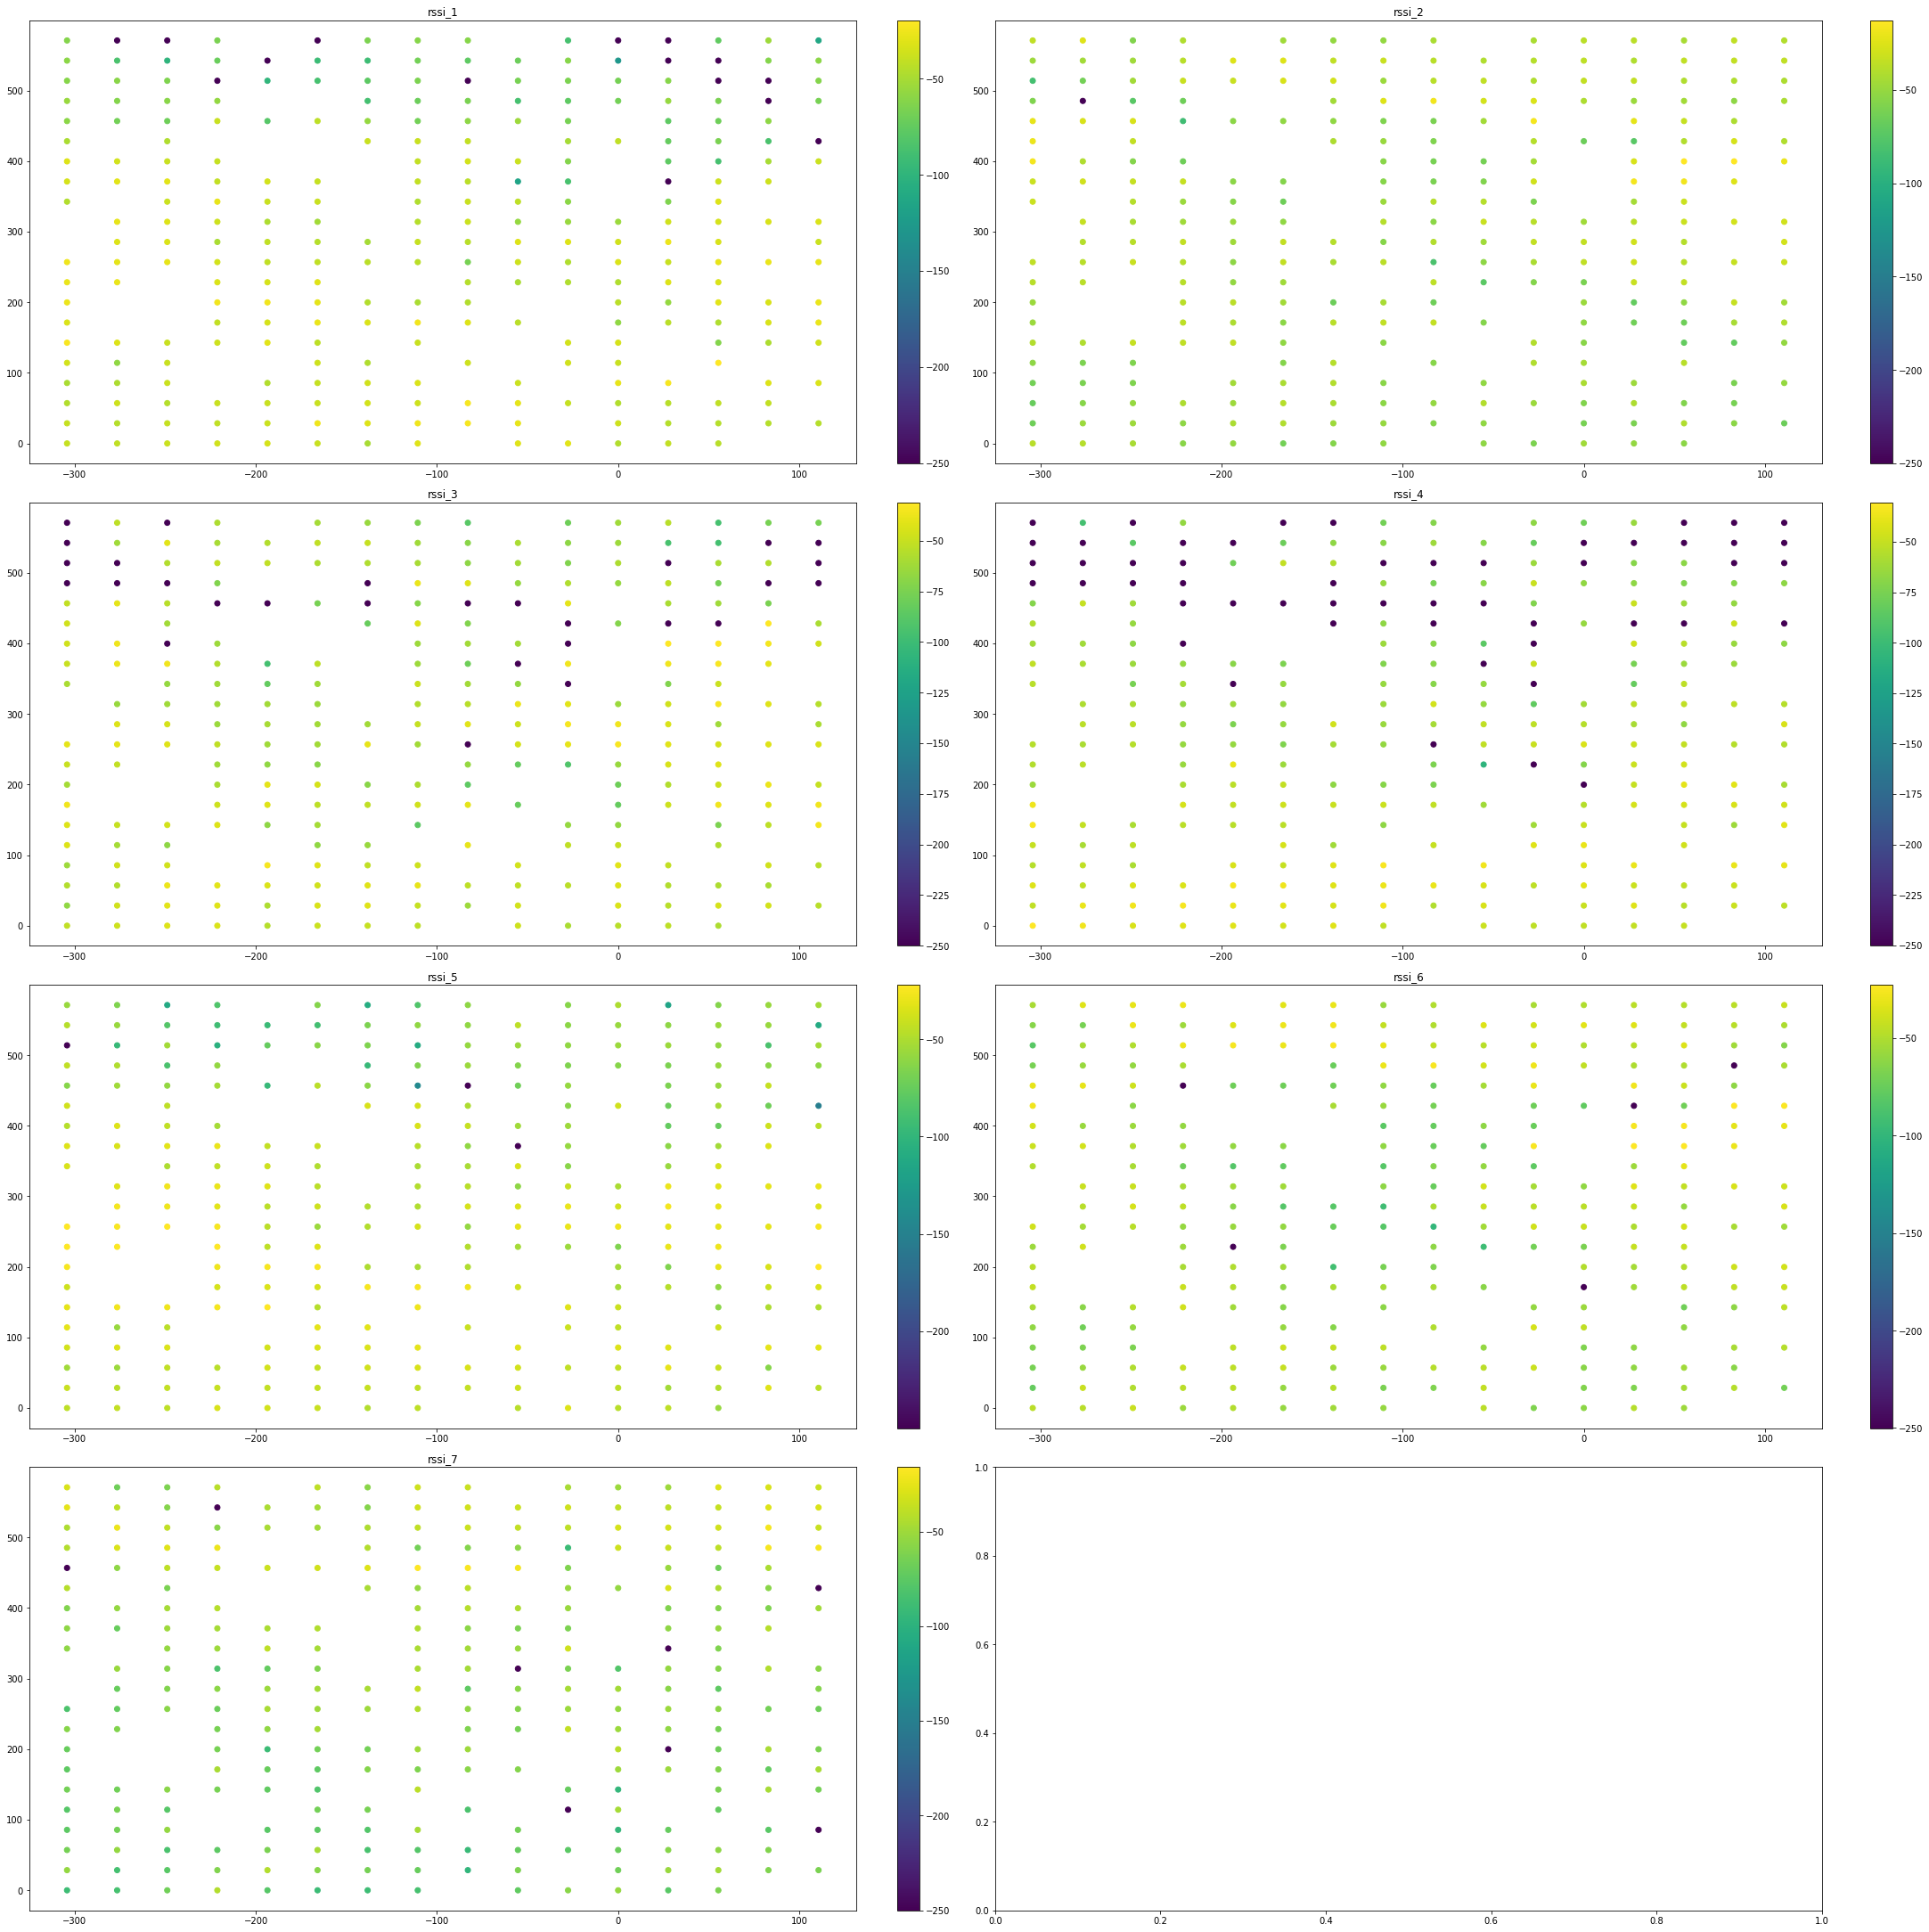

In [87]:
# Visualise on scatter plot
plt.rcParams['figure.figsize'] = [30, 30]

num_row = 4
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if (i *2) + j + 1 > ttal_bs:
            break
            
        plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = actual_rps_df[f'rssi_{(i*2) + j + 1}'])
        axs[i,j].title.set_text(f'rssi_{(i*2) + j + 1}')
        plt.colorbar(plot, ax = axs[i, j])

/tmp/ipykernel_95/1623182650.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx)
/tmp/ipykernel_95/1623182650.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'b')
/tmp/ipykernel_95/1623182650.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'r')


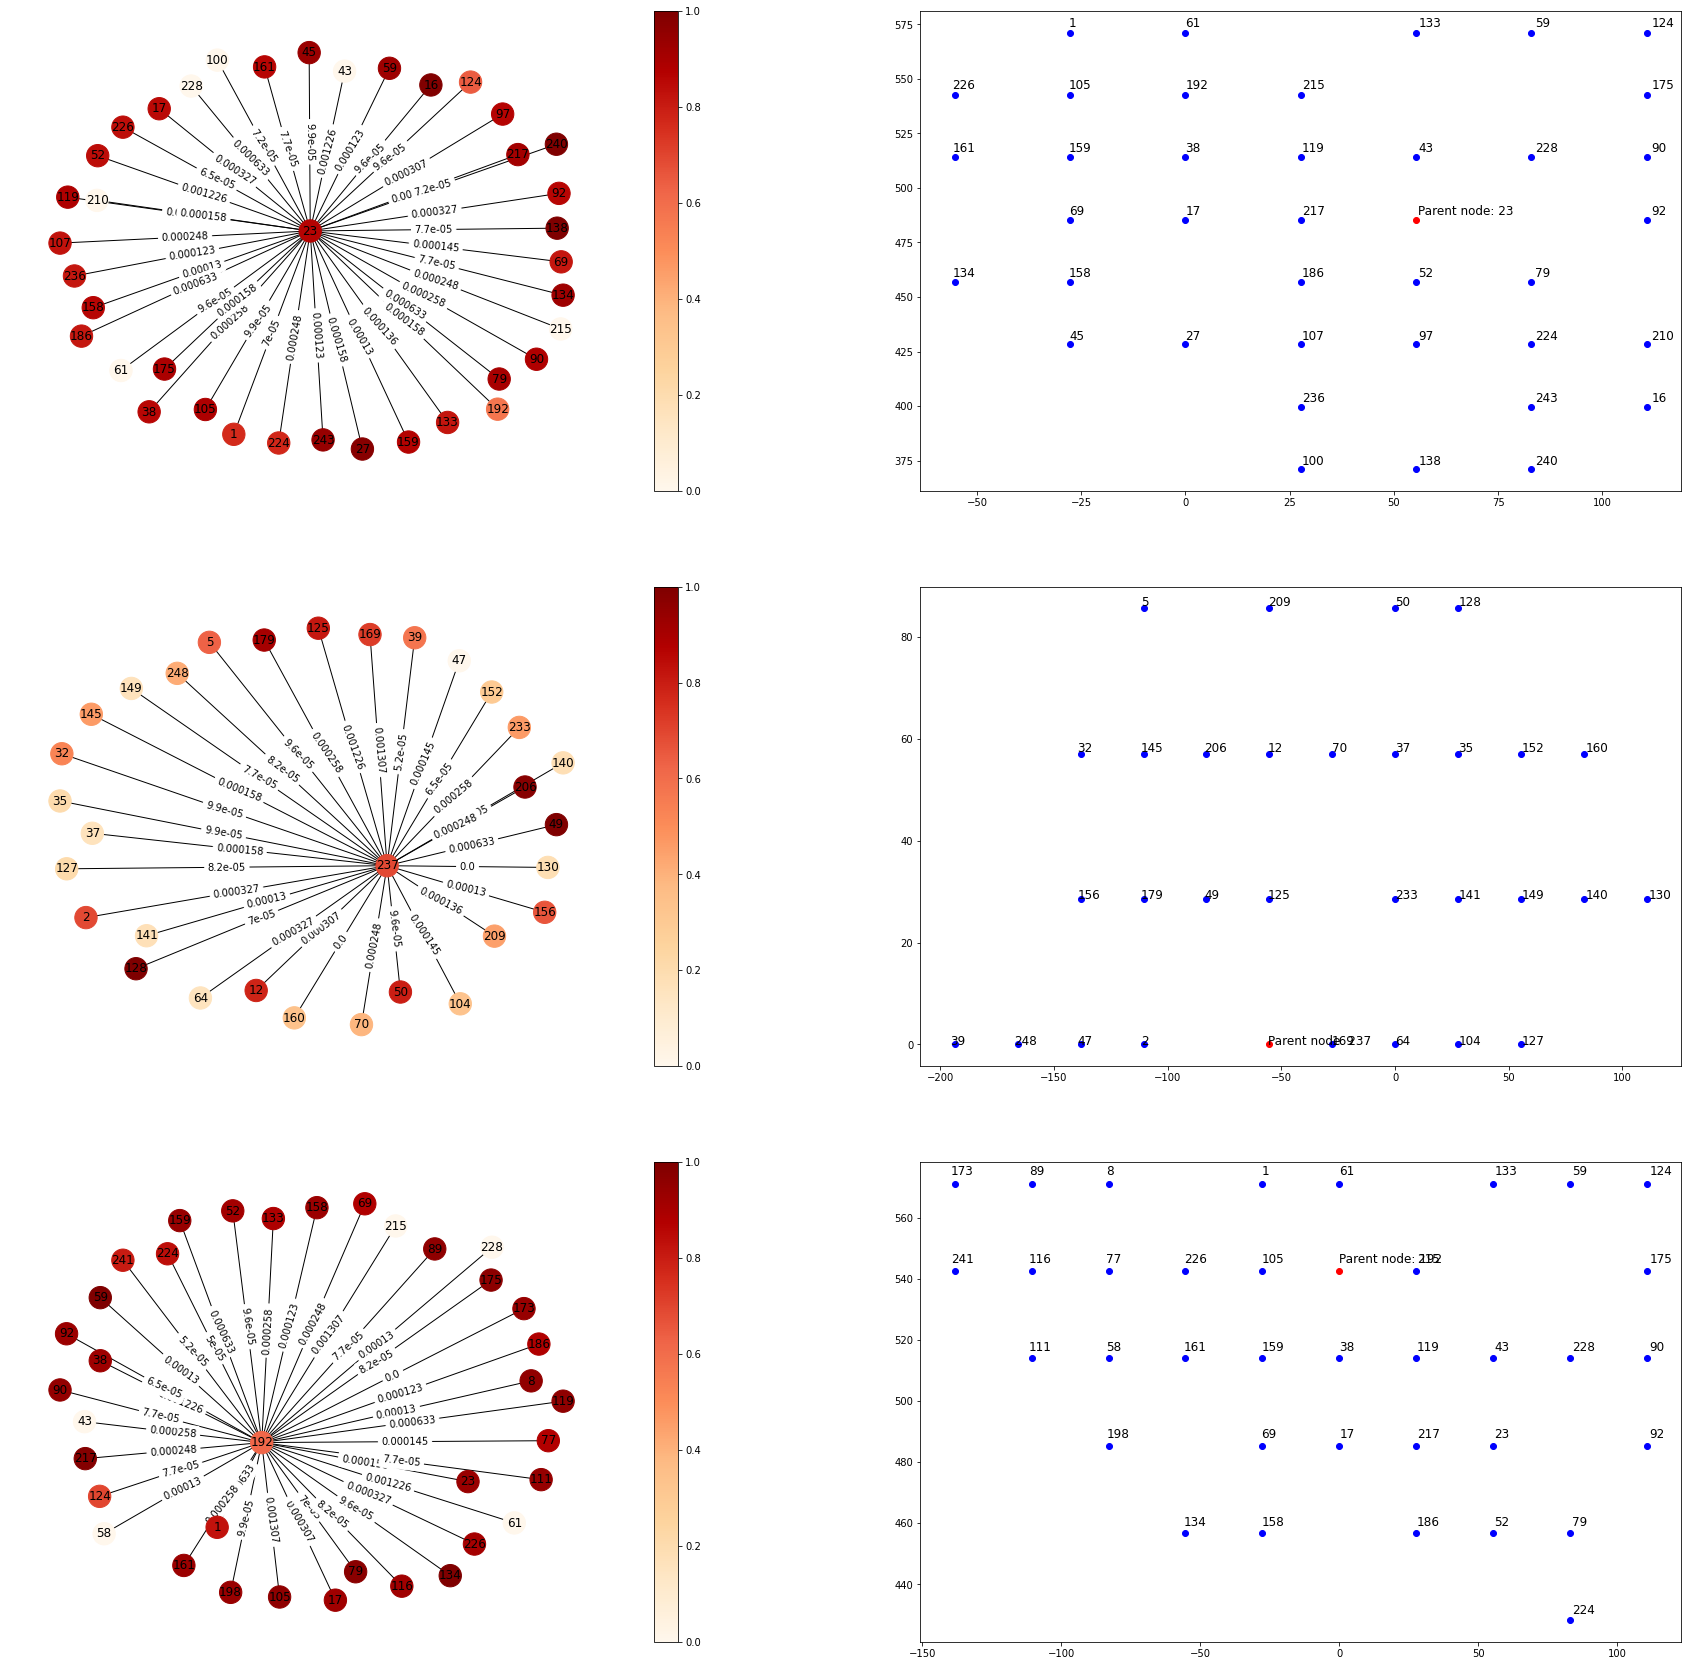

In [88]:
# Purpose of this block of code: To observe if our chosen form of graphical representation is able to make sense of difference in RSSI and TDOA readings
# Achieve this by selecting three random nodes in our graph, choose the top 10 nearest neighbours and:
# 1. Observe the edge weight
# 2. Plot out parent node and neighbours and observe their spatial distribution

import random
from itertools import count
    
# Pick out 3 random nodes
selected_nodes = []

while len(selected_nodes) < 3:
    random_nodeidx = random.randint(0,248)
    if random_nodeidx not in selected_nodes:
        selected_nodes.append(random_nodeidx)
        
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(3,2)

# For each node, get all its neighbours
nodes_dict = {}
for i in range(len(selected_nodes)):
    
    # Get neighbours
    node_idx = selected_nodes[i]
    node_edges = list(actual_rp_graph.edges(node_idx))
    neighbours = [node_edges[i][1] for i in range(len(node_edges))]
    
    # Do two subplot
    # One plot draws out the graph with node and its neighbours, showing normalised measurement value and edge weight
    # Make network graph with all interested edges
    G = nx.Graph()
    for edge in node_edges:
        G.add_edge(edge[0], edge[1], weight = W_matrix[edge[0]][edge[1]])        

    # Only extract values from first base station, rssi1 and tdoa1

    for node in G.nodes():

        rssi_1 = actual_rps_df[actual_rps_df['rp_index'] == node]['rssi_1']
        G.nodes[node]['rssi_1'] = rssi_1.values[0]

    rssi_attribute = {}
    
    for node in G.nodes():

        rssi_attribute[node] = G.nodes[node]['rssi_1']
        
    # Plot network graph with edge weights and colour of nodes depdending on measurement value
    min_rssi_value = min(rssi_attribute.values())
    max_rssi_value = max(rssi_attribute.values())

    normalised_rssi = {
        node: (rssi_value - min_rssi_value) / (max_rssi_value - min_rssi_value)
        for node, rssi_value in rssi_attribute.items()
    }

    # You can choose a colormap for continuous values (e.g., 'viridis', 'coolwarm', 'hot', etc.)
    cmap = plt.cm.get_cmap('OrRd')

    # Create a list of colors for each node based on the normalized attributes
    node_colours = [cmap(attr_value) for attr_value in normalised_rssi.values()]

    # Draw the graph with specified node colors
    pos = nx.spring_layout(G)  # You can use other layout algorithms as well
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # Round up the edge labels to 6d.p.s
    for key, value in enumerate(edge_labels):
        edge_labels[value] = round(edge_labels[value], 6)
    
    # Draw graph and weights
    nx.draw(G, pos, with_labels=True, node_color=node_colours, cmap=cmap, node_size = 500,
            ax = axs[i, 0])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, ax = axs[i, 0])
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(node_colours)
    plt.colorbar(sm, ax = axs[i, 0])
    
    # One plot is a coordinate plot of node and its neighbours
    # Get all node indexes
    # Get x and y coordinates
    neighbours.append(node_idx)
    selected_rps_df = actual_rps_df.iloc[neighbours]
    
    # Label which is parent, which is neighbour
    selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx) 

    # Get labels for points and if point is the parent point
    coord_points = []
    for j in range(len(selected_rps_df)):
        rp_index = selected_rps_df.iloc[j]['rp_index']
        x_coord = selected_rps_df.iloc[j]['rp_x']
        y_coord = selected_rps_df.iloc[j]['rp_y']
        is_parent = selected_rps_df.iloc[j]['is_parent']
        coord_points.append((rp_index, x_coord, y_coord, is_parent))

    # Scatter plot with hue based on label
    cmap = plt.get_cmap('viridis')
    for j in range(len(coord_points)):
        idx = coord_points[j][0]
        x = coord_points[j][1]
        y = coord_points[j][2]
        is_parent = coord_points[j][3]
        
        if is_parent:
            axs[i, 1].plot(x,y, 'bo', color = 'r')
        else:
            axs[i, 1].plot(x,y, 'bo', color = 'b')
            
        if is_parent:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), f'Parent node: {int(idx)}', fontsize = 12)
        else:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), int(idx), fontsize = 12)

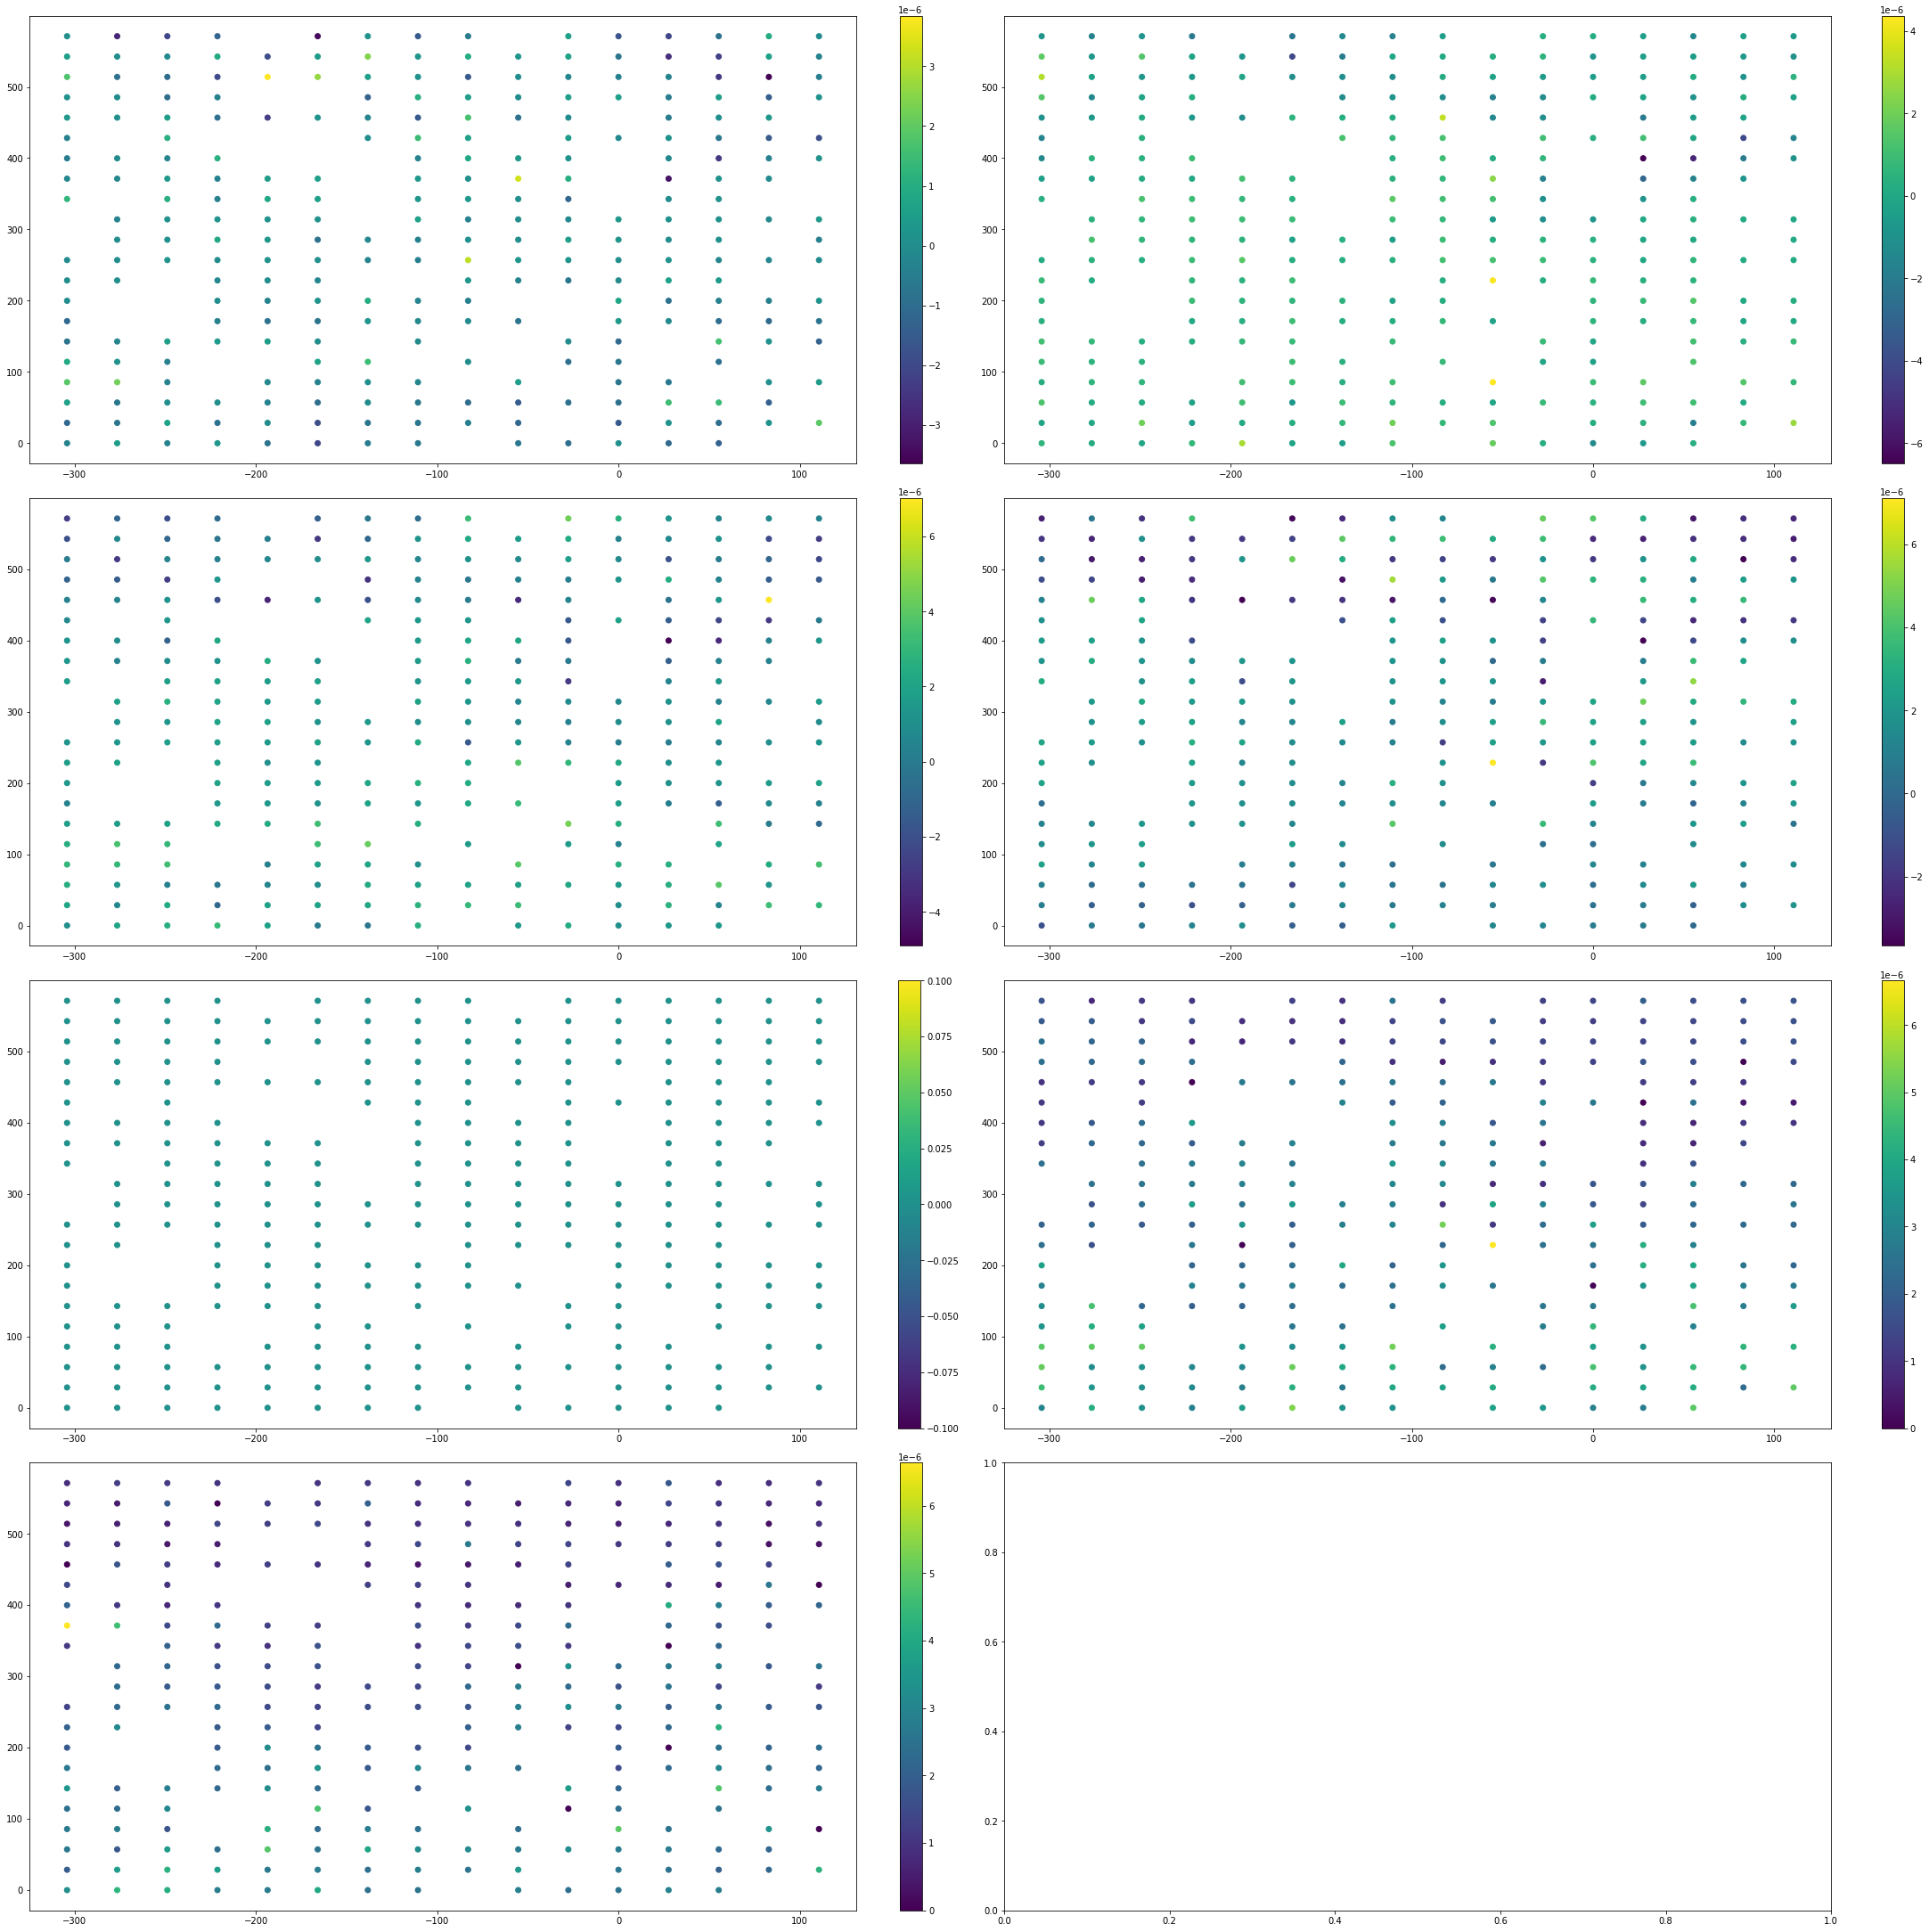

In [89]:
# Visualise on scatter plot
plt.rcParams['figure.figsize'] = [30, 30]

num_row = 4
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if (i *2) + j + 1 > ttal_bs:
            break
            
        plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = actual_rps_df[f'tdoa_{(i*2) + j + 1}'])
        plt.colorbar(plot, ax = axs[i, j])

/tmp/ipykernel_95/883442851.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx)
/tmp/ipykernel_95/883442851.py:109: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'b')
/tmp/ipykernel_95/883442851.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'r')


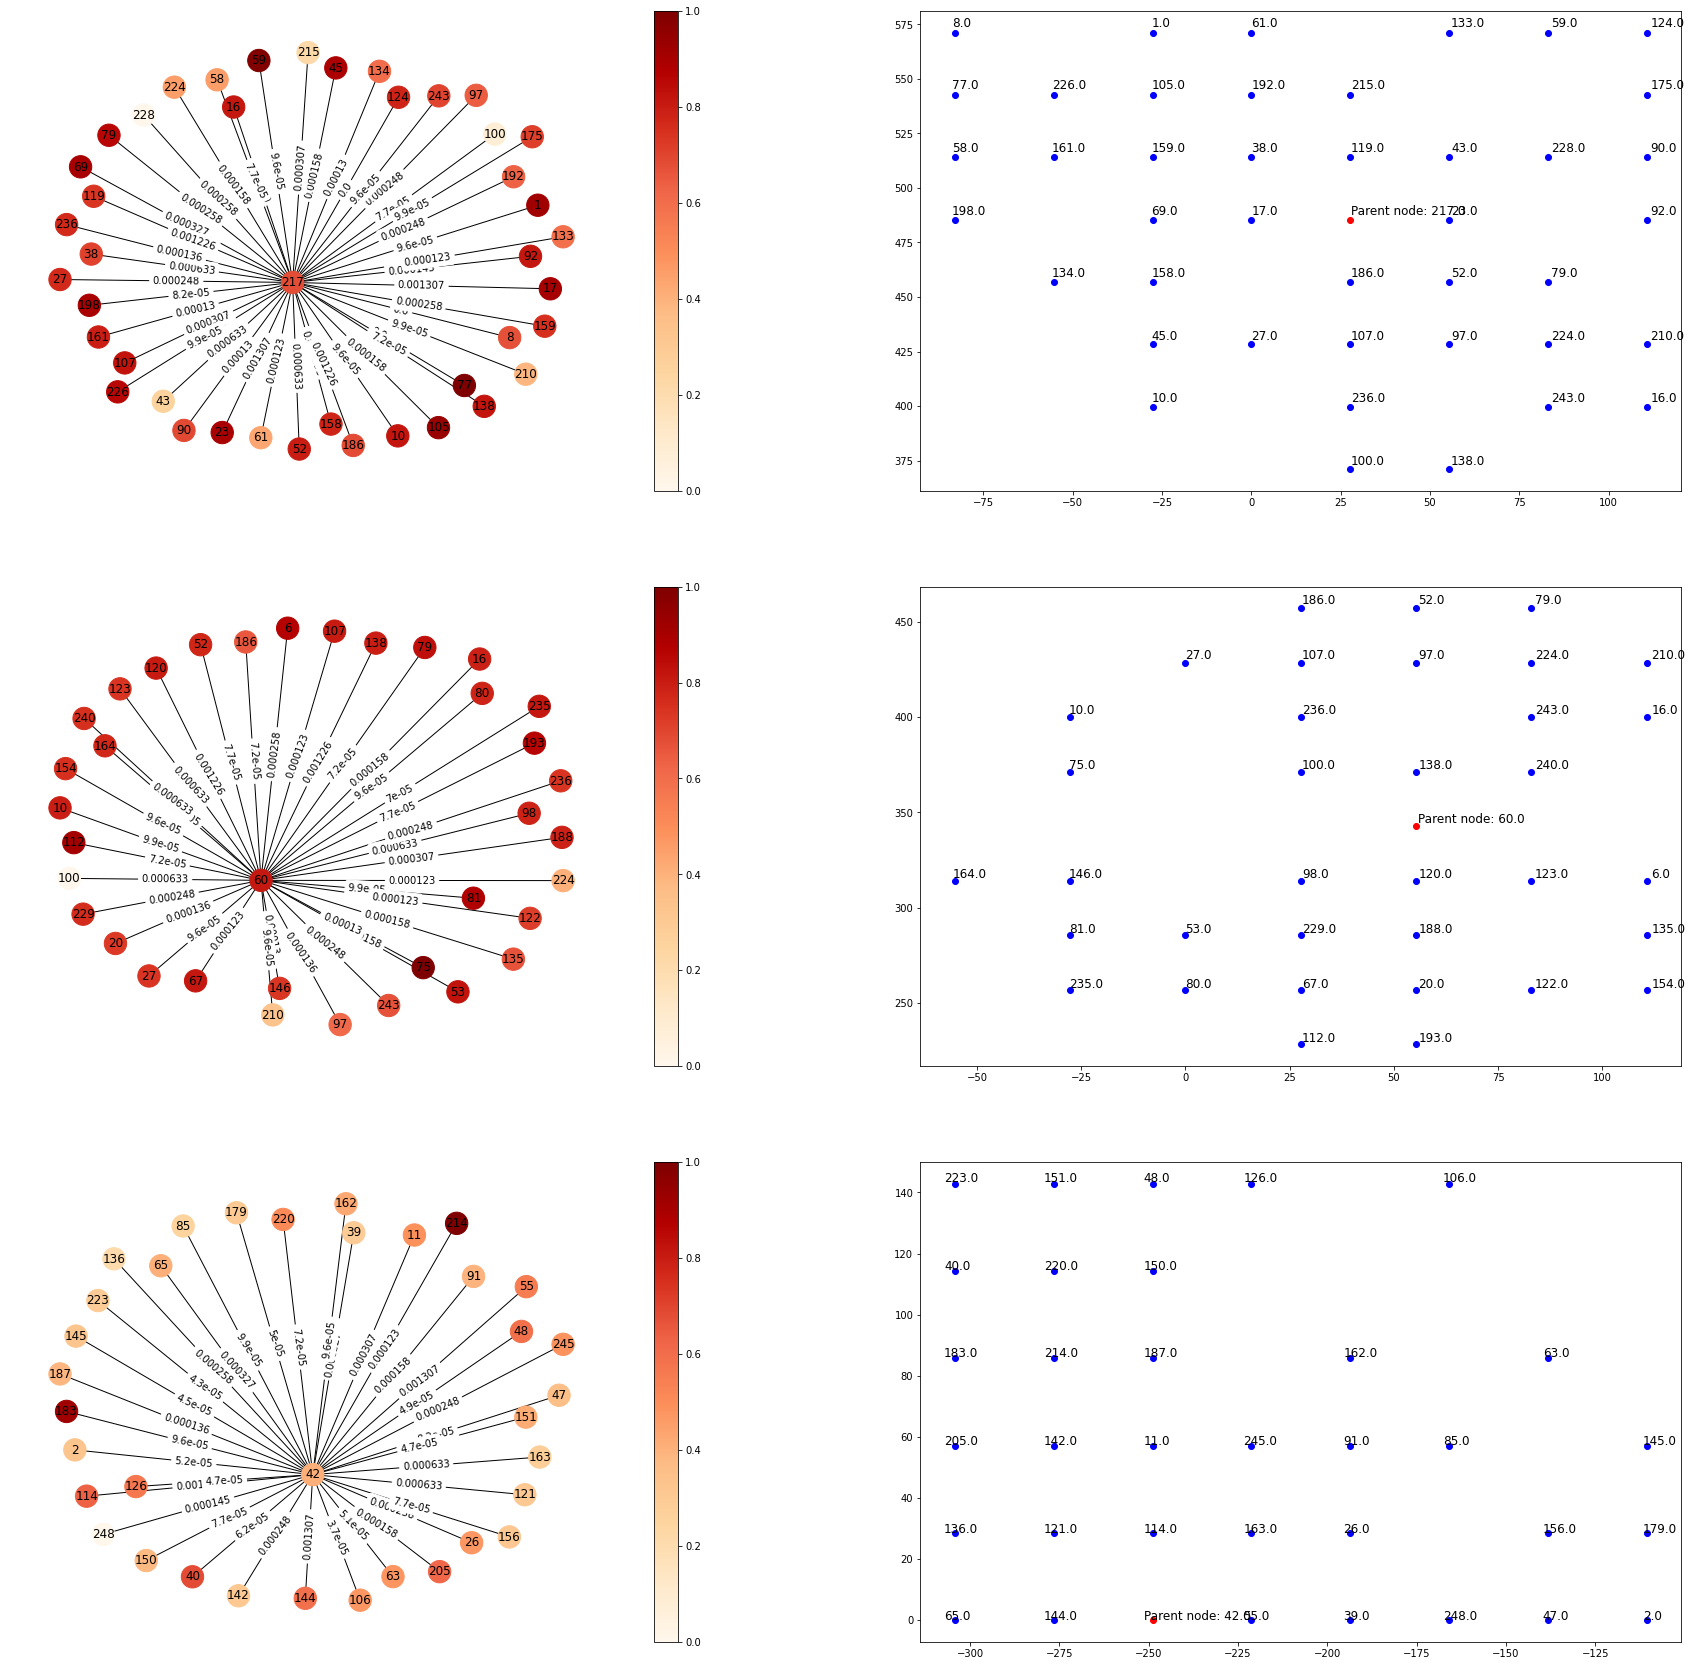

In [90]:
# Purpose of this block of code: To observe if our chosen form of graphical representation is able to make sense of difference in RSSI and TDOA readings
# Achieve this by selecting three random nodes in our graph, choose the top 10 nearest neighbours and:
# 1. Observe the edge weight
# 2. Plot out parent node and neighbours and observe their spatial distribution

import random
from itertools import count
    
# Pick out 3 random nodes
selected_nodes = []

while len(selected_nodes) < 3:
    random_nodeidx = random.randint(0,248)
    if random_nodeidx not in selected_nodes:
        selected_nodes.append(random_nodeidx)
        
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(3,2)

# For each node, get all its neighbours
nodes_dict = {}
for i in range(len(selected_nodes)):
    
    # Get neighbours
    node_idx = selected_nodes[i]
    node_edges = list(actual_rp_graph.edges(node_idx))
    neighbours = [node_edges[i][1] for i in range(len(node_edges))]
    
    # Do two subplot
    # One plot draws out the graph with node and its neighbours, showing normalised measurement value and edge weight
    # Make network graph with all interested edges
    G = nx.Graph()
    for edge in node_edges:
        G.add_edge(edge[0], edge[1], weight = W_matrix[edge[0]][edge[1]])        

    # Only extract values from first base station, rssi1 and tdoa1

    for node in G.nodes():
        tdoa_1 = actual_rps_df[actual_rps_df['rp_index'] == node]['tdoa_1']
        G.nodes[node]['tdoa_1'] = tdoa_1.values[0]

    tdoa_attribute = {}

    for node in G.nodes():

        tdoa_attribute[node] = G.nodes[node]['tdoa_1']
        
    # Plot network graph with edge weights and colour of nodes depdending on measurement value
    min_tdoa_value = min(tdoa_attribute.values())
    max_tdoa_value = max(tdoa_attribute.values())

    normalised_tdoa = {
        node: (tdoa_value - min_tdoa_value) / (max_tdoa_value - min_tdoa_value)
        for node, tdoa_value in tdoa_attribute.items()
    }

    # You can choose a colormap for continuous values (e.g., 'viridis', 'coolwarm', 'hot', etc.)
    cmap = plt.cm.get_cmap('OrRd')

    # Create a list of colors for each node based on the normalized attributes
    node_colours = [cmap(attr_value) for attr_value in normalised_tdoa.values()]

    # Draw the graph with specified node colors
    pos = nx.spring_layout(G)  # You can use other layout algorithms as well
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # Round up the edge labels to 6d.p.s
    for key, value in enumerate(edge_labels):
        edge_labels[value] = round(edge_labels[value], 6)
    
    # Draw graph and weights
    nx.draw(G, pos, with_labels=True, node_color=node_colours, cmap=cmap, node_size = 500,
            ax = axs[i, 0])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, ax = axs[i, 0])
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(node_colours)
    plt.colorbar(sm, ax = axs[i, 0])
    
    # One plot is a coordinate plot of node and its neighbours
    # Get all node indexes
    # Get x and y coordinates
    neighbours.append(node_idx)
    selected_rps_df = actual_rps_df.iloc[neighbours]
    
    # Label which is parent, which is neighbour
    selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx) 

    # Get labels for points and if point is the parent point
    coord_points = []
    for j in range(len(selected_rps_df)):
        rp_index = selected_rps_df.iloc[j]['rp_index']
        x_coord = selected_rps_df.iloc[j]['rp_x']
        y_coord = selected_rps_df.iloc[j]['rp_y']
        is_parent = selected_rps_df.iloc[j]['is_parent']
        coord_points.append((rp_index, x_coord, y_coord, is_parent))

    # Scatter plot with hue based on label
    cmap = plt.get_cmap('viridis')
    for j in range(len(coord_points)):
        idx = coord_points[j][0]
        x = coord_points[j][1]
        y = coord_points[j][2]
        is_parent = coord_points[j][3]
        
        if is_parent:
            axs[i, 1].plot(x,y, 'bo', color = 'r')
        else:
            axs[i, 1].plot(x,y, 'bo', color = 'b')
            
        if is_parent:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), f'Parent node: {idx}', fontsize = 12)
        else:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), idx, fontsize = 12)

## Observations:

### RSSI Plot:
- RSSI differs by at most 50dB in the same neighbourhood.
- But not for rssi_4 (bs_734777) where there is much more points with no RSSI compared to other BSs.

### TDoA Plot:
- Distribution of TDoA values over smaller range.
- RPs with no RSSI also has a low values of TDoA.

### Taking into account both plots,
- Underlying assumption: Points in the same vicinity should exhibit a greater degree of similarity compared to points that are further away
- When considering only one BS, no clear relationship between distance apart and difference in value. (Point far away can be close to points nearby)
- But hope that by taking inputs from sufficiently enough Ss will make measurements at each RP descriptive enough so as to differentiate points that are near as compared  to points that are far away.

#### TODO: Repeat the graph plot for at least 3 BS and see if can differentiate nearby RPs from RPs far away

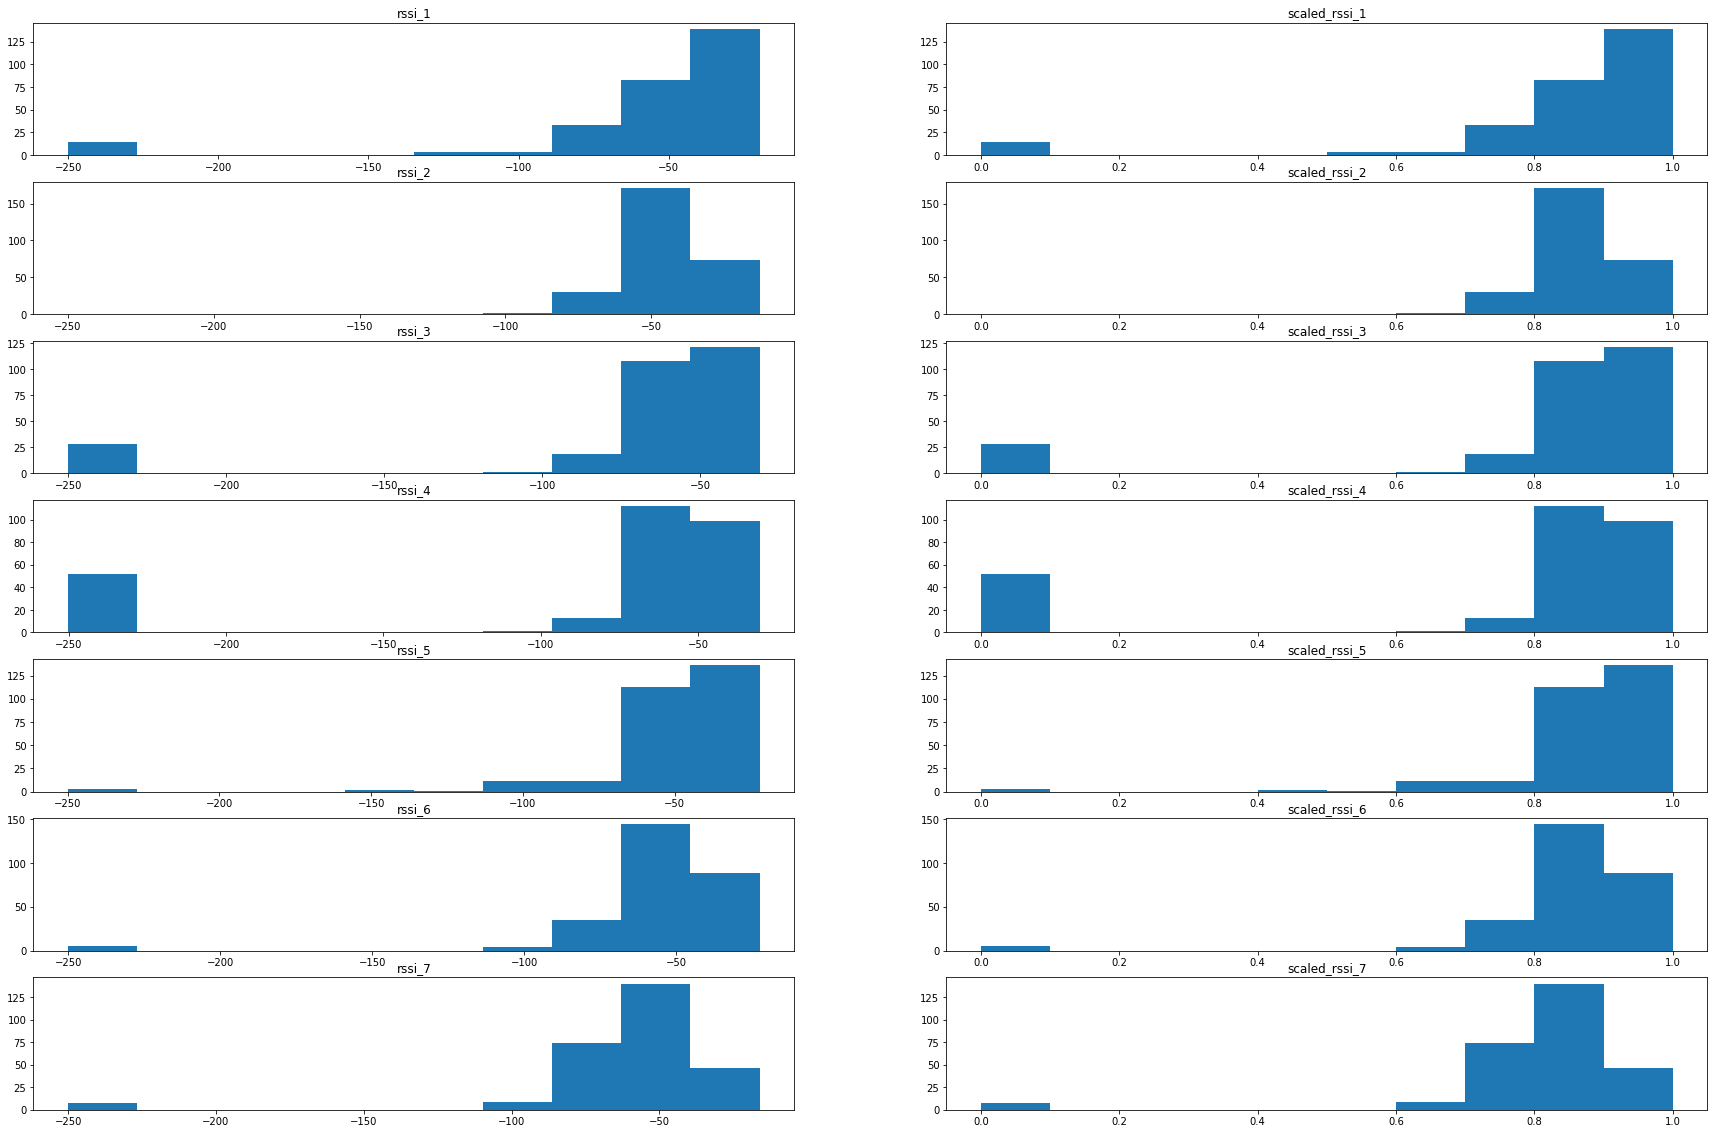

In [91]:
# Observe histograms of RSSI values from three base stations and TDoA values from three base stations
# Take the mean of readings from each reference point
rssi_1_data = actual_rps_df['rssi_1']
rssi_2_data = actual_rps_df['rssi_2']
rssi_3_data = actual_rps_df['rssi_3']
rssi_4_data = actual_rps_df['rssi_4']
rssi_5_data = actual_rps_df['rssi_5']
rssi_6_data = actual_rps_df['rssi_6']
rssi_7_data = actual_rps_df['rssi_7']

scaled_rssi_1_data = actual_rps_df['scaled_rssi_1']
scaled_rssi_2_data = actual_rps_df['scaled_rssi_2']
scaled_rssi_3_data = actual_rps_df['scaled_rssi_3']
scaled_rssi_4_data = actual_rps_df['scaled_rssi_4']
scaled_rssi_5_data = actual_rps_df['scaled_rssi_5']
scaled_rssi_6_data = actual_rps_df['scaled_rssi_6']
scaled_rssi_7_data = actual_rps_df['scaled_rssi_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(7,2)

axs[0][0].hist(rssi_1_data)
axs[0][0].title.set_text('rssi_1')
axs[0][1].hist(scaled_rssi_1_data)
axs[0][1].title.set_text('scaled_rssi_1')

axs[1][0].hist(rssi_2_data)
axs[1][0].title.set_text('rssi_2')
axs[1][1].hist(scaled_rssi_2_data)
axs[1][1].title.set_text('scaled_rssi_2')

axs[2][0].hist(rssi_3_data)
axs[2][0].title.set_text('rssi_3')
axs[2][1].hist(scaled_rssi_3_data)
axs[2][1].title.set_text('scaled_rssi_3')

axs[3][0].hist(rssi_4_data)
axs[3][0].title.set_text('rssi_4')
axs[3][1].hist(scaled_rssi_4_data)
axs[3][1].title.set_text('scaled_rssi_4')

axs[4][0].hist(rssi_5_data)
axs[4][0].title.set_text('rssi_5')
axs[4][1].hist(scaled_rssi_5_data)
axs[4][1].title.set_text('scaled_rssi_5')

axs[5][0].hist(rssi_6_data)
axs[5][0].title.set_text('rssi_6')
axs[5][1].hist(scaled_rssi_6_data)
axs[5][1].title.set_text('scaled_rssi_6')

axs[6][0].hist(rssi_7_data)
axs[6][0].title.set_text('rssi_7')
axs[6][1].hist(scaled_rssi_7_data)
axs[6][1].title.set_text('scaled_rssi_7')

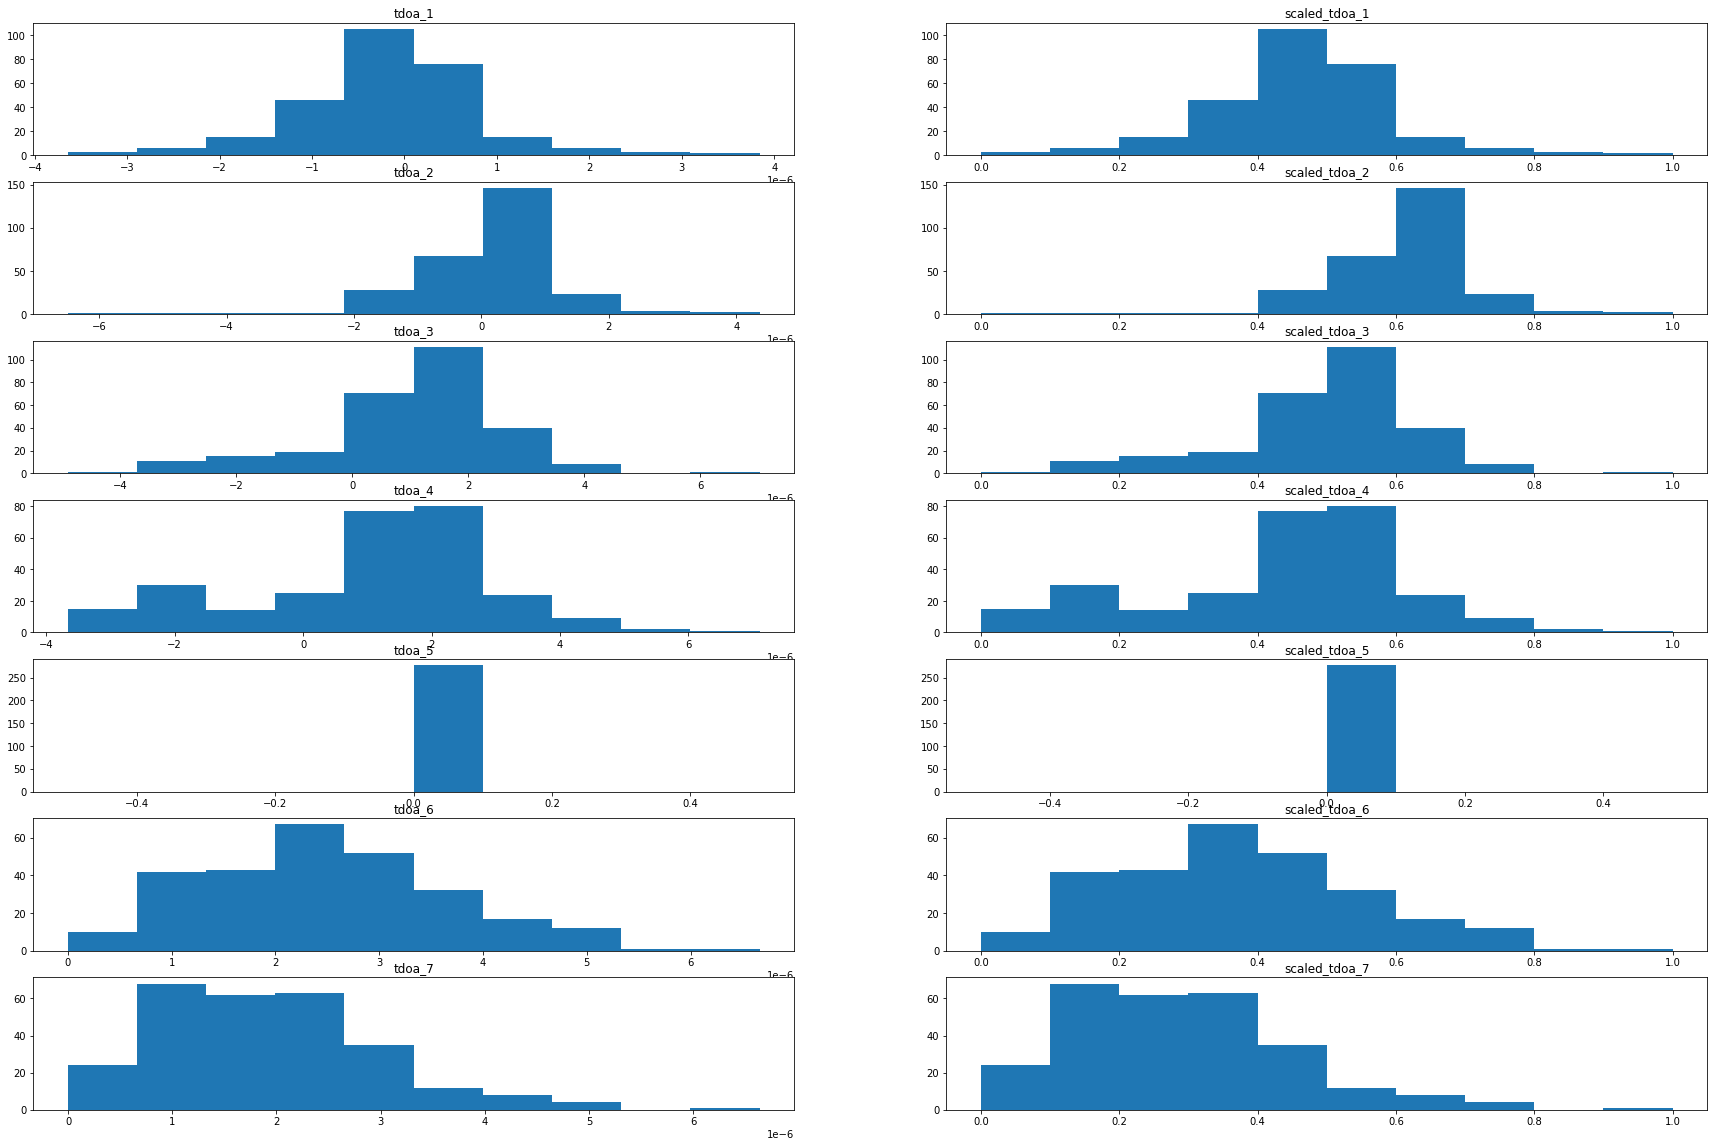

In [92]:
tdoa_1_data = actual_rps_df['tdoa_1']
tdoa_2_data = actual_rps_df['tdoa_2']
tdoa_3_data = actual_rps_df['tdoa_3']
tdoa_4_data = actual_rps_df['tdoa_4']
tdoa_5_data = actual_rps_df['tdoa_5']
tdoa_6_data = actual_rps_df['tdoa_6']
tdoa_7_data = actual_rps_df['tdoa_7']

scaled_tdoa_1_data = actual_rps_df['scaled_tdoa_1']
scaled_tdoa_2_data = actual_rps_df['scaled_tdoa_2']
scaled_tdoa_3_data = actual_rps_df['scaled_tdoa_3']
scaled_tdoa_4_data = actual_rps_df['scaled_tdoa_4']
scaled_tdoa_5_data = actual_rps_df['scaled_tdoa_5']
scaled_tdoa_6_data = actual_rps_df['scaled_tdoa_6']
scaled_tdoa_7_data = actual_rps_df['scaled_tdoa_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(7,2)

axs[0][0].hist(tdoa_1_data)
axs[0][0].title.set_text('tdoa_1')
axs[0][1].hist(scaled_tdoa_1_data)
axs[0][1].title.set_text('scaled_tdoa_1')

axs[1][0].hist(tdoa_2_data)
axs[1][0].title.set_text('tdoa_2')
axs[1][1].hist(scaled_tdoa_2_data)
axs[1][1].title.set_text('scaled_tdoa_2')

axs[2][0].hist(tdoa_3_data)
axs[2][0].title.set_text('tdoa_3')
axs[2][1].hist(scaled_tdoa_3_data)
axs[2][1].title.set_text('scaled_tdoa_3')

axs[3][0].hist(tdoa_4_data)
axs[3][0].title.set_text('tdoa_4')
axs[3][1].hist(scaled_tdoa_4_data)
axs[3][1].title.set_text('scaled_tdoa_4')

axs[4][0].hist(tdoa_5_data)
axs[4][0].title.set_text('tdoa_5')
axs[4][1].hist(scaled_tdoa_5_data)
axs[4][1].title.set_text('scaled_tdoa_5')

axs[5][0].hist(tdoa_6_data)
axs[5][0].title.set_text('tdoa_6')
axs[5][1].hist(scaled_tdoa_6_data)
axs[5][1].title.set_text('scaled_tdoa_6')

axs[6][0].hist(tdoa_7_data)
axs[6][0].title.set_text('tdoa_7')
axs[6][1].hist(scaled_tdoa_7_data)
axs[6][1].title.set_text('scaled_tdoa_7')

## Step 8 (Part 1): Train model to get mean of measurements

Important note: TDoA 5 is removed from features since it is always 0 and including it in training may affect the training of other features

Choices in Architecture:

1. Aggregator's Activation function: **No** activation function used
    - Possible candidates considered and why they were not selected
        - ReLU: Dead neuron problems. Matrix multiplication which produced negative values resulted in the model outputting 0 hence, a loss in feature.
        - LeakyReLU: While LeakyReLU helps to mitigate the problem of dead neurons, some of the outputs still outputted 0 which is a problem.
        - Sigmoid: Sigmoids were meant to reduce a large continuous range to between 0 and 1. This can possibly cause values that were not as close to 0 previously to be now mapped to 0. However, many values were still mapped to 0.
        - Tanh: Similar problem with sigmoid activation but worse since the range is now between -1 and 1.
        

2. Loss function: **Huber loss** of sum of self outputs and neighbour outputs (This is a regression output)

    - Possible candidates considered and why they were not selected
        - MSE: Some of the RSSI measurements have a decently large number of RP where signals cannot be received. This led to many 0s when min max scaler is applied and these 0s are considered outliers as majority of values are distributed between 0.6 and 1. MSE does not do well with outliers.
        
        - MAE: MAE seeks to deal with outliers better than MSE but MAE may place lesser weight on outlier values and this can possibly lead to loss of feature representation.
        
        - Huber loss: A combination of both MSE and MAE and either is chosen depending on the value of delta, if loss less than delta, use MSE else MAE.

3. Regularisation: **Dropout** on aggregator layers with rate = 0.1

    - Rationale: Some features mostly have output of 0 (not learnt well) while some other features may be learnt well. This is a possible case of overfitting where some features are learnt more than others. Introduce dropout to allow more equal learning of features.

In [259]:
# placeholders can be removed from __init__() function for GraphSAGE and edge iterator 
# Leave it as it is first and decide whether to remove later
placeholders = construct_placeholders()

# Get data
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()
actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Normalise data
# For each of the 14th measurement (col) for each RP sample, find the min and max value
num_features = 14
normalised_features = []

for i in range(num_features):
    
    # skip over TDoA 5
    if i == 9:
        continue
        
    # Get the i-th measurements for all reference points for all samples
    feature_arr = actual_rps_measurements[:,:,i]
    # print(feature_arr.shape)
    # Find out min and max value for the i-th measurement
    min_val = np.amin(feature_arr)
    max_val = np.amax(feature_arr)
    
    tmp = np.zeros(shape = feature_arr.shape, dtype = np.float32)
    # Iterate over no. of reference points
    for j in range(tmp.shape[0]):
        
        # Iterate over no. of samples
        for k in range(tmp.shape[1]):
            
            # Account for division by 0
            if max_val - min_val == 0:
                tmp[j][k] = 0

            # Perform normalisation using math formula
            else:
                tmp[j][k] = (feature_arr[j][k] - min_val) / (max_val - min_val)
    
    normalised_features.append(tmp)
    
normalised_features = np.array(normalised_features)
# print(normalised_features.shape)

# Get mean of the 100 samples
avg_normalised_features = np.mean(normalised_features, axis = 2)
avg_normalised_features = avg_normalised_features.T

# print(actual_rps_indexes)

In [260]:
# Get adjacency and degree matrix
adj = W_matrix
degrees = D_matrix

# Create graph needed for model
model_graph = nx.Graph()
num_vertices = len(W_matrix)

# Create the complete graph
for i in range(num_vertices):
    for j in range(num_vertices):
        
        if W_matrix[i][j] != 0:
            model_graph.add_edge(i, j, weight = W_matrix[i][j])

print(train_rps.shape, val_rps.shape, test_rps.shape)

# Mark the vertices in the graph on whether they are train, validation or test
# node_type = 1 for training, 0 for validation and -1 for test
for node_idx in model_graph.nodes():
    
    if node_idx in train_rps:
        model_graph.nodes[node_idx]['train'] = True
        model_graph.nodes[node_idx]['node_type'] = 1
    
    elif node_idx in val_rps:
        model_graph.nodes[node_idx]['val'] = True
        model_graph.nodes[node_idx]['node_type'] = 0
        
    else:
        model_graph.nodes[node_idx]['test'] = True
        model_graph.nodes[node_idx]['node_type'] = -1

(263,) (14,) (400,)


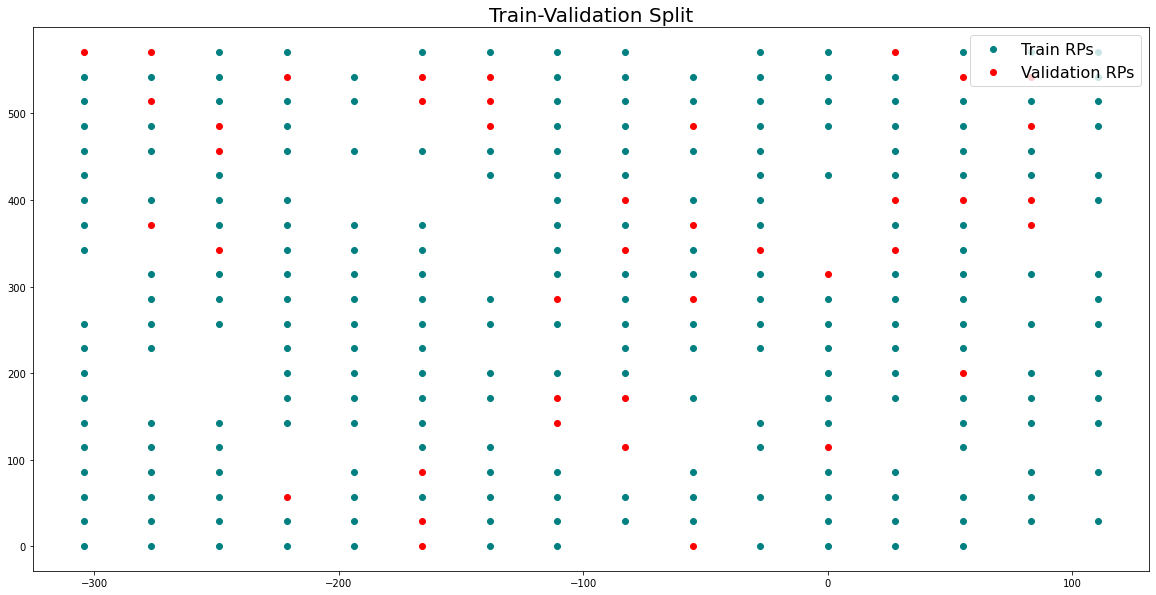

In [261]:
# Get train and validation reference points
# print(train_size)
train_rps_df = X_train_actual_df.iloc[:236]
val_rps_df = X_train_actual_df.iloc[236:]
# train_rps_df.head(10)

# Visualise RPs in train and validation dataset
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Train-Validation Split', fontsize = 20)
plt.scatter(train_rps_df['rp_x'], train_rps_df['rp_y'], color = 'teal', label = 'Train RPs')
plt.scatter(val_rps_df['rp_x'], val_rps_df['rp_y'], color = 'red', label = 'Validation RPs')
# plt.scatter(X_train_virtual_df['rp_x'], X_train_virtual_df['rp_y'], color = 'orange', label = 'Test RPs')
plt.legend(loc = 'upper right', fontsize = 16)

In [266]:
# Get layers information
from collections import namedtuple

SAGEInfo = namedtuple("SAGEInfo",
        ['layer_name', # name of the layer (to get feature embedding etc.)
         'num_samples',
         'output_dim' # the output (i.e., hidden) dimension
        ])
layer_infos = [SAGEInfo("layer_1", 10, 13),
              SAGEInfo("layer_2", 5, 13)]

## Step 8 (Part 2): Use trained model to learn features of unknown nodes

- Load weights and predict representation of unknown nodes
- Visualise model's output for all features and zoom into specific features (RSSI_1, RSSI_4, RSSI_7, TDOA_1, TDOA_4, TDOA_7)

In [327]:
'''
__init__() method for GraphSAGE model:
 def __init__(self, placeholders, features, graph, adj, degrees, layer_infos,
                 model_name, neg_sample_size, concat = True, model_size = 'small',
                 logging = False, learning_rate = 0.0001, params_decay = 0., **kwargs):
'''

graphsage_model_mean = GraphSAGE(placeholders, avg_normalised_features, model_graph, adj, degrees,
                           layer_infos, 'graphsage_mean_v1', 50, concat = False)

In [328]:
print(graphsage_model_mean.trainable_variables)

[]


In [329]:
'''def train_model(self, epochs, max_total_steps, validate_every, print_every):'''
# Source code parameters: epochs = 500, max_total_steps = 10**10, validate_every = 5000, print_every = 50 
results = graphsage_model_mean.train_model(100, 10**7, 50, 50)

Unexpected missing: 0
263 train nodes
14 val nodes
400 test nodes
End of Epoch 1
train_loss: 0.037808
val_loss: 0.010059
average_time: 0.253785
End of Epoch 2
train_loss: 0.031267
val_loss: 0.008285
average_time: 0.252875
End of Epoch 3
train_loss: 0.022710
val_loss: 0.007343
average_time: 0.252746
End of Epoch 4
train_loss: 0.020327
val_loss: 0.006369
average_time: 0.252859
End of Epoch 5
train_loss: 0.020953
val_loss: 0.005440
average_time: 0.252673
End of Epoch 6
train_loss: 0.018254
val_loss: 0.005017
average_time: 0.252652
End of Epoch 7
train_loss: 0.013965
val_loss: 0.004492
average_time: 0.252450
End of Epoch 8
train_loss: 0.016532
val_loss: 0.004334
average_time: 0.252517
End of Epoch 9
train_loss: 0.011145
val_loss: 0.004052
average_time: 0.252442
End of Epoch 10
train_loss: 0.013153
val_loss: 0.004249
average_time: 0.252240
End of Epoch 11
train_loss: 0.011617
val_loss: 0.004227
average_time: 0.252095
End of Epoch 12
train_loss: 0.010587
val_loss: 0.003973
average_time: 0.25

In [330]:
graphsage_model_mean.save_model('mean')

In [331]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

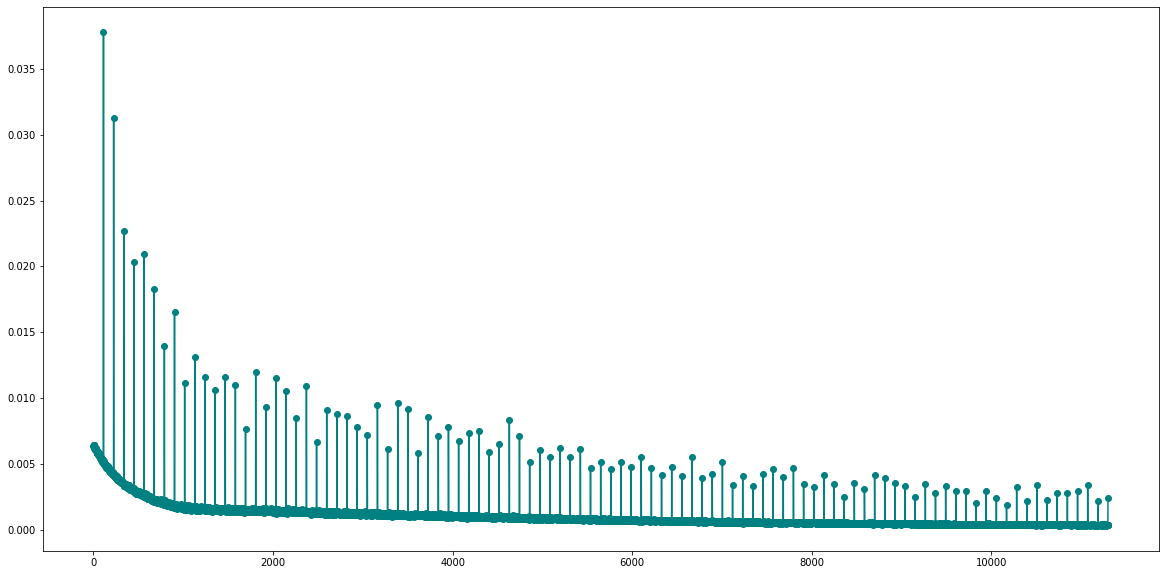

In [332]:
# learning rate of 0.0001
train_loss_arr = []

for loss in results['train_loss']:
    train_loss_arr.append(loss.numpy())
train_iters = [_ for _ in range(len(train_loss_arr))]

plt.plot(train_iters, train_loss_arr, marker='o', color = 'teal')

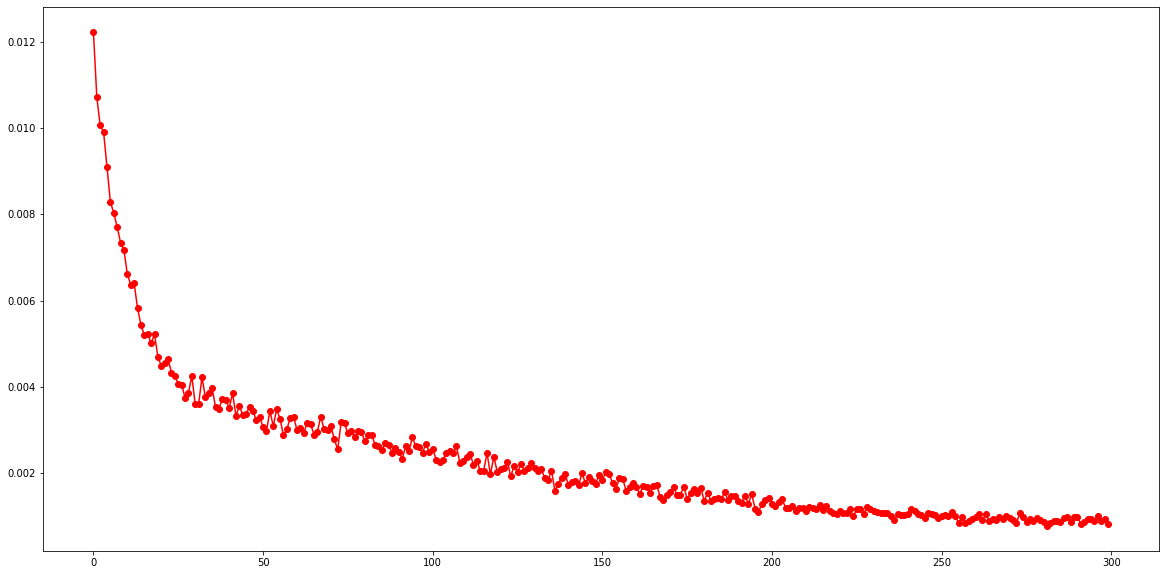

In [333]:
# learning rate of 0.0001

val_loss_arr = []

for val_loss in results['val_loss']:
    val_loss_arr.append(val_loss.numpy())
val_iters = [_ for _ in range(len(val_loss_arr))]

plt.plot(val_iters, val_loss_arr, marker= 'o', color = 'red')

In [352]:
# Load weights of model
graphsage_model_mean.load_model('mean_aggregators_weights.npy', 'mean_aggregators_biases.npy')

results_dict = graphsage_model_mean.get_unknown_features(test_rps)

Unexpected missing: 0
263 train nodes
14 val nodes
400 test nodes


In [353]:
print(train_rps.shape)
print(test_rps.shape)

(263,)
(400,)


In [354]:
# Get actual reference points
# Recall from above:
# actual_rps_indexes: Store rp indexes of actual rps
# fp_array: Stores features of actual rps
# test_rps: Store rp indexes of virtual rps
# rssi_1, tdoa_1, rssi_2, tdoa_2, ..., rssi_5, rssi_6, tdoa_6, ..., tdoa7

# actual_rps_indexes = actual_rps_indexes
actual_rps_indexes = np.concatenate((train_rps, val_rps), axis = 0)
actual_rps_features = fp_array

# virtual_rps_indexes = virtual_rp_indexes
virtual_rps_indexes = test_rps
num_features = avg_normalised_features.shape[1]
virtual_rps_features = np.zeros((len(results_dict), num_features), dtype = np.float32)
for index, (key, value) in enumerate(results_dict.items()):
    virtual_rps_features[index] = value

rp_idxs = np.concatenate((actual_rps_indexes, virtual_rps_indexes), axis = 0)
rp_features = np.concatenate((avg_normalised_features, virtual_rps_features), axis = 0)

In [356]:
# Insert a column of zeros for TDoA 5
num_rps = len(avg_normalised_features)
tdoa_5_col = np.zeros((num_rps,))
avg_normalised_features = np.insert(avg_normalised_features, 9, tdoa_5_col, axis = 1)

num_rps = len(virtual_rps_features)
tdoa_5_col = np.zeros((num_rps,))
virtual_rps_features = np.insert(virtual_rps_features, 9, tdoa_5_col, axis = 1)

num_rps = len(rp_features)
tdoa_5_col = np.zeros((num_rps,))
rp_features = np.insert(rp_features, 9, tdoa_5_col, axis = 1)

print(avg_normalised_features.shape)
print(virtual_rps_features.shape)
print(rp_features.shape)

(277, 14)
(400, 14)
(677, 14)


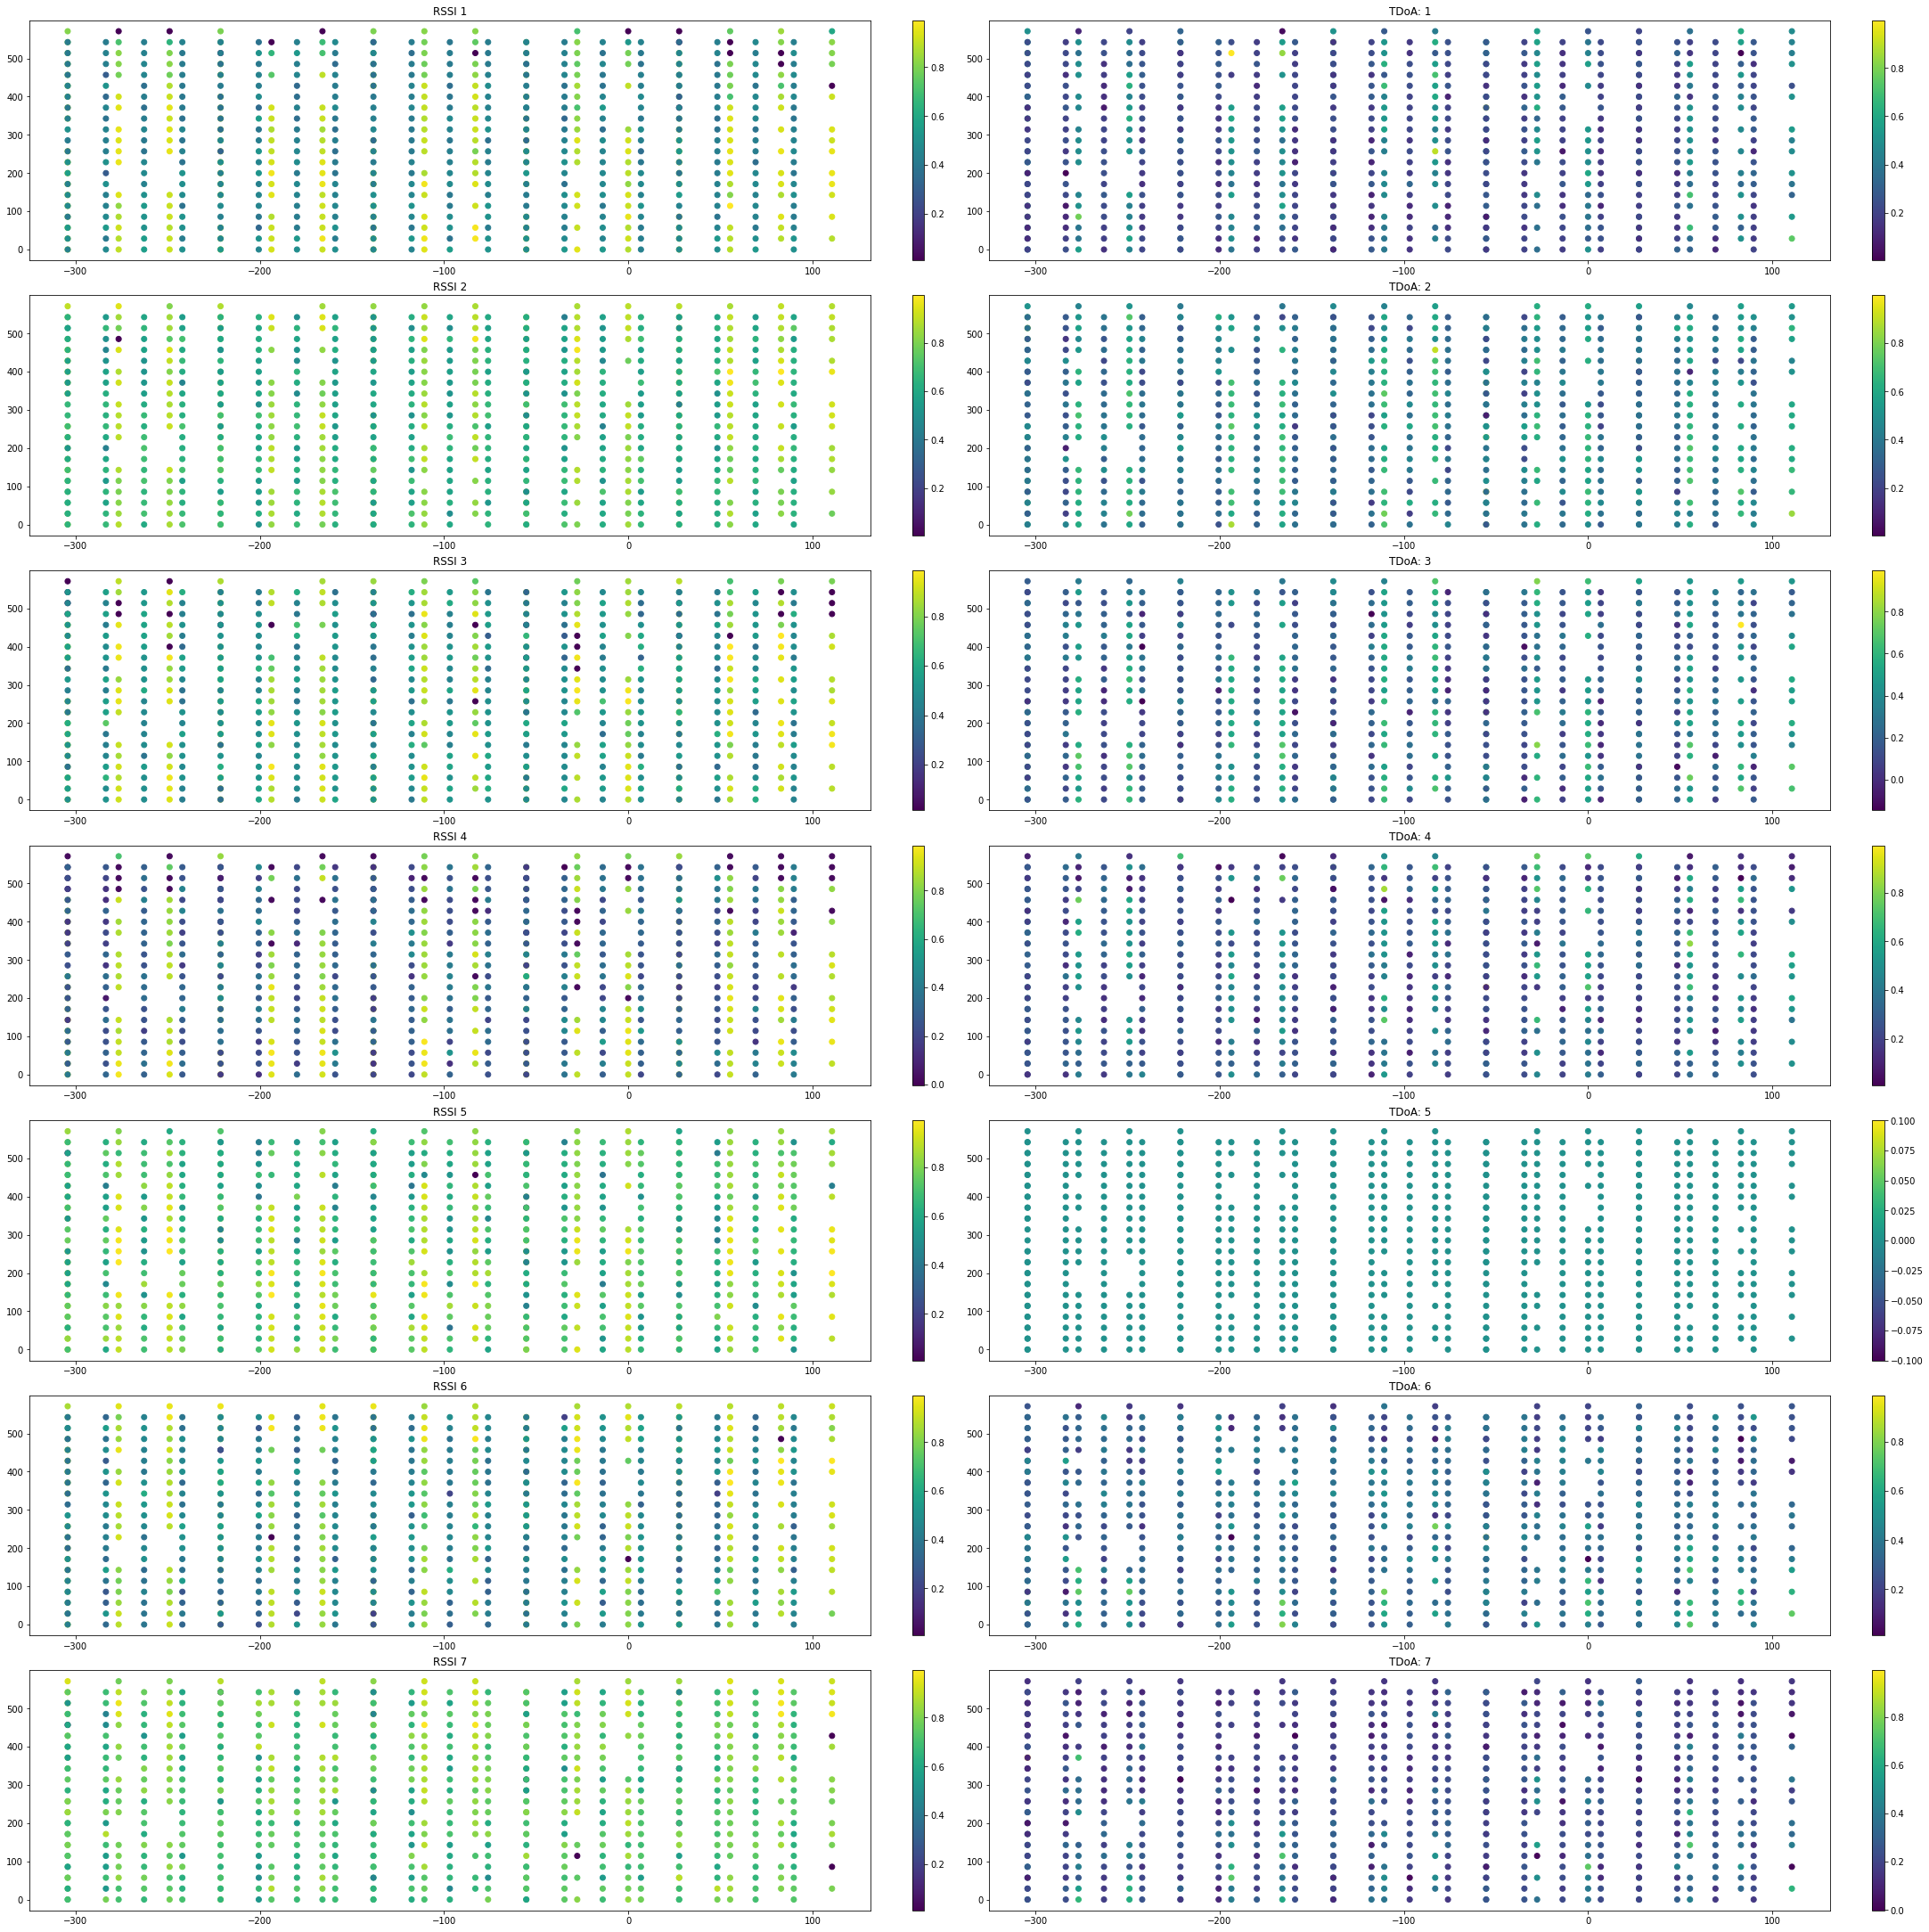

In [357]:
# Note: fp_array contains the actual raw values, avg_normalised_features contains the actual averaged normalised values
# Normalised values
# Visualise on scatter plot
plt.rcParams['figure.figsize'] = [30, 30]

num_row = 7
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if j % 2 == 0:
            axs[i][j].set_title(f'RSSI {i+1}')
        else:
            axs[i][j].set_title(f'TDoA: {i+1}')
        plot = axs[i][j].scatter(X_train_augmented_df['rp_x'], X_train_augmented_df['rp_y'], c = rp_features[:,((2*i) + j)])
        plt.colorbar(plot, ax = axs[i, j])

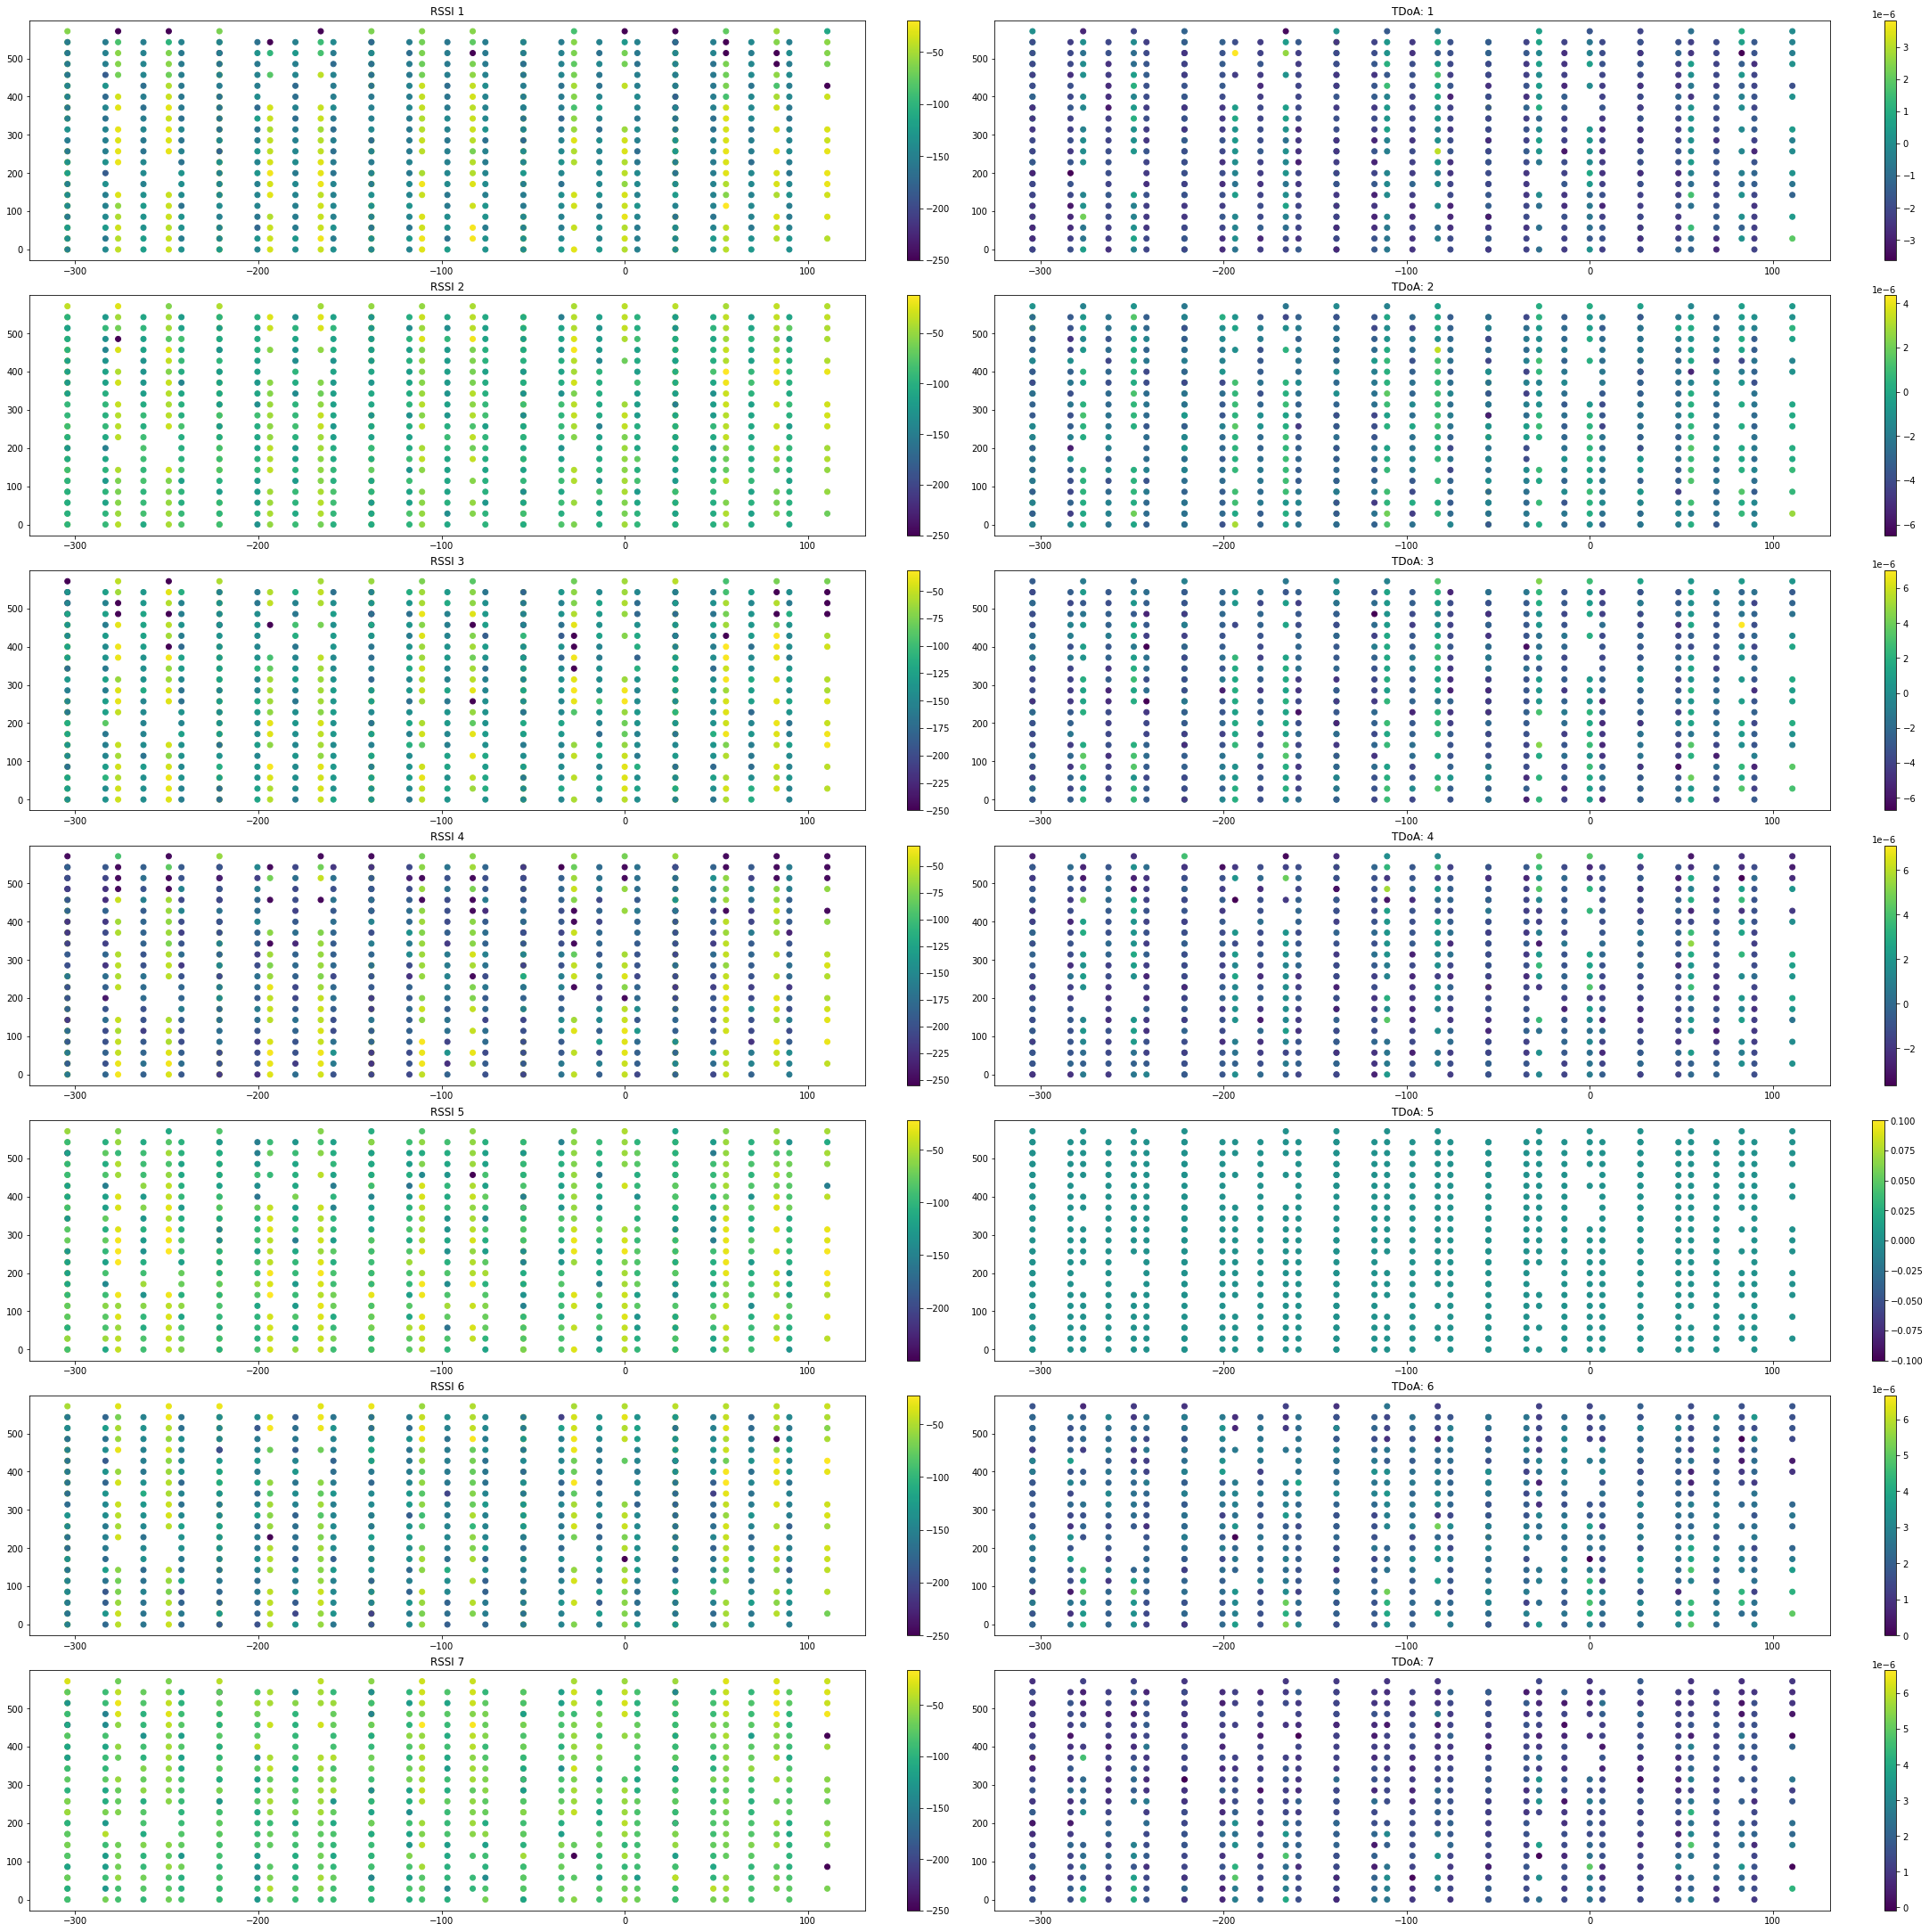

In [358]:
# Actual raw values
'''
Scaling to a range of (0,1) is good when:
- Know approximate upper and lower bounds on data with few or no outliers
- Data is approximately uniformly distributed across that range
'''
def scale_down(raw_x, min_val, max_val):
    return (raw_x - min_val) / (max_val - min_val)

def scale_up(scaled_x, min_val, max_val):
    return min_val + scaled_x*(max_val - min_val)

plt.rcParams['figure.figsize'] = [30, 30]
num_row = 7
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        # Get actual features
        actual_raw_values = fp_array[:,:,(2*i)+j]
        min_raw_value = np.amin(actual_raw_values)
        max_raw_value = np.amax(actual_raw_values)
        
        scaled_down_values = rp_features[:, ((2*i) + j)]
        scaled_up_values = np.zeros(*scaled_down_values.shape, dtype = np.float32) 
        for idx in range(len(scaled_up_values)):
            scaled_up_values[idx] = scale_up(scaled_down_values[idx], min_raw_value, max_raw_value)
            
        if j % 2 == 0:
            axs[i][j].set_title(f'RSSI {i+1}')
        else:
            axs[i][j].set_title(f'TDoA: {i+1}')
        plot = axs[i][j].scatter(X_train_augmented_df['rp_x'], X_train_augmented_df['rp_y'], c = scaled_up_values)
        plt.colorbar(plot, ax = axs[i, j])

In [359]:
# Get actual and virtual RP features
# avg_normalised_features
# virtual_rps_features

# Get actual and virtual RP coordinates
actual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
virtual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 0.0]

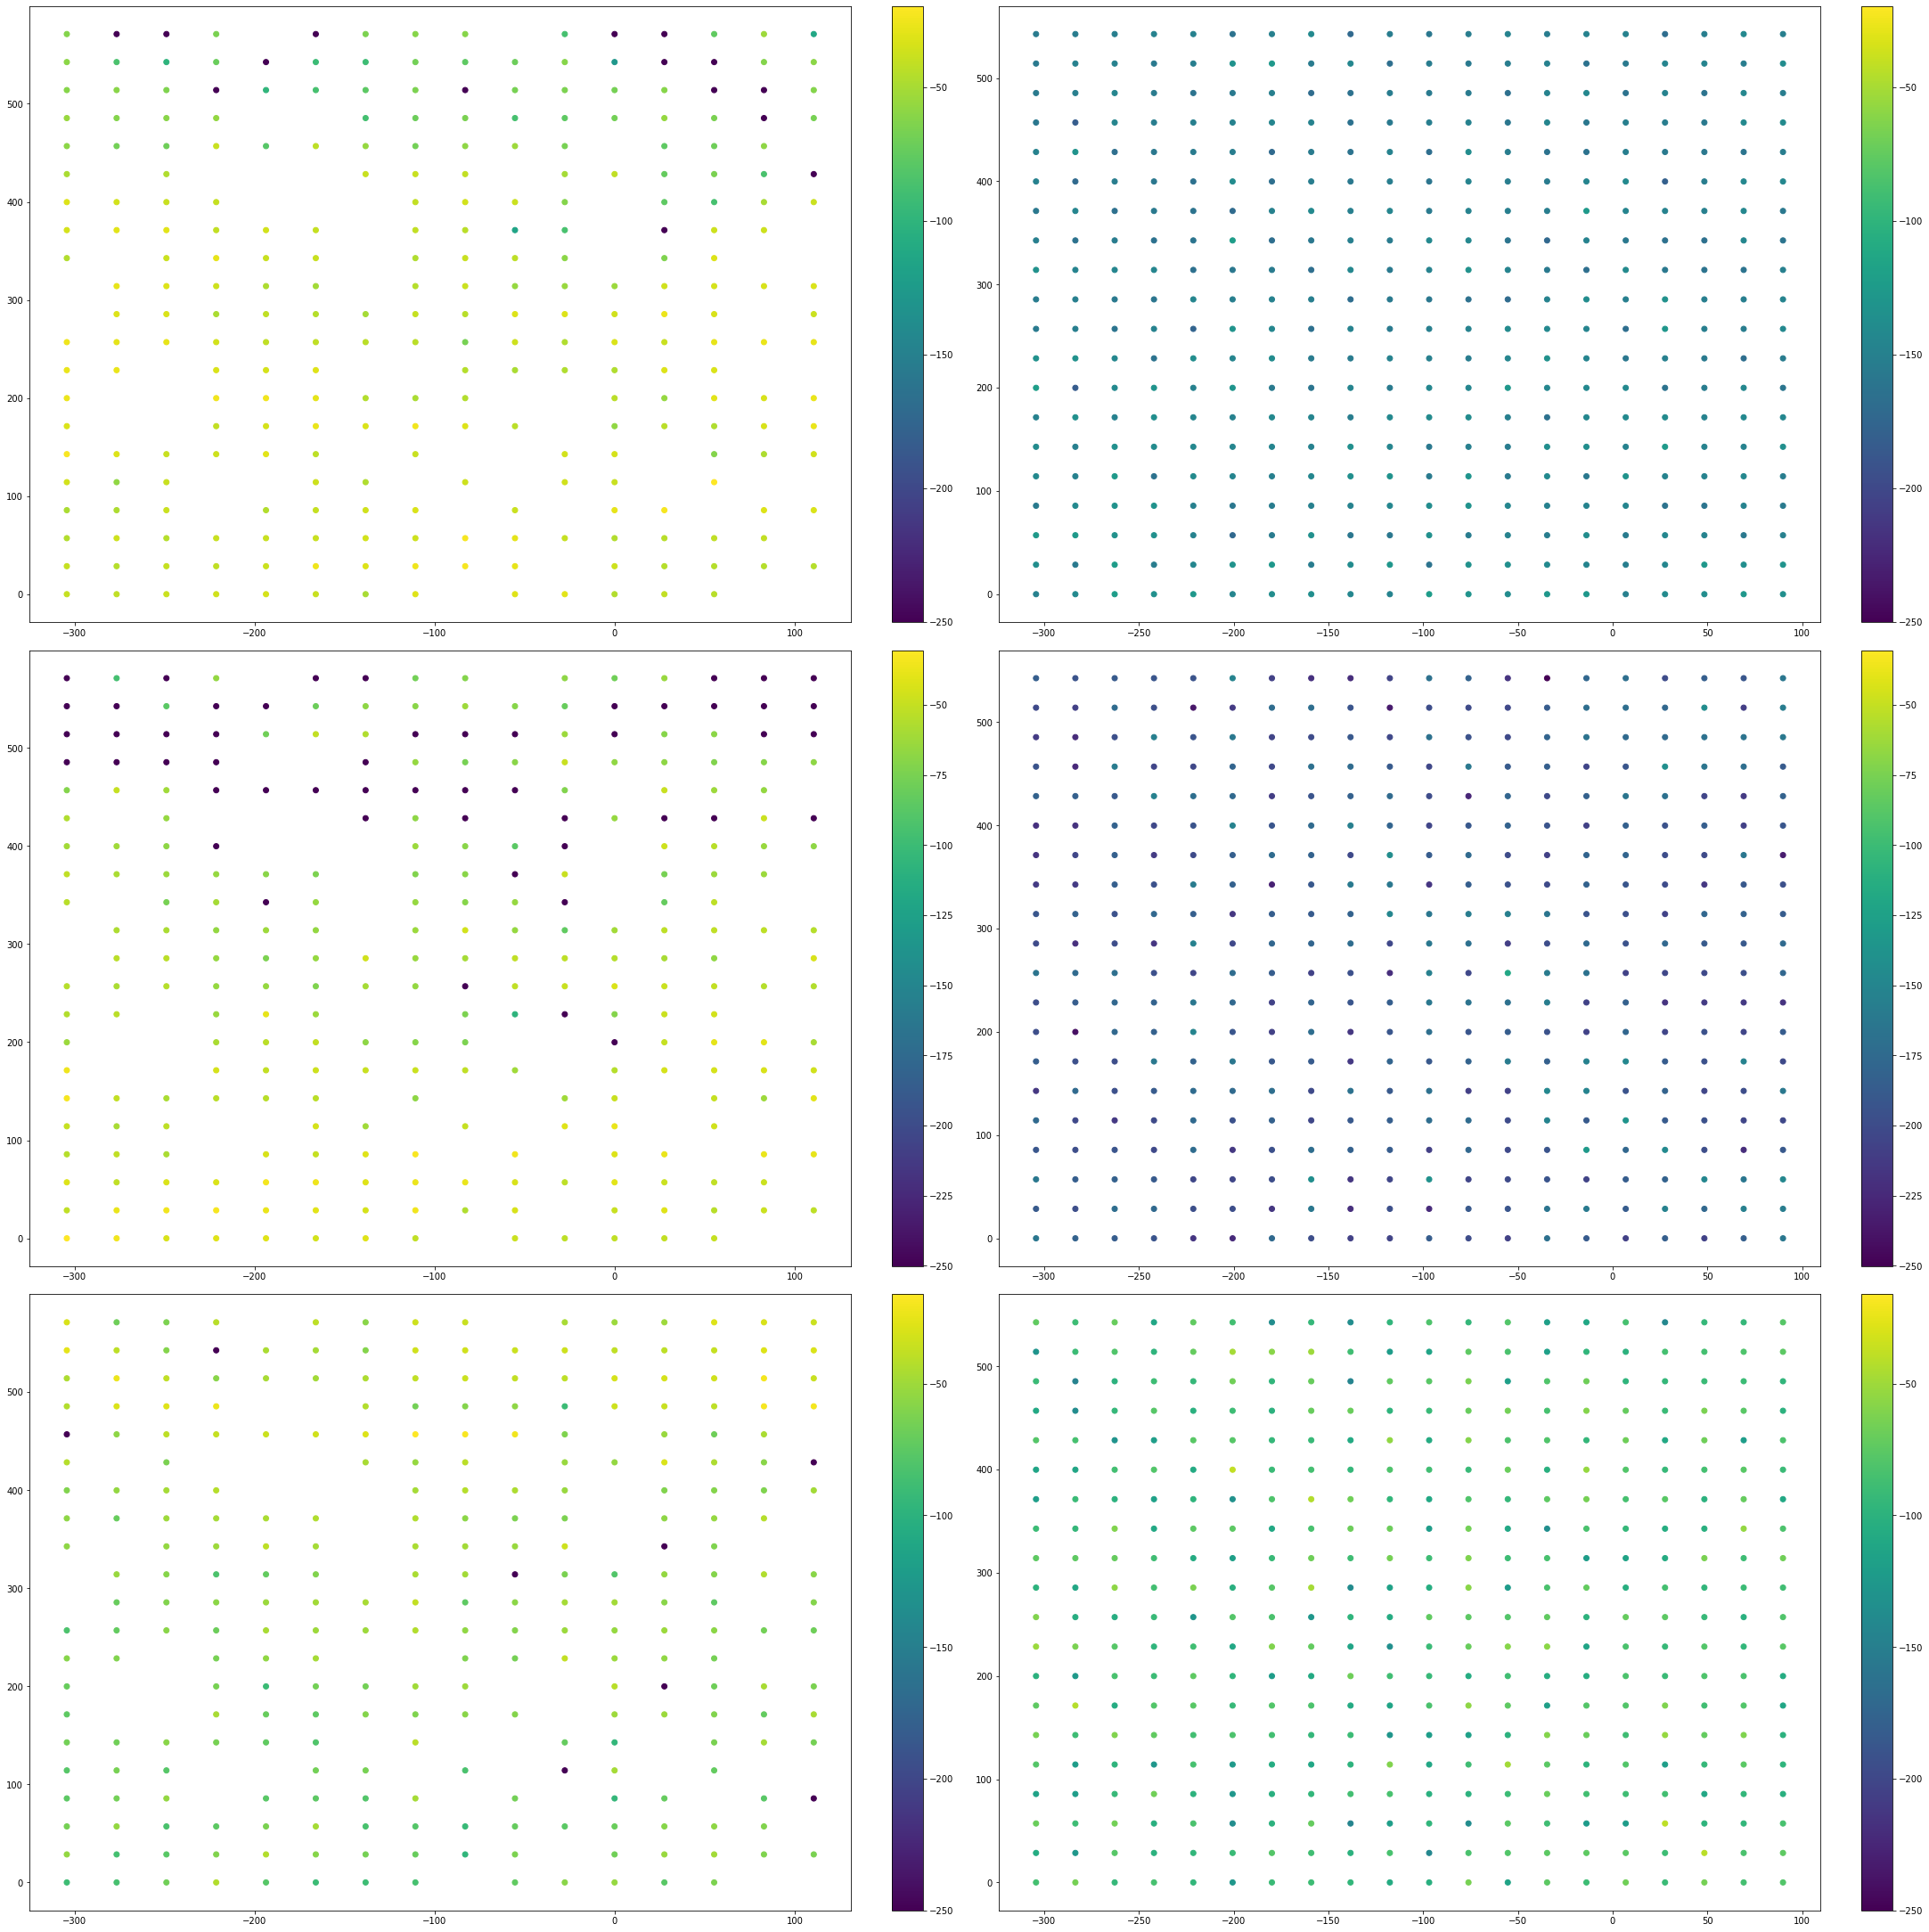

In [360]:
plt.rcParams['figure.figsize'] = [30, 30]
num_row = 3
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True)

# Plot for RSSI
for i in range(num_row):
    
    # rssi1, tdoa1, rssi2, tdoa2, ..., rssi7, tdoa7
    # rssi idxs (rssi1, 4 and 7): 0, 6, 12
    # tdoa idxs (tdoa1, 4 and 7): 1, 7, 13  
    cur_rssi_idx = 0 + 6*i

    # Get actual features and scale up to actual value range
    actual_raw_values = fp_array[:,:,cur_rssi_idx]
    min_raw_value = np.amin(actual_raw_values)
    max_raw_value = np.amax(actual_raw_values)
    
    # Scale features back to actual range
    selected_actual_features = avg_normalised_features[:, cur_rssi_idx]
    scaled_up_values = np.zeros(*selected_actual_features.shape, dtype = np.float32) 
    for idx in range(len(scaled_up_values)):
        scaled_up_values[idx] = scale_up(selected_actual_features[idx], min_raw_value, max_raw_value)

    # Set a consistent colour bar for both plots in the same row          
    vmin = np.amin(scaled_up_values)
    vmax = np.amax(scaled_up_values)
    
    for j in range(num_col):

        # Plot actual rp features on left column (j = 0)
        if j == 0:

            # Plot the results
            plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = scaled_up_values,
                                    vmin = vmin, vmax = vmax)
            plt.colorbar(plot, ax = axs[i, j])
            
        # Plot virtual rp features on right column (j = 1)
        else:
            
            # Get virtual rp features
            selected_virtual_features = virtual_rps_features[:, cur_rssi_idx]
            
            # Scale features back to actual range
            scaled_up_values = np.zeros(*selected_virtual_features.shape, dtype = np.float32) 
            for idx in range(len(scaled_up_values)):
                scaled_up_values[idx] = scale_up(selected_virtual_features[idx], min_raw_value, max_raw_value)
            
            # Plot the results
            plot = axs[i][j].scatter(virtual_rps_df['rp_x'], virtual_rps_df['rp_y'], c = scaled_up_values,
                                    vmin = vmin, vmax = vmax)
            plt.colorbar(plot, ax = axs[i, j])

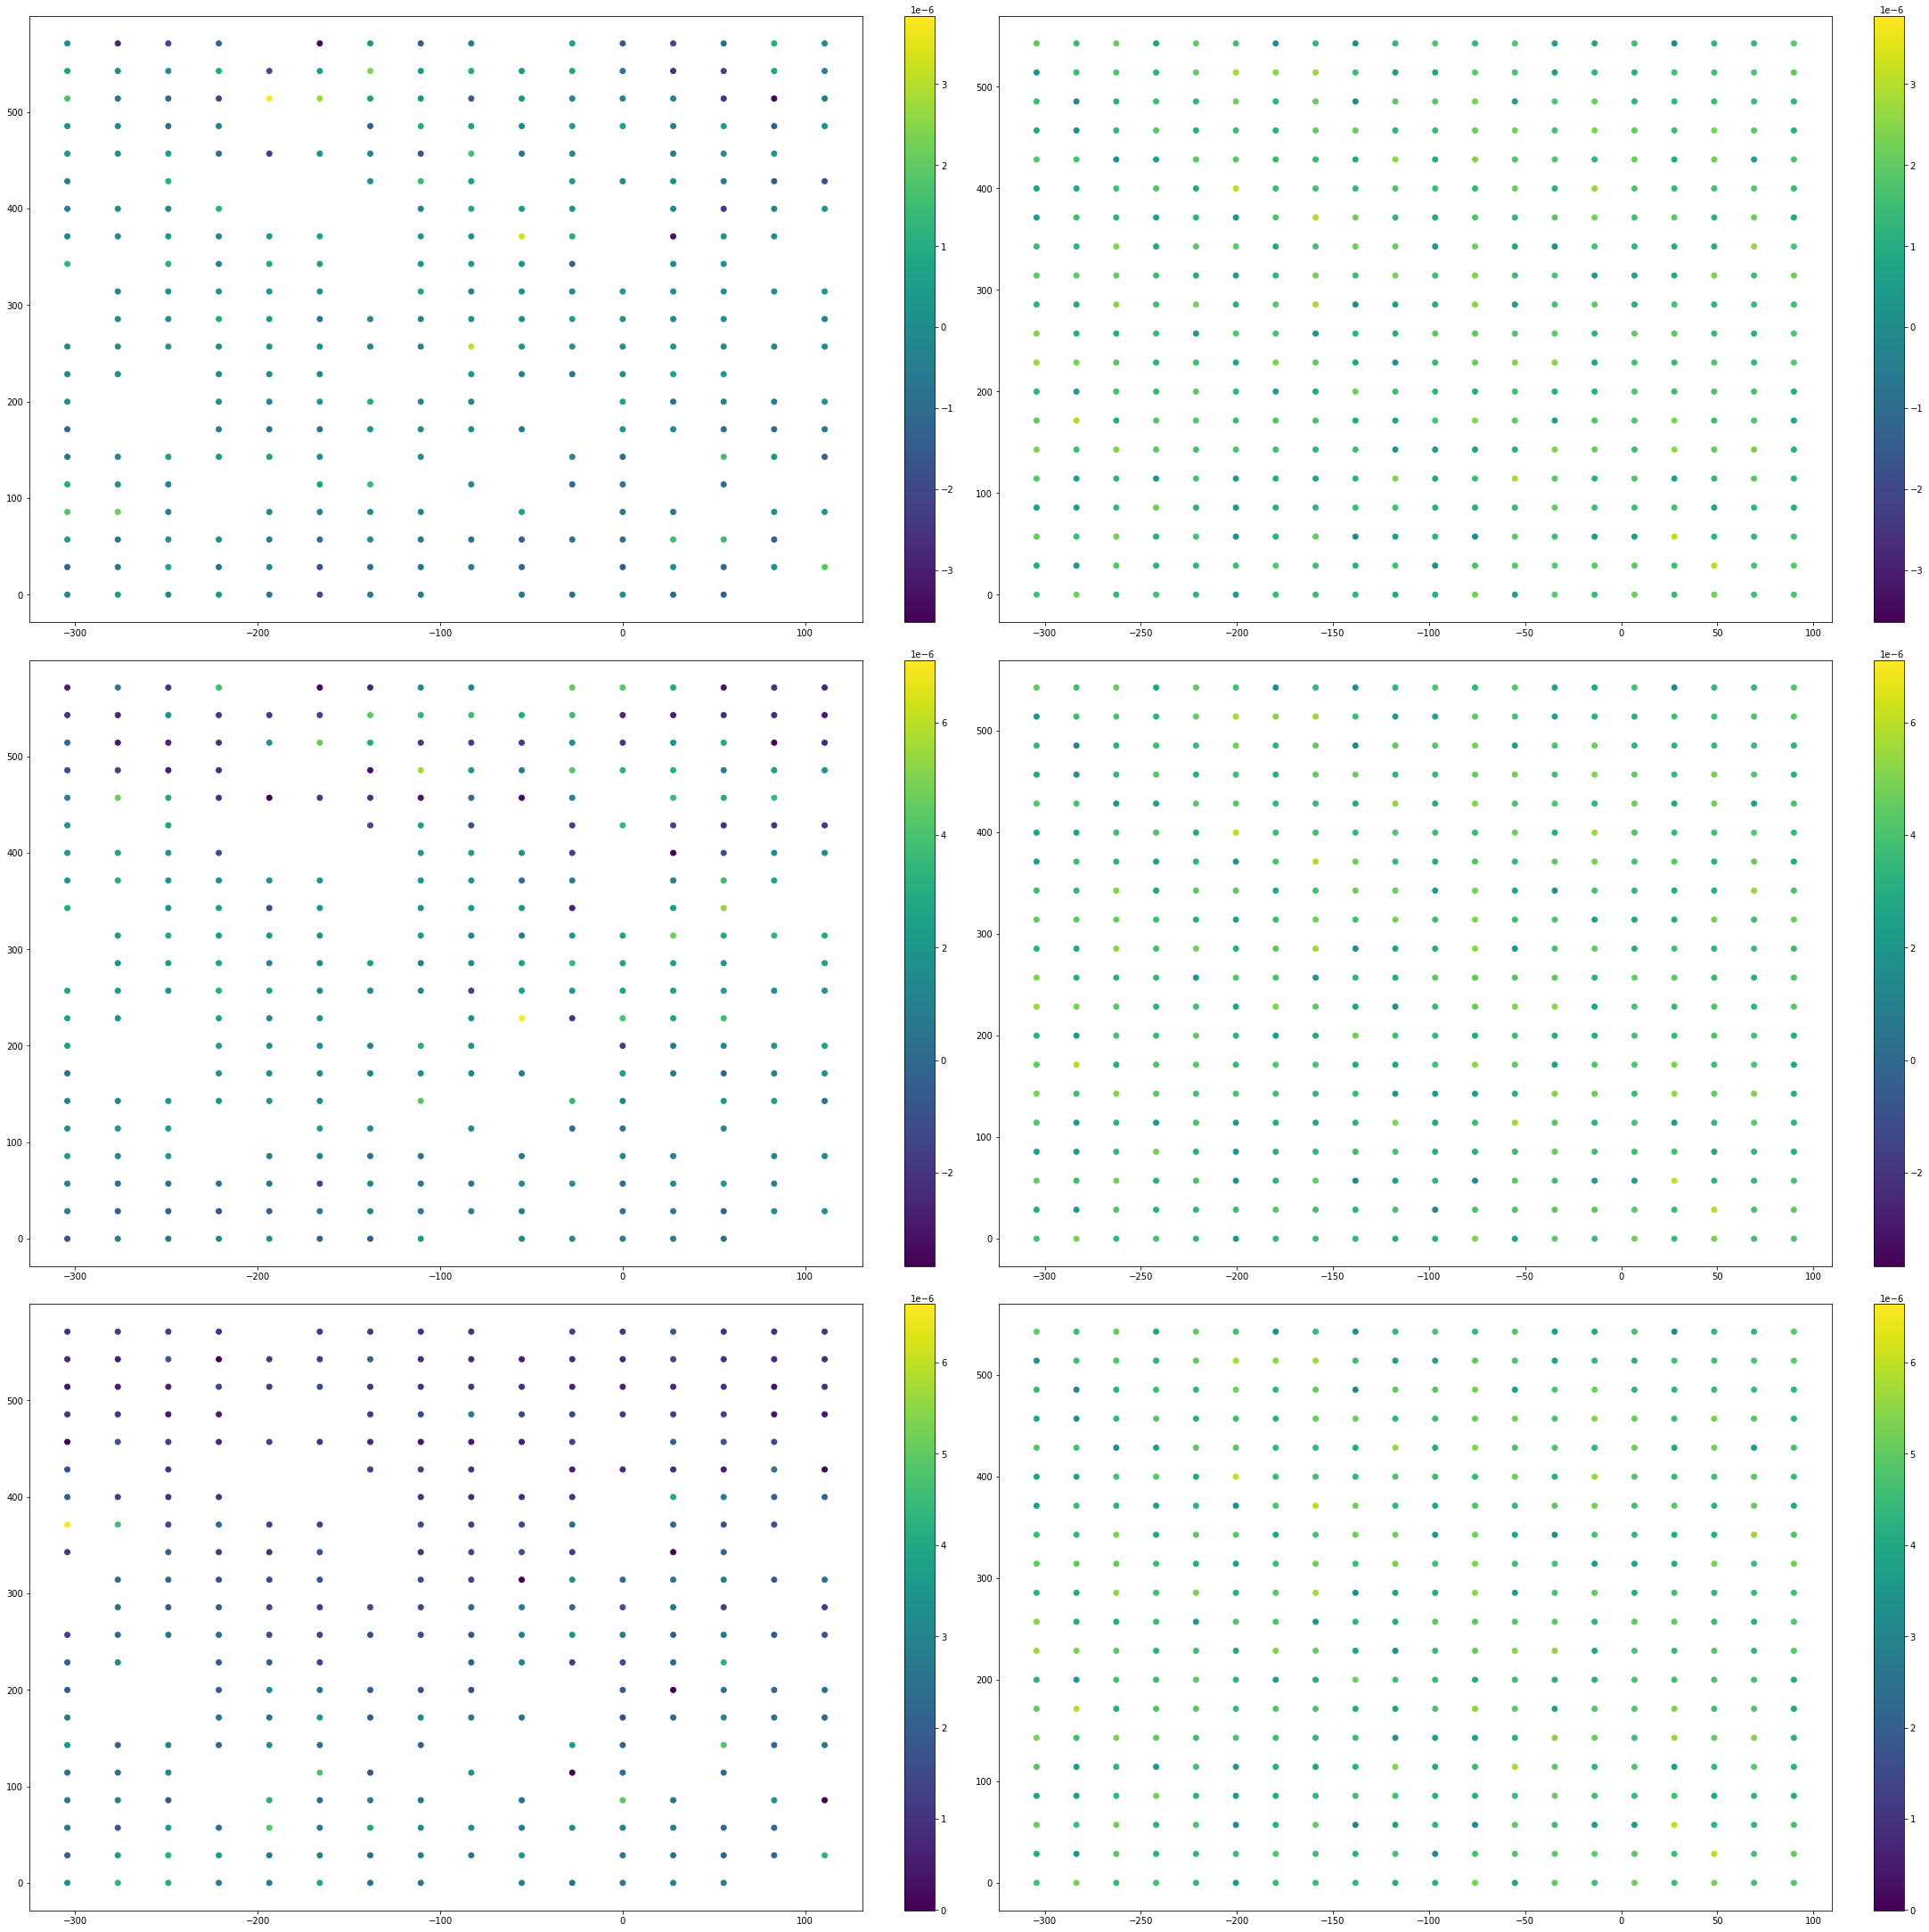

In [361]:
plt.rcParams['figure.figsize'] = [30, 30]
num_row = 3
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True)

# Plot for RSSI
for i in range(num_row):
    
    # rssi1, tdoa1, rssi2, tdoa2, ..., rssi7, tdoa7
    # rssi idxs (rssi1, 4 and 7): 0, 6, 12
    # tdoa idxs (tdoa1, 4 and 7): 1, 7, 13  
    cur_tdoa_idx = 1 + 6*i

    # Get actual features and scale up to actual value range
    actual_raw_values = fp_array[:,:,cur_tdoa_idx]
    min_raw_value = np.amin(actual_raw_values)
    max_raw_value = np.amax(actual_raw_values)
    
    # Scale features back to actual range
    selected_actual_features = avg_normalised_features[:, cur_tdoa_idx]
    scaled_up_values = np.zeros(*selected_actual_features.shape, dtype = np.float32) 
    for idx in range(len(scaled_up_values)):
        scaled_up_values[idx] = scale_up(selected_actual_features[idx], min_raw_value, max_raw_value)

    # Set a consistent colour bar for both plots in the same row          
    vmin = np.amin(scaled_up_values)
    vmax = np.amax(scaled_up_values)
    
    for j in range(num_col):

        # Plot actual rp features on left column (j = 0)
        if j == 0:

            # Plot the results
            plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = scaled_up_values,
                                    vmin = vmin, vmax = vmax)
            plt.colorbar(plot, ax = axs[i, j])
            
        # Plot virtual rp features on right column (j = 1)
        else:
            
            # Get virtual rp features
            selected_virtual_features = virtual_rps_features[:, cur_rssi_idx]
            
            # Scale features back to actual range
            scaled_up_values = np.zeros(*selected_virtual_features.shape, dtype = np.float32) 
            for idx in range(len(scaled_up_values)):
                scaled_up_values[idx] = scale_up(selected_virtual_features[idx], min_raw_value, max_raw_value)
            
            # Plot the results
            plot = axs[i][j].scatter(virtual_rps_df['rp_x'], virtual_rps_df['rp_y'], c = scaled_up_values,
                                    vmin = vmin, vmax = vmax)
            plt.colorbar(plot, ax = axs[i, j])

## Step 9 (Part 1): Train model to get variance of measurements

In [407]:
# placeholders can be removed from __init__() function for GraphSAGE and edge iterator 
# Leave it as it is first and decide whether to remove later
placeholders = construct_placeholders()

# Get data
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()
actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Normalise data
# For each of the 14th measurement (col) for each RP sample, find the min and max value
num_features = 14
normalised_features = []

for i in range(num_features):
    
    # skip over TDoA 5
    if i == 9:
        continue
        
    # Get the i-th measurements for all reference points for all samples
    feature_arr = actual_rps_measurements[:,:,i]
    # print(feature_arr.shape)
    # Find out min and max value for the i-th measurement
    min_val = np.amin(feature_arr)
    max_val = np.amax(feature_arr)
    
    tmp = np.zeros(shape = feature_arr.shape, dtype = np.float32)
    # Iterate over no. of reference points
    for j in range(tmp.shape[0]):
        
        # Iterate over no. of samples
        for k in range(tmp.shape[1]):
            
            # Account for division by 0
            if max_val - min_val == 0:
                tmp[j][k] = 0

            # Perform normalisation using math formula
            else:
                tmp[j][k] = (feature_arr[j][k] - min_val) / (max_val - min_val)
    
    normalised_features.append(tmp)
    
normalised_features = np.array(normalised_features)
# print(normalised_features.shape)

# Get mean of the 100 samples
var_normalised_features = np.var(normalised_features, axis = 2)
var_normalised_features = var_normalised_features.T

# print(actual_rps_indexes)

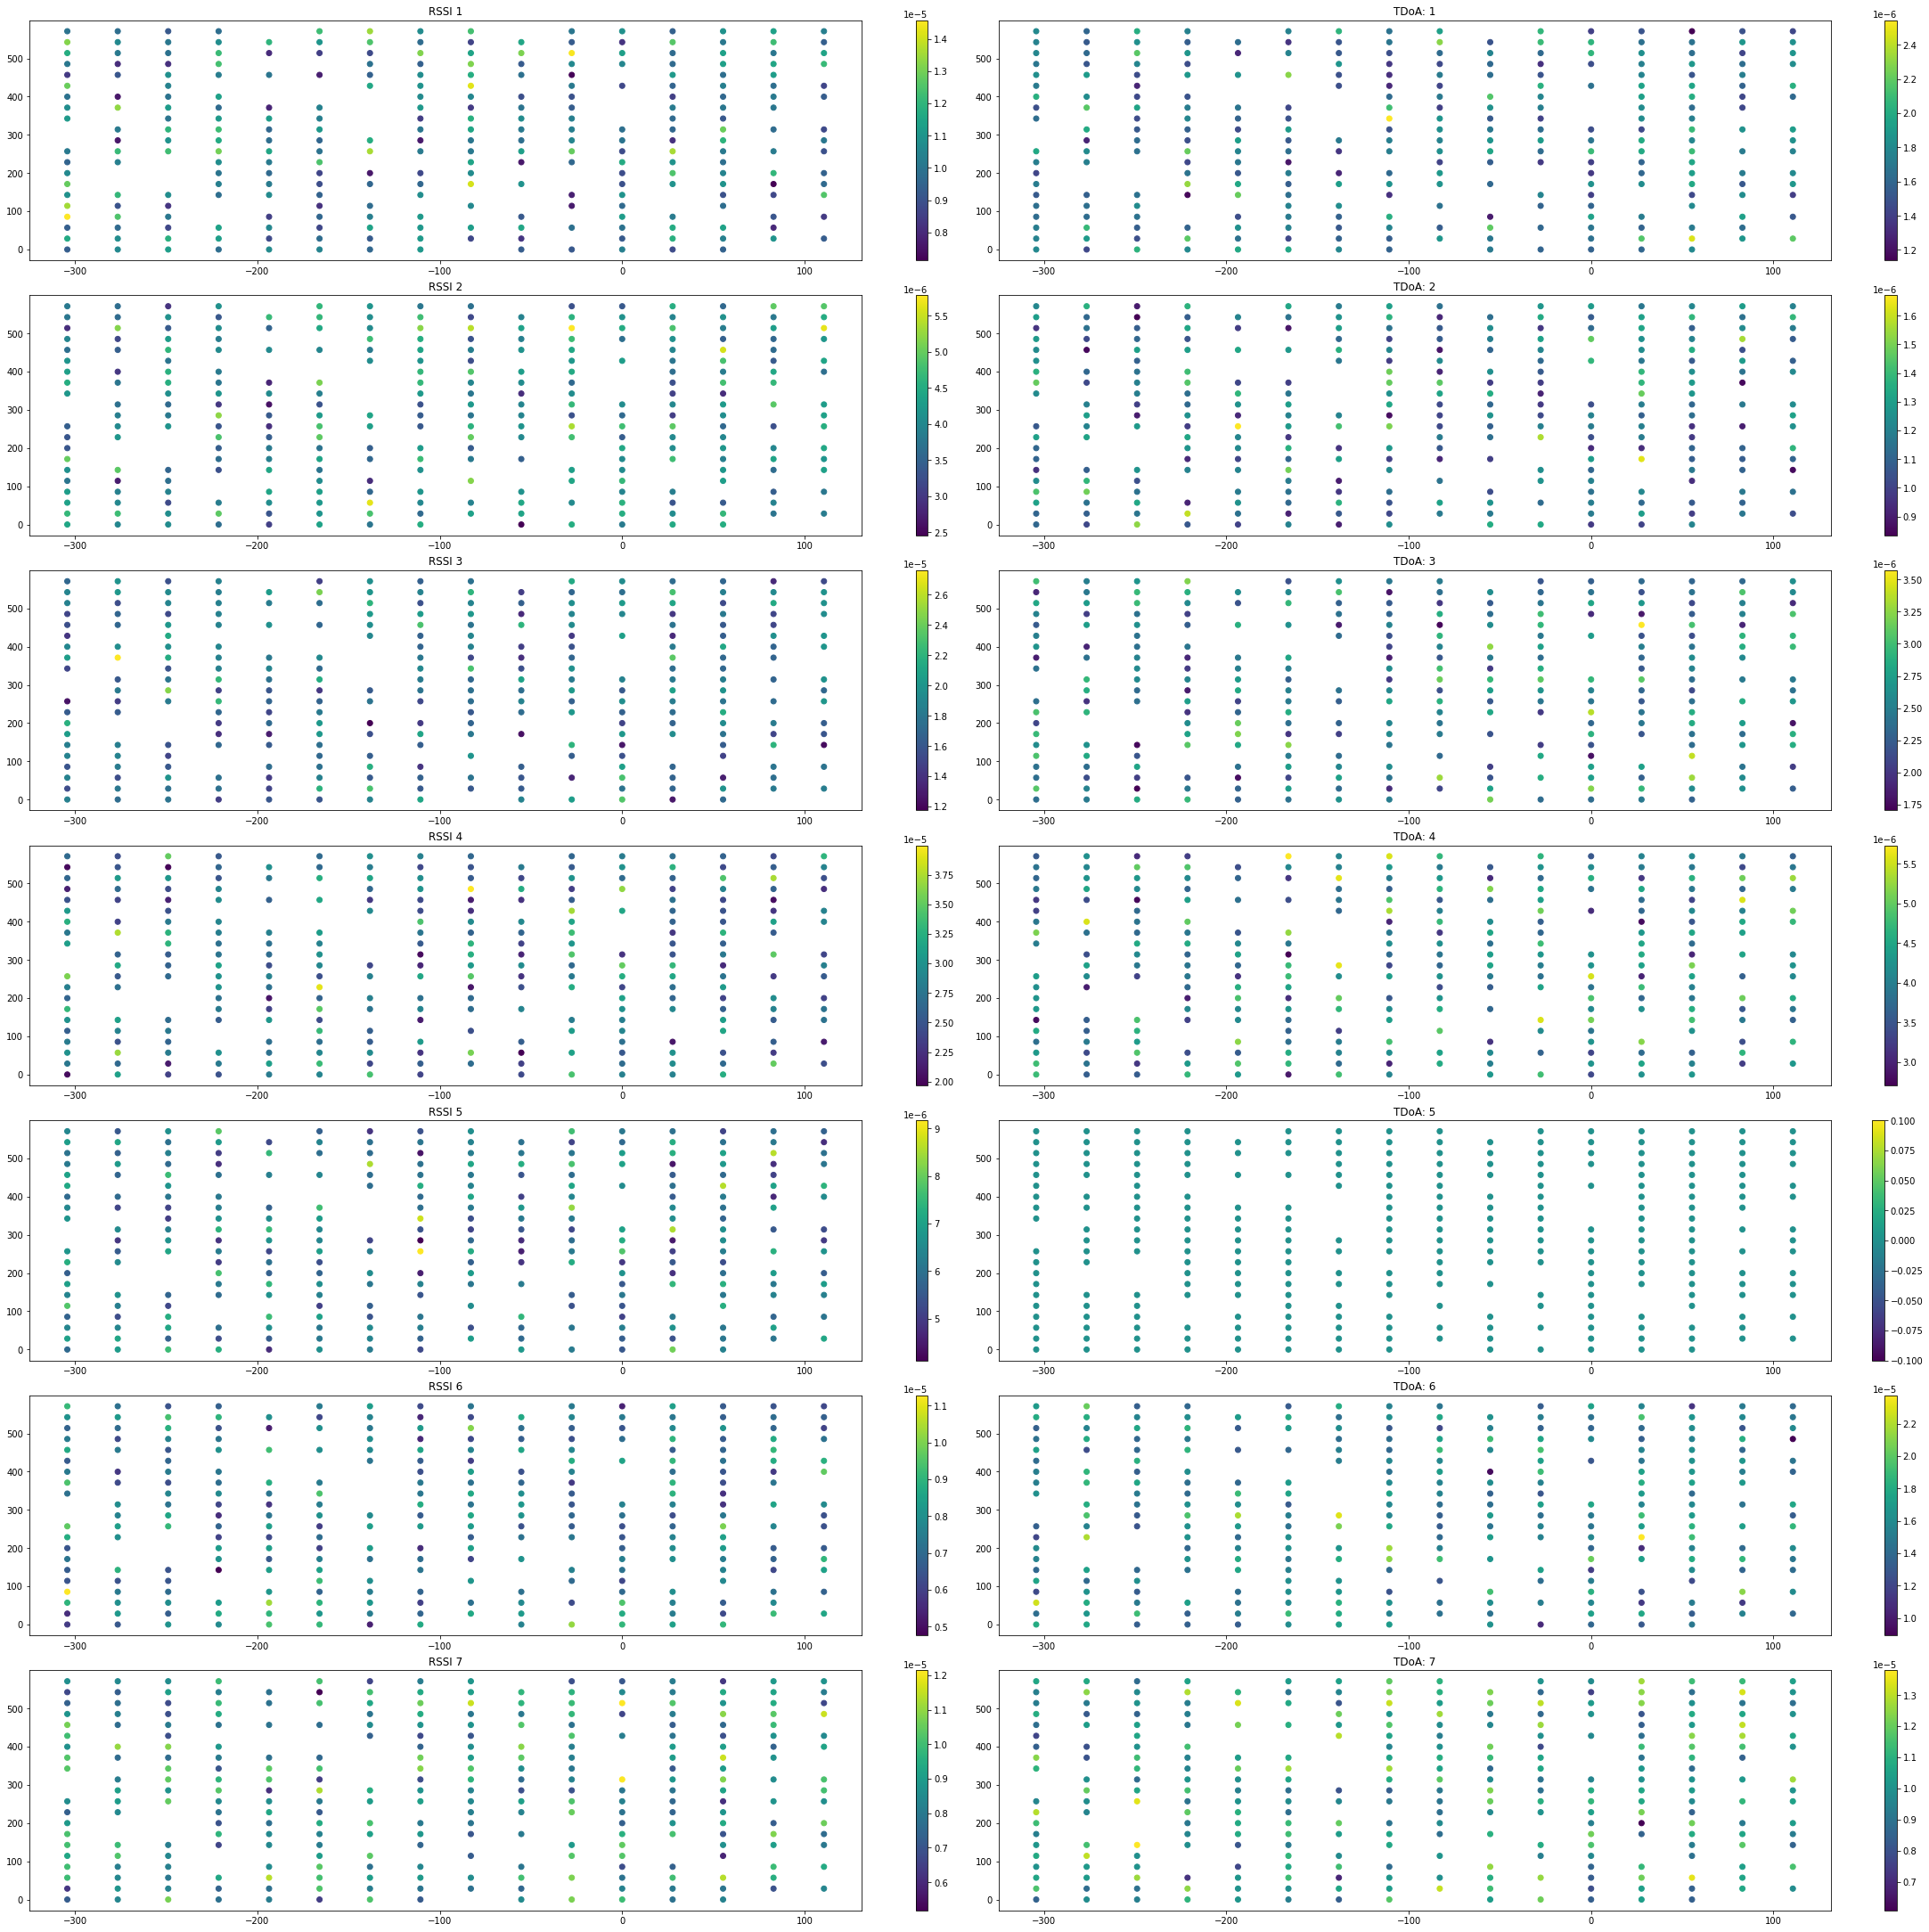

In [382]:
# Note: fp_array contains the actual raw values, avg_normalised_features contains the actual averaged normalised values
# Normalised values
# Visualise on scatter plot

# Observations: Values derived from MinMax scaler are small and very close to 0. This may cause a problem when calculating loss and the model may not learn
# the gradient well
plt.rcParams['figure.figsize'] = [30, 30]

actual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
num_rps = len(var_normalised_features)
tdoa_5_col = np.zeros((num_rps,))
var_normalised_features = np.insert(var_normalised_features, 9, tdoa_5_col, axis = 1)

num_row = 7
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if j % 2 == 0:
            axs[i][j].set_title(f'RSSI {i+1}')
        else:
            axs[i][j].set_title(f'TDoA: {i+1}')
        plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = var_normalised_features[:,((2*i) + j)])
        plt.colorbar(plot, ax = axs[i, j])

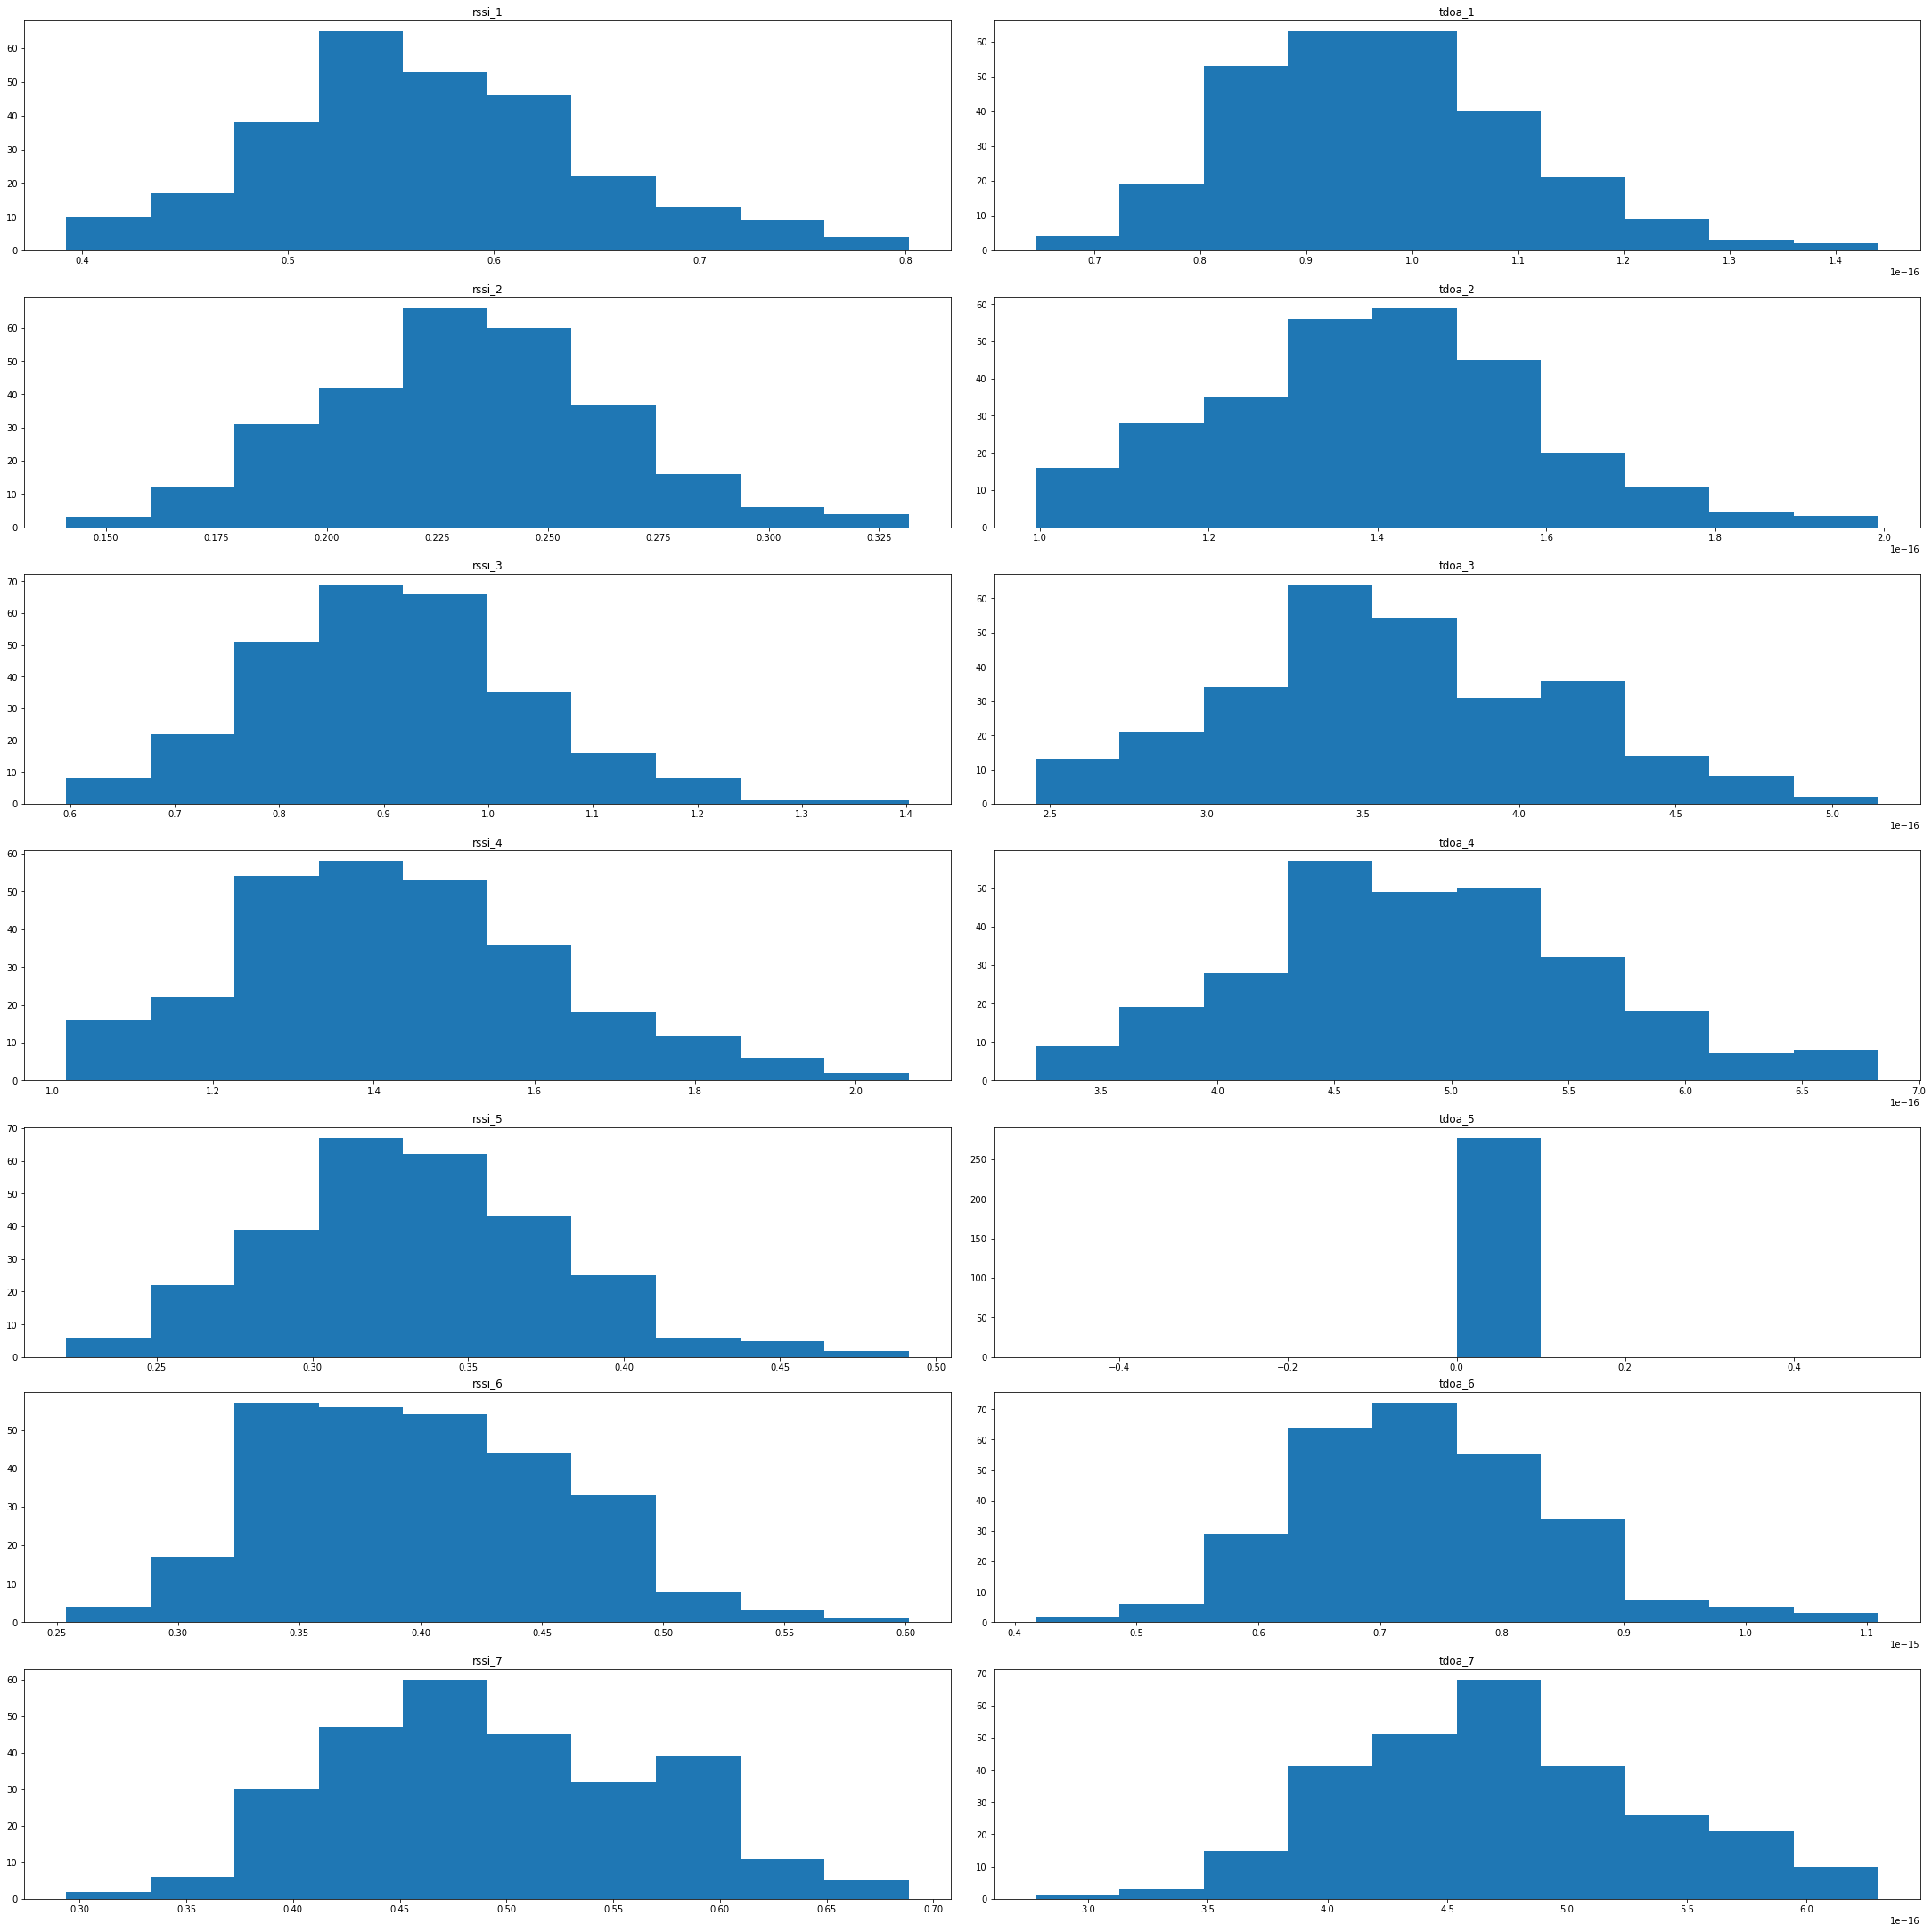

In [435]:
# Features distribution appears to follow a normal distribution. Can use Scikit-Learn StandardScaler to scale value based on a standardised normal distribution
var_features = np.var(actual_rps_measurements, axis = 1)

plt.rcParams['figure.figsize'] = [30, 30]
num_row = 7
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 

for i in range(num_row):
    for j in range(num_col):
    
        cur_feature = var_features[:,(2*i)+j]
        
        if j == 0:
            axs[i][j].title.set_text(f'rssi_{i + 1}')
            axs[i][j].hist(cur_feature)

        
        else:
            axs[i][j].title.set_text(f'tdoa_{i + 1}')
            axs[i][j].hist(cur_feature)

(277, 100, 13)
(277, 13)


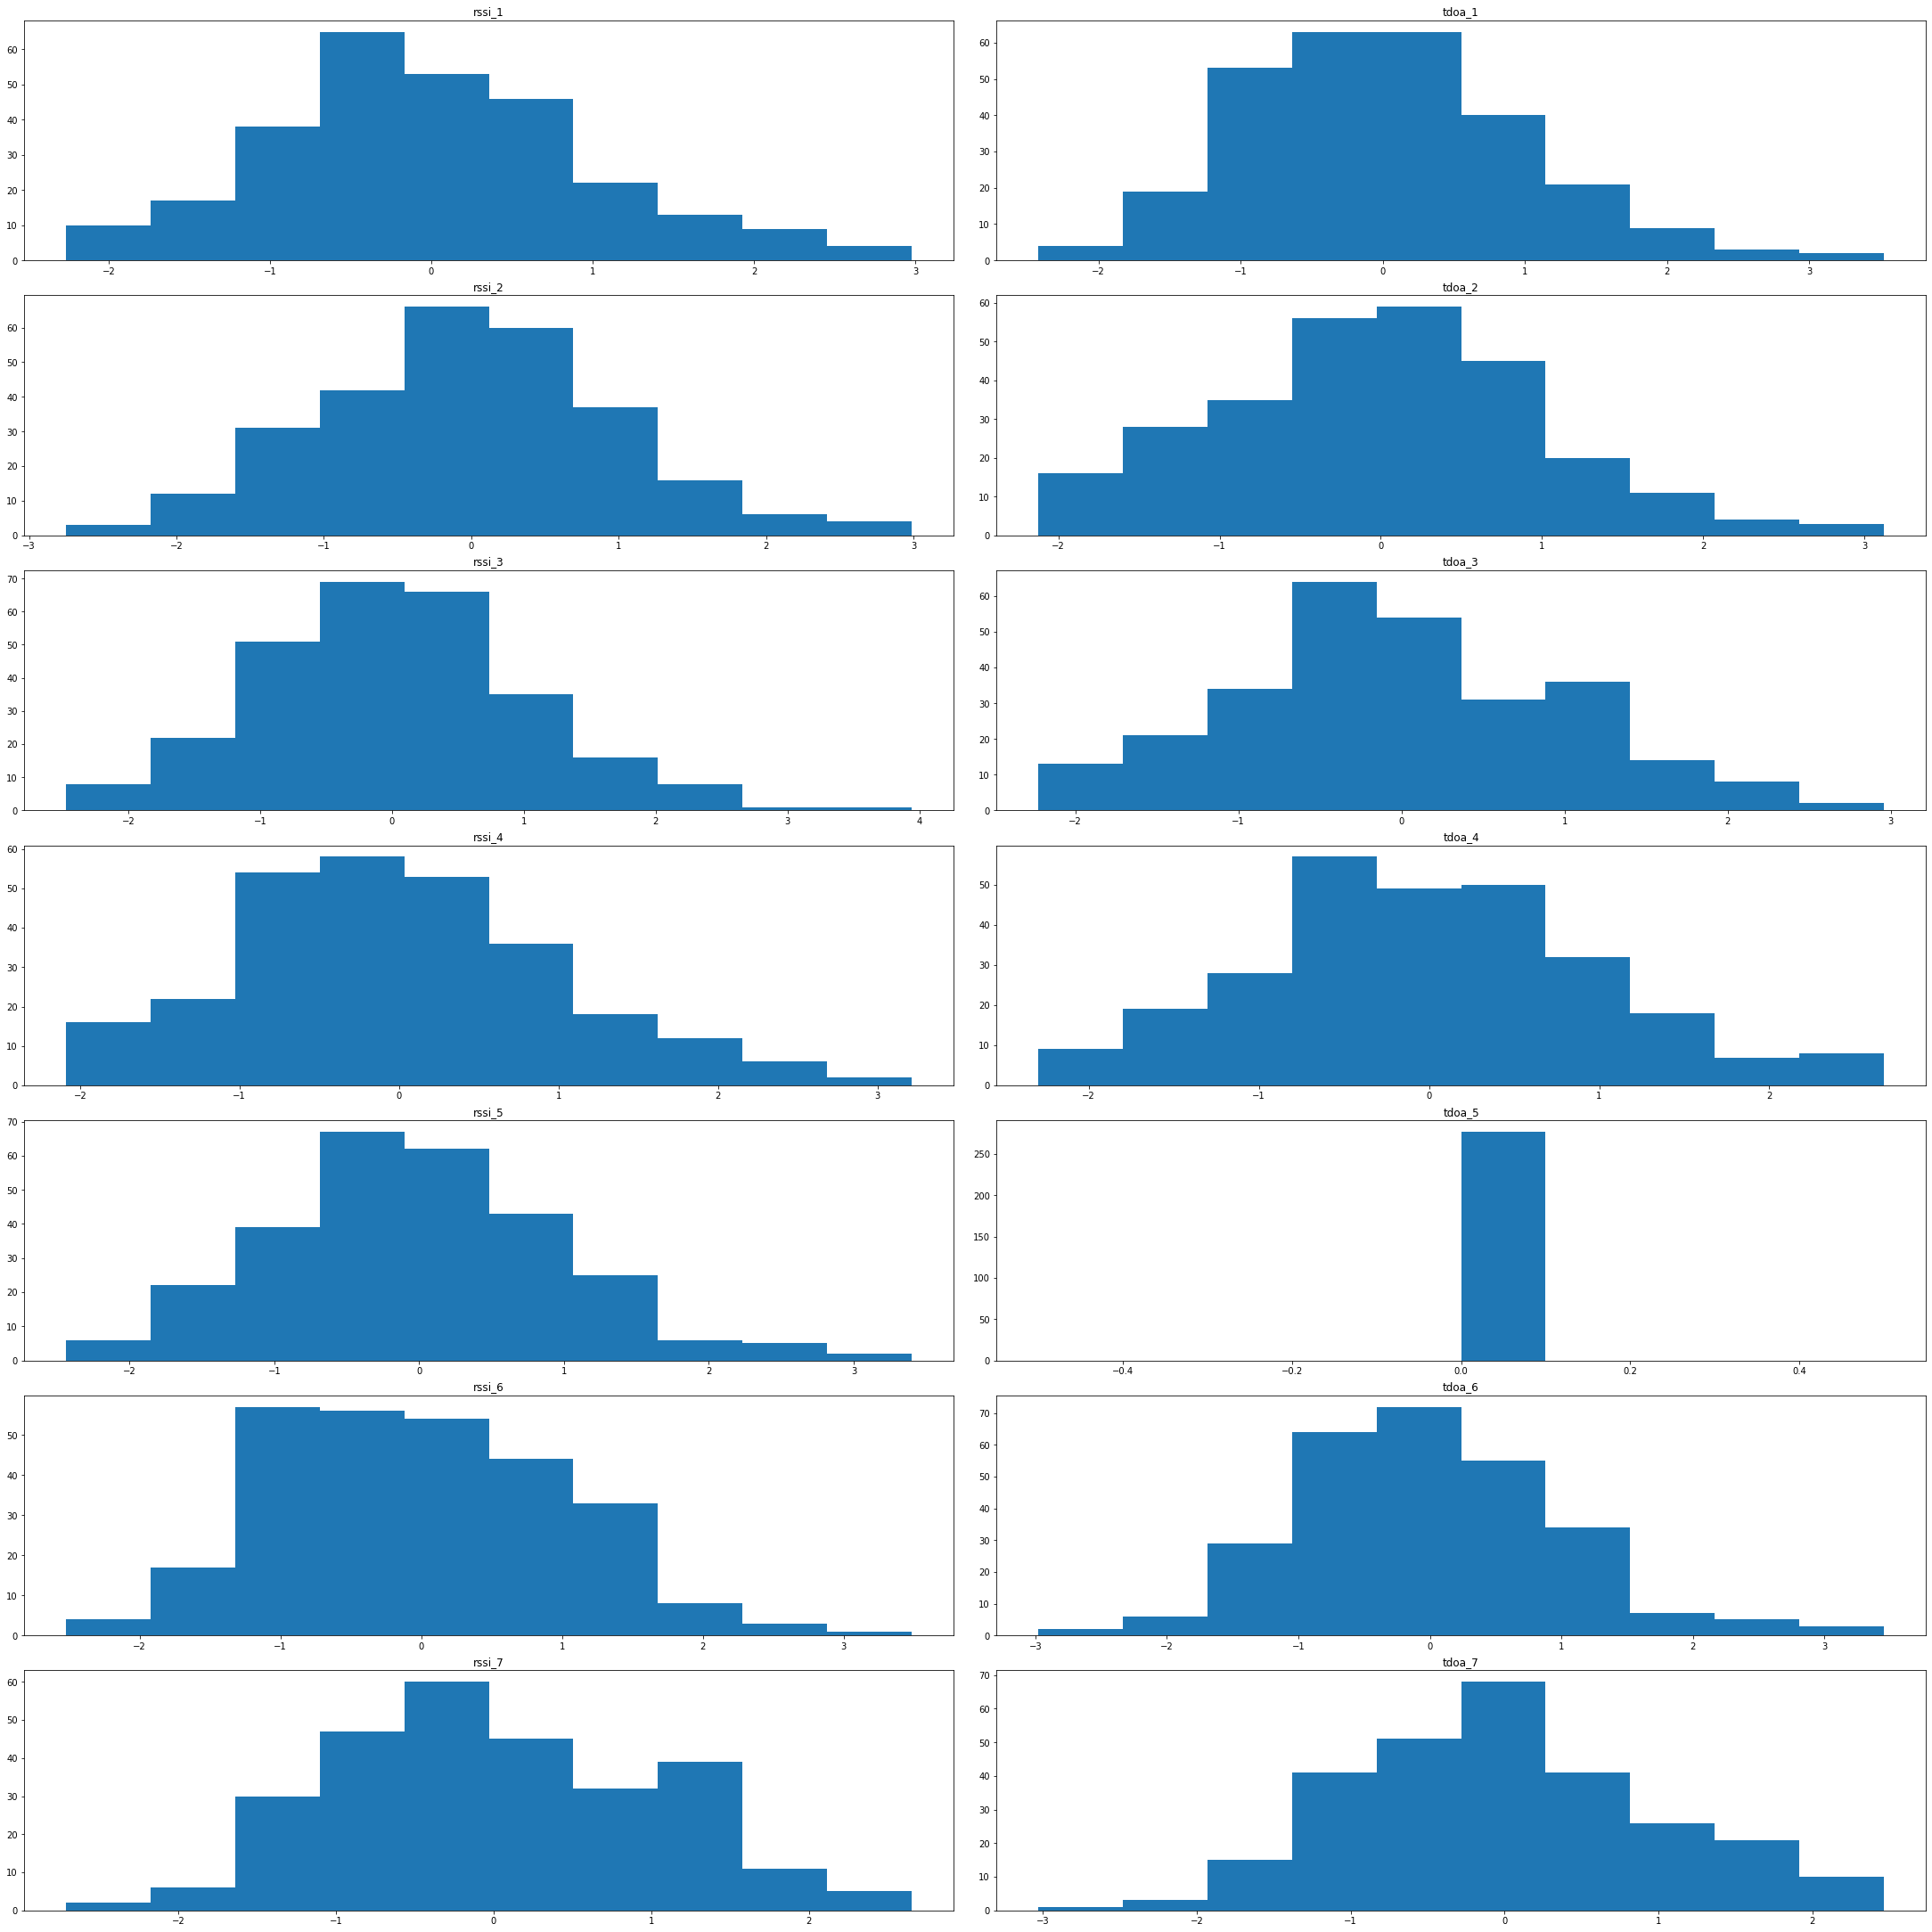

In [439]:
from sklearn.preprocessing import StandardScaler

# Get data
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()
actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Remove TDOA5 from training since all values are 0
tdoa5_removed_measurements = np.delete(actual_rps_measurements, 9, 2)
print(tdoa5_removed_measurements.shape)
var_measurements = np.var(tdoa5_removed_measurements, axis = 1)
print(var_measurements.shape)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(var_measurements)

scaled_features_copy = np.copy(scaled_features)
num_rps = len(scaled_features_copy)
tdoa_5_col = np.zeros((num_rps,))
scaled_features_copy = np.insert(scaled_features_copy, 9, tdoa_5_col, axis = 1)

plt.rcParams['figure.figsize'] = [30, 30]
num_row = 7
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 

for i in range(num_row):
    for j in range(num_col):
    
        cur_feature = scaled_features_copy[:,(2*i)+j]
        
        if j == 0:
            axs[i][j].hist(cur_feature)
            axs[i][j].title.set_text(f'rssi_{i + 1}')
        
        else:
            axs[i][j].hist(cur_feature)
            axs[i][j].title.set_text(f'tdoa_{i + 1}')
            
# TODO: Transform the scaled features back to the original scale
# original_features = scaler.inverse_transform(scaled_features)

In [440]:
# Get adjacency and degree matrix
adj = W_matrix
degrees = D_matrix

# Create graph needed for model
model_graph = nx.Graph()
num_vertices = len(W_matrix)

# Create the complete graph
for i in range(num_vertices):
    for j in range(num_vertices):
        
        if W_matrix[i][j] != 0:
            model_graph.add_edge(i, j, weight = W_matrix[i][j])

print(train_rps.shape, val_rps.shape, test_rps.shape)

# Mark the vertices in the graph on whether they are train, validation or test
# node_type = 1 for training, 0 for validation and -1 for test
for node_idx in model_graph.nodes():
    
    if node_idx in train_rps:
        model_graph.nodes[node_idx]['train'] = True
        model_graph.nodes[node_idx]['node_type'] = 1
    
    elif node_idx in val_rps:
        model_graph.nodes[node_idx]['val'] = True
        model_graph.nodes[node_idx]['node_type'] = 0
        
    else:
        model_graph.nodes[node_idx]['test'] = True
        model_graph.nodes[node_idx]['node_type'] = -1

(263,) (14,) (400,)


In [441]:
# Get layers information
from collections import namedtuple

SAGEInfo = namedtuple("SAGEInfo",
        ['layer_name', # name of the layer (to get feature embedding etc.)
         'num_samples',
         'output_dim' # the output (i.e., hidden) dimension
        ])
layer_infos = [SAGEInfo("layer_1", 10, 13),
              SAGEInfo("layer_2", 5, 13)]

In [442]:
'''
__init__() method for GraphSAGE model:
 def __init__(self, placeholders, features, graph, adj, degrees, layer_infos,
                 model_name, neg_sample_size, concat = True, model_size = 'small',
                 logging = False, learning_rate = 0.0001, params_decay = 0., **kwargs):
'''

graphsage_model_var = GraphSAGE(placeholders, scaled_features, model_graph, adj, degrees,
                           layer_infos, 'graphsage_var_v1', 50, concat = False)

In [443]:
'''def train_model(self, epochs, max_total_steps, validate_every, print_every):'''
# Source code parameters: epochs = 500, max_total_steps = 10**10, validate_every = 5000, print_every = 50 
results = graphsage_model_var.train_model(100, 10**7, 50, 50)

Unexpected missing: 0
263 train nodes
14 val nodes
400 test nodes
End of Epoch 1
train_loss: 0.080773
val_loss: 0.022082
average_time: 0.253006


KeyboardInterrupt: 